# Setup

#### Import

In [4]:
import time
import string
import inspect
import numpy as np

import cvxpy as cp

import copy, signal
import csv, datetime
import random
import itertools

import numpy.random as random_numpy
from joblib import Parallel, delayed

import matplotlib.pyplot as plt
from matplotlib import rc, rcParams
from scipy.stats import johnsonsb, cauchy, invweibull,\
                        johnsonsu, uniform, dweibull, beta, truncnorm

## Constants

In [5]:
# Ideally, enter absolute path 
home_folder = "./"

In [6]:
rng = random_numpy.default_rng(1234)
CORES = 5 ## Number of parallel threads to run

## Helper functions

In [7]:
debug = lambda str : f"print(\"{str}\",\"=\",eval(\"{str}\"))"

In [8]:
rcParams.update({
        'text.usetex': False,
        'font.family': 'stixgeneral',
        'mathtext.fontset': 'stix',
        'figure.figsize': (10,6),
})

def file_str():
    """ Auto-generates file name."""
    now = datetime.datetime.now()
    return now.strftime("H%HM%MS%S_%m-%d-%y")

rand_string = lambda length: ''.join(random.choice(string.ascii_lowercase) for i in range(length))

def pdf_savefig():
    """ Saves figures as pdf """
    fname = file_str()+rand_string(5)
    plt.savefig(home_folder+f"/figs/{fname}.pdf")

def eps_savefig():
    """ Saves figure as encapsulated postscript file (vector format)
        so that it isn't pixelated when we put it into a pdf. """
    pdf_savefig()

In [9]:
def handler(signum, frame):
   print("Forever is over!")
   raise Exception("end of time")

def handler2(signum, frame):
   print("Forever is over!")
   raise Exception("end of time")

def handler3(signum, frame):
   print("Forever is over!")
   raise Exception("end of time")

In [10]:
def rand_round_solution(x,m,n):
    rx=np.array([0]*m);
    ind=rng.choice([i for i in range(len(x))], n, replace=False, p=x/np.sum(x))
    # for i in range(n): rx[li[i][1]]=1
    for i in ind: rx[i]=1
    rx=rx.reshape((len(rx),1))
#     print("(rand-rounded-trunc): ", np.sum(rx))
    return np.array(rx)

In [11]:
def get_fairness(num_picked, n, fair_metric):
    p = len(num_picked)
    selec_lft = False; r_diff = False; custom = False
    if fair_metric == 'selec_lft': selec_lft = True
    if fair_metric == 'r_diff': r_diff = True
    if fair_metric == 'custom': custom = True
    if store_val: return val
    elif selec_lft: 
        mi = 2
        for i,j in itertools.product(range(p),range(p)): 
            mi = min(mi, num_picked[i]/num_picked[j] if num_picked[j] else 0.0)
        return mi
    elif r_diff:
        mi = -1
        for i,j in itertools.product(range(p),range(p)): 
            mi = max(mi, abs(num_picked[i]-num_picked[j])/n)
        return 1-mi
    elif custom:
        mi = 2
        for i,j in itertools.product(range(p),range(p)): 
            mi = min(mi, p/(p-1.0) * (1 - num_picked[i]/n))
        return mi
    else: print("Must choose a fairness definition!"); raise NotImplementedError

def get_rng(rand_gen=None):
    if rand_gen is not None: return rand_gen
    else: return rng

---

---

# 1. Algorithms

    Dimensions of inputs
    # w: m x 1
    # q: m x p
    # u: p x 1
    # x: m x 1
    # o: n x 1

In [12]:
def fair_select(w, q, u, n, lam=0, eps=0):
    # Outputs the ranking fair in expectation over the randomness in the candidates
    m = w.shape[0]
    p = q.shape[1]
    x = cp.Variable((m,1), boolean=True)
    # x.value = thresh_select(w, q, u, n) ## warm start
    # print("warm start:", np.sum(x.value))
    o = np.ones((m,1))
    prob = cp.Problem( cp.Maximize(w.T*x),
                      [q.T@x<=u,o.T@x<=n,o.T@x>=n-1]);
    try:
        prob.solve(solver=cp.CPLEX, cplex_params={"timelimit": 30})
    except Exception as e:
        print(e)
        print("big oops --  couldn't solve fair_select")
        return -1
    x=list(x)
    x=[y.value[0] for y in x]
    return np.array(x)

In [13]:
## LP based rounding algorithm
def fair_select_lp(w, q, u, n, lam=0, eps=0):
    # Outputs the ranking fair in expectation over the randomness in the candidates
    m=w.shape[0]
    p=q.shape[1]
    x = cp.Variable((m,1))
    # x.value = thresh_select(w, q, u, n) ## warm start
    # print("warm start:", np.sum(x.value))
    o = np.ones((m,1))
    prob = cp.Problem( cp.Maximize(w.T*x),[q.T@x<=u,o.T@x==n,x<=1,x>=0]);
    try:
        #CPLEX automatically returns an extreme point solution
        prob.solve(solver=cp.GUROBI) #, cplex_params={"timelimit": 30})
    except Exception as e:
        print(e); print("big oops --  couldn't solve fair_select_lp", flush=True)
        return -1
    x=list(x)
    x=np.array([np.clip(y.value[0],0,1) for y in x])
#     print("\nfair (frac):", np.sum(x), np.sum(x>=1e-2))
    return rand_round_solution(x,m,n)

In [14]:
## Minimizing the lagranrian for a given lamba (lam=1)
def lagrangian_solver(w, tmpq, t, n, lam=1, eps=1e-3):
    # Outputs the ranking fair in expectation over the randomness in the candidates
    q = copy.deepcopy(tmpq)
    m=w.shape[0]
    p=q.shape[1]
    for i in range(m): 
        k = np.argmax(q[i])
        q[i] =  np.zeros_like(q[i])
        q[i][k] = 1
    x = cp.Variable((m,1))
    o = np.ones((m,1))
    t = np.array(t)
    prob = cp.Problem( cp.Maximize(w.T*x - lam * cp.sum(cp.kl_div(q.T*x/n,t))),\
                      [o.T@x==n, x<=1, x>=0]);
    try: prob.solve(solver = cp.SCS, max_iters=10000, eps=1e-7, verbose=False) #, cplex_params={"timelimit": 30})
    except Exception as e: print(e); print("big oops --  couldn't solve lagrangian_solver", flush=True); return -1
    fg=0
    if str(type(x)) == "<class 'NoneType'>" or str(type(x[0])) == "<class 'NoneType'>" or\
       str(type(x[0].value)) == "<class 'NoneType'>" or str(type(x[0].value[0])) == "<class 'NoneType'>": fg=1
    if fg: print("lagrangian didn't find a solution!"); return -1
    x=list(x)
    x=np.array([np.clip(y.value[0],0,1) for y in x])
    return rand_round_solution(x,m,n)

In [15]:
## check
def lagrangian_solver_with_q(w, tmpq, t, n, lam=1, eps=1e-3):
    # Outputs the ranking fair in expectation over the randomness in the candidates
    q = copy.deepcopy(tmpq)
    m=w.shape[0]
    p=q.shape[1]
    for i in range(m): 
        k = np.argmax(q[i])
        q[i] = q[i] # np.zeros_like(q[i])
        # q[i][k] = 1
    x = cp.Variable((m,1))
    o = np.ones((m,1)) #cp.log((q.T@x)*p), cp.norm(x, 2)
    t = np.array(t) ## this is the target now
    prob = cp.Problem( cp.Maximize(w.T*x - lam * cp.sum(cp.kl_div(q.T*x/n,t))),\
                      [o.T@x==n, x<=1, x>=0]);
    #prob = cp.Problem( cp.Maximize(w.T*x - lam * cp.sum(-cp.entr(p*(q.T*x))/p)),\
    #                  [o.T@x<=n+1,o.T@x>=n-1,x<=1,x>=0]);
    try: prob.solve(solver = cp.SCS, max_iters=10000, eps=1e-7, verbose=False) #, cplex_params={"timelimit": 30})
    except Exception as e: print(e); print("big oops --  couldn't solve lagrangian_solver", flush=True); return -1
    fg=0
    if str(type(x)) == "<class 'NoneType'>" or str(type(x[0])) == "<class 'NoneType'>" or\
       str(type(x[0].value)) == "<class 'NoneType'>" or str(type(x[0].value[0])) == "<class 'NoneType'>": fg=1
    if fg: print("lagrangian didn't find a solution!"); return -1
    x=list(x)
    x=np.array([np.clip(y.value[0],0,1) for y in x])
#     print("lang (frac):", np.sum(x), np.sum(x>=1e-2))
    return rand_round_solution(x,m,n)

In [132]:
def thresh_select(w, q, u, n, lam=0, eps=0):
    # Outputs the fair ranking after thresholding the candidates

    m=w.shape[0]; p=q.shape[1]
    
    typ=[np.argmax(q[i]) for i in range(m)] # threshold
    
    li=[[-w[i], i] for i in range(m)]; li.sort() # sort
    
    y=[0]*m;sum=[0]*p;i=0;
    while(np.sum(sum)<n and i<m):
        l=typ[li[i][1]]
        if sum[l]<=u[l]: y[li[i][1]]=1; sum[l]+=1;
        i+=1
    
    if np.sum(sum) < n-1: raise Exception("Thresh found the problem infeasible!")
    
    y=np.array(y)
    y=y.reshape((len(y),1))
    
    return y

In [133]:
def blind_select(w, q, u, n, lam=0, eps=0):
    # Outputs the optimal ranking without fairness constraints
    
    m=w.shape[0]; p=q.shape[1]
    
    li=[[-w[i], i] for i in range(m)]; li.sort() # sort
    
    y=np.array([0]*m);
    for i in range(n): y[li[i][1]]=1
    y=y.reshape((len(y),1))
    return y


---

---

# 2. Synthetic data with disparate error-rates (Section 4.2)

## Helper functions

In [134]:
def gen_candidates_toy(m, white_black_only=0, rand_gen=None):
    rng = get_rng(rand_gen)
    #
    q = [[0,0] for i in range(m)]
    mu1 = 0.6; std1 = 0.05
    cnt1 = 0; rand1 = truncnorm.rvs((0-mu1)/std1, (1-mu1)/std1, loc=mu1, scale=std1, size=m, random_state=rng.integers(10000))
    mu2 = 0.05; std2 = 0.05
    cnt2 = 0; rand2 = truncnorm.rvs((0-mu2)/std2, (1-mu2)/std2, loc=mu2, scale=std2, size=m, random_state=rng.integers(10000))
    rand_mix = rng.uniform(0,1,m)
    fraction_women = 0.40
    for i in range(m):
        # we sample q{i0} from mixture of gaussian(mu=0.8,std=0.2) and gaussian(mu=0.05,std=0.2)
        # This mixture is weighted so that we get nearly equal number of men and women
        if rand_mix[i] < (fraction_women-mu2)/(mu1-mu2): q[i] = [rand1[cnt1],0]; cnt1 += 1
#         if rand_mix[i] < 0.8: q[i] = [rand1[cnt1],0]; cnt1 += 1
        else: q[i] = [rand2[cnt2],0]; cnt2 += 1
        q[i][1]=1-q[i][0]
    q=np.array(q)
    #
    x = [["default", rng.choice([1,0], p=q[i]) ] for i in range(m)]
    #
    return x, q

def gen_utility_toy(x,sample_from_unif=0,multiplier=1,rand_gen=None):
    rng = get_rng(rand_gen)
    #
    assert(multiplier == 1)
    rand1 = rng.uniform(0,1,len(x))
    rand2 = rng.uniform(0,multiplier,len(x))
    return np.array([(rand1[i] if x[i][1]==1 else rand2[i]) for i in range(len(x))])

#### Getting group flip probabilities

In [135]:
m=50000 # large number of candidates
p=2

# sample
x, q = gen_candidates_toy(m, rand_gen=rng)


# Calculate Qgrp
Qgrp_toy = np.array([[0.0,0],[0,0]]) # 0: Women, 1: Men
tmp = range(p)
for i, j in itertools.product(range(p), tmp):
    tot = np.sum( [i == np.argmax(q[t]) for t in range(m)])
    typ_t = np.sum( [(j == x[t][1])*(i == np.argmax(q[t])) for t in range(m)])
    Qgrp_toy[i][j] = typ_t/tot

In [136]:
Qgrp_toy

array([[0.39814845, 0.60185155],
       [0.91906199, 0.08093801]])

## Simulation code

In [137]:
def subset_selection_toy_parallel(alpha, iter=100, m=1000, n=50, bias_value_multiplier=1,\
                         verbose=0, lam=1, target='equal', fair_metric='r_diff'):
    # We compare the number of women selected by the thresholding and the fair in expectation scheme.
    # For each iteration, we sample the predictions of the classifier (from rothe et al. 2017) from the distributions fitted earlier.
    # We use the following parameters: (m,n,p)
    p = 2 # two genders
    #
    algos = [fair_select_lp, thresh_select, blind_select, fair_select_lp, lagrangian_solver]
    algo_res = [[] for a in algos]
    algo_val = [[] for a in algos]
    algo_names = ["fair", "thresh", "blind", "fairGroup", "lag2"]
    #
    def select_job(iter, seed):
        ## set new random seed to ensure each thread is independent with HP
        rng = random_numpy.default_rng(seed)
        ## we run several jobs in parallel to speed up the experiment
        cnd=0;q=0;w=0;
        #
        algo_res_job = [[] for a in algos]
        algo_val_job = [[] for a in algos]
        #
        i=0
        while i < iter: 
            del(cnd);del(q);del(w)
            # Generate candidates
            cnd, q = gen_candidates_toy(m, rand_gen=rng)
            w = gen_utility_toy(cnd,multiplier=bias_value_multiplier, rand_gen=rng)
            ave_w = np.mean(w)
            
            qgrp = np.array([Qgrp_toy[np.argmax(x)] for x in q])
            
            # Logging/preprocessing things 
            if verbose:
                print("Sum", [np.sum([(c[1]==l) for c in cnd]) for l in range(p)])
                print("Exp", np.sum([qgrp[i] for i in range(m)], axis=0))
            
            if target == 'equal': t = np.array([1.0/p]*p)
            elif target == 'proportional': t = np.array(t_proportion_toy)
            
            u = np.array([n*t[s] + n*(1-t[s])*(1-alpha) for s in range(p)]) ## male, female
            t = np.reshape(t, (p,1)); w = np.reshape(w, (m,1)); q = np.reshape(q, (m,p)); u = np.reshape(u, (p,1))  ## male, female
            
            def aggregate_stats(x,store_val=False,name="", verbose=False):
                num_women_picked  = np.sum([x[i]*(cnd[i][1]==1) for i in range(m)])
                #if verbose: apparent_women_picked = np.sum([x[i] * (q[i][0]>=0.5) for i in range(m)])
                val=np.sum([x[i]*w[i] for i in range(m)]) / np.sum(x) * n
                #
                if verbose: print(f"{name}: {num_women_picked}")
                num_picked = [n-num_women_picked, num_women_picked]
                val = np.sum([x[i]*w[i] for i in range(m)]) / np.sum(x) * n
                #
                if store_val: return val
                elif fair_metric == 'selec_lft': 
                    mi = 2
                    for i,j in itertools.product(range(p),range(p)): 
                        mi = min(mi, num_picked[i]*t[j]/t[i]/num_picked[j] if num_picked[j] else 0.0)
                    return mi
                elif fair_metric == 'r_diff':
                    mx = -1
                    min_t = min(t)
                    for i,j in itertools.product(range(p),range(p)): 
                        mx = max(mx, min_t *abs(num_picked[i]/t[i]-num_picked[j]/t[j])/n)
                    return 1 - mx
                elif fair_metric == 'custom':
                    mi = 2
                    for i,j in itertools.product(range(p),range(p)): 
                        mi = min(mi, p/(p-1.0) * (1 - num_picked[i]/n))
                    return mi
                else: print("Must choose a fairness definition!"); raise NotImplementedErro
            
            # Run algorithms
            fg=0
            if verbose: print("")
            st = time.time()
            
            for j, algo in enumerate(algos):
                if verbose: print('trying'+algo_names[j], end=" ")
                
                try:
                    if j == 4: 
                        x=algo(w,q,t,n,lam=lam[j]*ave_w, eps=1e-2)
                    elif j == 3: 
                        x=algo(w,qgrp,u,n,lam=lam[j]*ave_w, eps=1e-2)
                    else: 
                        x=algo(w,q,u,n,lam=lam[j]*ave_w, eps=1e-2) 
                    if type(x)!=type(-1): x=list(x)
                    else: fg=1; print(algo_names[j]+" returned invalid solution\n");
                    if not fg and np.sum(x) > n*3/2: fg=1; print(algo_names[j]+" returned invalid solution2\n");
                
                except Exception as exc: fg=1; print(exc); print(algo_names[j]+'looping due to timeout');
                
                if fg: 
                    for k in range(j): algo_res[k]=algo_res[k][:-1]; algo_val[k]=algo_val[k][:-1]; print(k)
                    print("breaking!", [len(res) for res in algo_res], [len(val) for val in algo_val])
                    break
                
                if verbose: print(algo_names[j],": ",np.sum(x), end= " | ")
                
                #aggregate_stats(x, store_val=False, name=algo_names[j], verbose=True)
                algo_res_job[j].append(aggregate_stats(x,store_val=False))
                algo_val_job[j].append(aggregate_stats(x,store_val=True))
            
            en = time.time()
            if verbose: print("solve time ", en-st)
            if fg: print(f"redoing iteration {i}!"); print(i); continue
            #          
            i+=1
        return (algo_res_job, algo_val_job)
    #
    proc = CORES
    ## Ensure proper parallel randomization
    ss = rng.bit_generator._seed_seq ## seed sequence (source: https://albertcthomas.github.io/good-practices-random-number-generators/)
    child_states = ss.spawn(proc) ## child sequences 
    ## Compute answers 
    answer = Parallel(n_jobs=proc)(delayed(select_job)(int(iter/proc), child_states[i]) for i in range(proc))
    ## Store answers computed
    for i in range(proc):
        res_job, val_job = answer[i]
        for j in range(len(res_job)): algo_res[j].extend(res_job[j])
        for j in range(len(val_job)): algo_val[j].extend(val_job[j])
        for j in range(len(val_job)): algo_res[j]=algo_res[j][:iter]
        for j in range(len(val_job)): algo_val[j]=algo_val[j][:iter]
    #                           
    out = []
    print([len(res) for res in algo_res], [len(val) for val in algo_val])
    algo_val[2]=np.array(algo_val[2]) # for blind
    for v in algo_res: out.append([np.mean(v), np.std(v)])
    for i, v in enumerate(algo_val):
        if i == 2: out.append([1,0]); continue
        v=np.array(v);
        v=v/algo_val[2]; # for blind
        out.append([np.mean(v), np.std(v)])
    return out[0], out[1], out[2], out[3], out[4], out[5], out[6], out[7], out[8], out[9]

In [138]:
debug = lambda str: f"print(\"{str}\",\"=\",eval(\"{str}\"))"
def experiment_toy(iter=100, m=1000, n=50, bias_value_multiplier=1, lam=[0,0,0,1.0,5.0],\
               verbose=0, save=1, target='equal', fair_metric='r_diff'):

    # Initialize
    st = time.time()
    
    p = 2
    range_alpha=np.linspace(0,1,20)
    range_lam=np.linspace(0,1,20)
    lam = np.array(lam)
    
    fair_res={'mean':[], 'std':[]}; thresh_res={'mean':[], 'std':[]}; blind_res={'mean':[], 'std':[]}; lag_res={'mean':[], 'std':[]}; lag_res2={'mean':[], 'std':[]}
    fair_val={'mean':[], 'std':[]}; thresh_val={'mean':[], 'std':[]}; blind_val={'mean':[], 'std':[]}; lag_val={'mean':[], 'std':[]}; lag_val2={'mean':[], 'std':[]}
    func = [fair_res, thresh_res, blind_res, lag_res, lag_res2,\
            fair_val, thresh_val, blind_val, lag_val, lag_val2]
    
    # Run experiment
    for i, alpha in enumerate(range_alpha):
        print("alpha: ", alpha, flush=True)
        temp = subset_selection_toy_parallel(alpha, iter=iter, m=m, n=n,\
                                bias_value_multiplier=bias_value_multiplier,\
                                verbose=verbose,lam=range_lam[i]*lam,\
                                target=target, fair_metric=fair_metric)
        tmp = [[] for i in range(10)]
        tmp[0],tmp[1],tmp[2],tmp[3],tmp[4],tmp[5],tmp[6],tmp[7],tmp[8],tmp[9] = temp
        # Store results
        print("-"*25, f"alpha={alpha}", "-"*25)
        for xyz in range(10):  
            func[xyz]['mean'].append(tmp[xyz][0])
            func[xyz]['std'].append(tmp[xyz][1])
    
    def get_fairness(output):
        print("output: ", output)
        # out <= n*(1-a) and out >= n-n*(1-a) = na
        output = np.array(output)
        if verbose: eval(debug("output")); eval(debug("1-(output/n)"))
        #
#         return np.minimum(1-(output/n),output/n) * p/(p-1)
        return np.minimum(output/(n-output),(n-output)/output)
    
#     algo_res = [fair_res, thresh_res, lag_res, lag_res2, blind_res]
#     algo_val = [fair_val, thresh_val, lag_val, lag_val2, blind_val]
#     algo_name = ['FairExpec', 'Thrsh', f'FairExpecGrp', f'MultObj', 'Blind']
#     algo_col = ['b','r','m','y','g']
    
    algo_res = [fair_res, lag_res, lag_res2, thresh_res, blind_res]
    algo_val = [fair_val, lag_val, lag_val2, thresh_val, blind_val]
    algo_name = ['FairExpec', 'FairExpecGrp', 'MultObj', 'Thrsh', 'Blind']
    algo_col = ['b','m','y','r','g']
    
    print(lag_res2)
    print(lag_val2)
    
    def plot(store_val=False, plot_true_fair=False, res_lambda=False, plot_fair_alpha=False, plot_fair_lambda=False):
        assert(store_val + plot_true_fair <= 1)
        
        fig, ax = plt.subplots()
        ax2 = -1
        if plot_fair_alpha or store_val: 
            ax2 = ax.twiny()
            ax2.set_xlabel('$\\lambda$',fontsize=25)

        
        x = range_alpha
        
        if plot_true_fair: ## Plot: value vs fairness
            for j,(res,val) in enumerate(zip(algo_res,algo_val)):
                xaxis=res['mean'] ## get fairness of the result
                ## sort to make the line plot clean
                tmpvalmean = [x for _,x in sorted(zip(xaxis,val['mean']))]
                tmpvalstd = [x for _,x in sorted(zip(xaxis,val['std']))]
                xaxis = sorted(xaxis)
                # plot
                plt.errorbar(xaxis, tmpvalmean, yerr=tmpvalstd/np.sqrt(iter), xerr=res['std']/np.sqrt(iter), color=algo_col[j], label=algo_name[j], linewidth=4, alpha=0.7)
        elif store_val: ## Plot: value vs alpha
            for j, val in enumerate(algo_val):
                if j != 2: 
                    ax.errorbar(x, val['mean'], val['std']/np.sqrt(iter), color=algo_col[j], label=algo_name[j], linewidth=4, alpha=0.5)
                    ax2.errorbar(x, val['mean'],yerr=val['std']/np.sqrt(iter), color=algo_col[j], label=algo_name[j], linewidth=4, alpha=0.5)
                else: 
                    ax2.errorbar(x, val['mean'],yerr=val['std']/np.sqrt(iter), color=algo_col[j], label=algo_name[j], linewidth=4, alpha=0.5)
                    ax.errorbar(x, val['mean'],yerr=val['std']/np.sqrt(iter), color=algo_col[j], label=algo_name[j], linewidth=4, alpha=0.5)
        elif plot_fair_alpha: ## Plot: fairness vs alpha
            for j in range(5):
                res = algo_res[j]
                val = algo_val[j];
                # for j, res in enumerate(algo_res):
                # if j == 3 or j == 3: continue # do not plot lagrangian_fair vs alpha
                print(algo_name[j], " (fairness): ", res['mean'])
                print(algo_name[j], " (std): ", res['std'])
                print(algo_name[j], " (val): ", val['mean'])
                # print(algo_name[j], " (std): ", res['std'])
                if j != 2: 
                    ax.errorbar(x, res['mean'], res['std']/np.sqrt(iter), color=algo_col[j], label=algo_name[j], linewidth=4, alpha=0.5)
                    ax2.errorbar(x, res['mean'],yerr=res['std']/np.sqrt(iter), color=algo_col[j], label=algo_name[j], linewidth=4, alpha=0.5)
                else: 
                    ax2.errorbar(x, res['mean'],yerr=res['std']/np.sqrt(iter), color=algo_col[j], label=algo_name[j], linewidth=4, alpha=0.5)
                    ax.errorbar(x, res['mean'],yerr=res['std']/np.sqrt(iter), color=algo_col[j], label=algo_name[j], linewidth=4, alpha=0.5)
        elif plot_fair_lambda: ## Plot: fairness vs lambda
            raise NotImplementedError
            for j, res in enumerate(algo_res):
                if j != 3 and j != 4: continue # do not plot alpha_fair vs lambda
                yaxis=res['mean'] ## get fairness of the result
                print(algo_name[j], " (fairness): ", yaxis)
                print(algo_name[j], " (std): ", res['std'])
                plt.errorbar(lam[4]*range_lam, yaxis, res['std']/np.sqrt(iter), color=algo_col[j], label=algo_name[j], linewidth=4)
        elif res_lambda:
            raise NotImplementedError
            res = algo_res[3]; j = 3
            plt.errorbar(lam[4]*range_lam, res['mean'], res['std']/np.sqrt(iter), color=algo_col[j], label=algo_name[j], linewidth=4)
            res = algo_res[4]; j = 4
            plt.errorbar(lam[4]*range_lam, res['mean'], res['std']/np.sqrt(iter), color=algo_col[j], label=algo_name[j], linewidth=4)
        else: ## Plot: res vs alpha
            raise NotImplementedError
        
            for j, res in enumerate(algo_res):
                if j == 2 or j == 2: continue # do not plot lagrangian_fair vs alpha
                plt.errorbar(x, res['mean'], res['std']/np.sqrt(iter), fmt=('-' if j!=4 else '--'), color=algo_col[j], label=algo_name[j], linewidth=(4 if j!=4 else 3), alpha=0.7)
        
        ## plot contraints (upper bound and lower bound)
        if (plot_fair_alpha + plot_fair_lambda + store_val + plot_true_fair + res_lambda) < 1: 
            plt.plot(x,[n*(1-a) for a in x], '--', color='black', label='Const.', linewidth=4)
            plt.plot(x,[n-n*(1-a) for a in x], '--', color='black', label='Const.', linewidth=4)
        if res_lambda: plt.plot(lam[4]*range_lam,[n/p for a in x], '--', color='black', label='Target', linewidth=4)
        
        ## set yaxis limits and labels
        if store_val:
            plt.ylim(0.90,1.0+1e-2)
            plt.ylabel('Utility ratio ($\\mathcal{K}$)', fontsize=25)
            ax.set_ylabel('Utility ratio ($\\mathcal{K}$)', fontsize=25)
        elif plot_true_fair:
            plt.ylim(0.90,1.0+1e-2)
            plt.xlim(0.4,1)
            plt.ylabel('Utility ratio ($\\mathcal{K}$)', fontsize=25)
        elif res_lambda:
            #plt.ylim(0,100)
            plt.ylim(n/4,3*n/4)
            plt.ylabel('#dark-skinned candidates', fontsize=25)
        elif plot_fair_alpha or plot_fair_lambda:
            if fair_metric == 'r_diff': plt.ylim(0.5,1.0)
            else: plt.ylim(0.4,1.0)
            plt.ylabel('Fairness achieved ($\\mathcal{F}$)', fontsize=25)
            ax.set_ylabel('Fairness achieved ($\\mathcal{F}$)', fontsize=25)
        else: 
            plt.ylim(n/4,3*n/4)
            plt.ylabel('#dark-skinned candidates', fontsize=25)
        
        # set x-axis labels
        if plot_fair_alpha or store_val: ax.set_xlabel('$\\alpha$',fontsize=25)
        elif plot_fair_lambda or res_lambda: plt.xlabel('$\\lambda$',fontsize=25)
        elif plot_true_fair: plt.xlabel('Fairness achieved ($\\mathcal{F}$)',fontsize=25)
        else: ax.set_xlabel('$\\alpha$',fontsize=25)
            
        if ax2 != -1: 
            ax2.set_xticklabels([round(xx*lam[4]) for i, xx in enumerate(ax.get_xticks())])
        
        # decorate
        legend = plt.legend(loc='best', shadow=False, fontsize=16)
        plt.tick_params(axis='both', which='major', labelsize=16)
        ax.tick_params(axis='both', which='major', labelsize=16)
        plt.title(f'Toy experiment | $(m,n)=$({m},{n}) | iter={iter} | fmetric={fair_metric}', fontsize=15)
        
        ## Show or save
        if save: pdf_savefig()
        else: plt.show()
    
    plot(store_val=False, plot_true_fair=True) #Plot: value vs fairness
    plot(store_val=True,  plot_true_fair=False) #Plot: value vs alpha
    plot(store_val=False, plot_true_fair=False, res_lambda=False, plot_fair_alpha=True) #Plot: fairness vs alpha
#     plot(store_val=False, plot_true_fair=False, res_lambda=False, plot_fair_lambda=True) #Plot: fairness vs lambda
    
    print("time taken: ", time.time()-st)

In [139]:
debug = lambda str: f"print(\"{str}\",\"=\",eval(\"{str}\"))"
def plot_for_diff_n_toy(iter=100, m=1000, n=50, bias_value_multiplier=1, lam=[0,0,0,1.0,5.0],\
               verbose=0, save=1, target='equal', fair_metric='r_diff'):

    # Initialize
    st = time.time()
    
    p = 2
    lam = np.array(lam)
    range_n = np.array([50,100,150,200,250,300,350])
    
    fair_res={'mean':[], 'std':[]}; thresh_res={'mean':[], 'std':[]}; blind_res={'mean':[], 'std':[]}; lag_res={'mean':[], 'std':[]}; lag_res2={'mean':[], 'std':[]}
    fair_val={'mean':[], 'std':[]}; thresh_val={'mean':[], 'std':[]}; blind_val={'mean':[], 'std':[]}; lag_val={'mean':[], 'std':[]}; lag_val2={'mean':[], 'std':[]}
    func = [fair_res, thresh_res, blind_res, lag_res, lag_res2, fair_val, thresh_val, blind_val, lag_val, lag_val2]
    
    # Run experiment
    for i, n in enumerate(range_n):
        print("n: ", n, flush=True)
        temp = subset_selection_toy_parallel(alpha=1, iter=iter, m=m, n=n,\
                                bias_value_multiplier=bias_value_multiplier,\
                                verbose=verbose,lam=lam,\
                                target=target, fair_metric=fair_metric)
        tmp = [[] for i in range(10)]
        tmp[0],tmp[1],tmp[2],tmp[3],tmp[4],tmp[5],tmp[6],tmp[7],tmp[8],tmp[9] = temp
        # Store results
        print("-"*25, f"n={n}", "-"*25)
        for xyz in range(10):  
            func[xyz]['mean'].append(tmp[xyz][0])
            func[xyz]['std'].append(tmp[xyz][1])
    
    def get_fairness(output):
        print("output: ", output)
        # out <= n*(1-a) and out >= n-n*(1-a) = na
        output = np.array(output)
        if verbose: eval(debug("output")); eval(debug("1-(output/n)"))
        #
#         return np.minimum(1-(output/n),output/n) * p/(p-1)
        return np.minimum(output/(n-output),(n-output)/output)
    
    # algo_res = [fair_res, thresh_res, lag_res, lag_res2, blind_res]
    # algo_val = [fair_val, thresh_val, lag_val, lag_val2, blind_val]
    # algo_name = ['FairExpec', 'Thrsh', 'FairExpecGrp', 'MultObj', 'Blind']
    # algo_col = ['b','r','m','y','g']

    algo_res = [fair_res, lag_res, lag_res2, thresh_res, blind_res]
    algo_val = [fair_val, lag_val, lag_val2, thresh_val, blind_val]
    algo_name = ['FairExpec', 'FairExpecGrp', 'MultObj', 'Thrsh', 'Blind']
    algo_col = ['b','m','y','r','g']
    
    def plot(store_val=False, plot_true_fair=False, res_lambda=False, plot_fair_alpha=False, plot_fair_lambda=False):
        assert(store_val + plot_true_fair <= 1)
        
        fig, ax = plt.subplots()

        x = range_n
        
        if plot_true_fair: ## Plot: value vs fairness
            raise NotImplementedError
            for j,(res,val) in enumerate(zip(algo_res[:-1],algo_val[:-1])):
                xaxis=res['mean'] ## get fairness of the result
                ## sort to make the line plot clean
                val['mean'] = [x for _,x in sorted(zip(xaxis,val['mean']))]
                val['std'] = [x for _,x in sorted(zip(xaxis,val['std']))]
                xaxis = sorted(xaxis)
                # plot
                plt.errorbar(xaxis, val['mean'],yerr=val['std']/np.sqrt(iter), xerr=res['std']/np.sqrt(iter), color=algo_col[j], label=algo_name[j], linewidth=4, alpha=0.7)
        elif store_val: ## Plot: value vs alpha
            for j, val in enumerate(algo_val):
                plt.errorbar(x, val['mean'], yerr=val['std']/np.sqrt(iter), color=algo_col[j], label=algo_name[j], linewidth=4)
        elif plot_fair_alpha: ## Plot: fairness vs alpha
            for j, res in enumerate(algo_res):
                print(algo_name[j], " (fairness): ", res['mean'])
                print(algo_name[j], " (std): ", res['std'])
                ax.errorbar(x, res['mean'], yerr=res['std']/np.sqrt(iter), color=algo_col[j], label=algo_name[j], linewidth=4, alpha=0.7)
        elif plot_fair_lambda: ## Plot: fairness vs lambda
            raise NotImplementedError
            for j, res in enumerate(algo_res):
                if j != 3 and j != 4: continue # do not plot alpha_fair vs lambda
                yaxis=res['mean'] ## get fairness of the result
                print(algo_name[j], " (fairness): ", yaxis)
                print(algo_name[j], " (std): ", res['std'])
                plt.errorbar(lam[4]*range_lam, yaxis, res['std']/np.sqrt(iter), color=algo_col[j], label=algo_name[j], linewidth=4)

        ## plot contraints (upper bound and lower bound)
        if (plot_fair_alpha + plot_fair_lambda + store_val + plot_true_fair + res_lambda) < 1: 
            plt.plot(x,[n*(1-a) for a in x], '--', color='black', label='Const.', linewidth=4)
            plt.plot(x,[n-n*(1-a) for a in x], '--', color='black', label='Const.', linewidth=4)
        if res_lambda: plt.plot(lam[4]*range_lam,[n/p for a in x], '--', color='black', label='Target', linewidth=4)
        
        ## set yaxis limits and labels
        if store_val:
            plt.ylim(0.90,1.0+1e-2)
            plt.ylabel('Utility ratio ($\\mathcal{K}$)', fontsize=25)
        elif plot_true_fair:
            plt.ylim(0.90,1.0+1e-2)
            plt.xlim(0.4,1)
            plt.ylabel('Utility ratio ($\\mathcal{K}$)', fontsize=25)
        elif res_lambda:
            #plt.ylim(0,100)
            plt.ylim(n/4,3*n/4)
            plt.ylabel('#dark-skinned candidates', fontsize=25)
        elif plot_fair_alpha or plot_fair_lambda:
            if fair_metric == 'r_diff': plt.ylim(0.5,1.0)
            else: plt.ylim(0.4,1.0)
            plt.ylabel('Risk difference ($\\mathcal{F}$)', fontsize=25)
            ax.set_ylabel('Risk difference ($\\mathcal{F}$)', fontsize=25)
        else: 
            plt.ylim(n/4,3*n/4)
            plt.ylabel('#dark-skinned candidates', fontsize=25)
        
        # set x-axis labels
        if plot_fair_alpha or store_val: ax.set_xlabel('$n$',fontsize=25)
        elif plot_fair_lambda or res_lambda: plt.xlabel('$\\lambda$',fontsize=25)
        elif plot_true_fair: plt.xlabel('Fairness achieved ($\\mathcal{F}$)',fontsize=25)
        else: ax.set_xlabel('$\\alpha$',fontsize=25)
        
        # decorate
        legend = plt.legend(loc='best', shadow=False, fontsize=16)
        plt.tick_params(axis='both', which='major', labelsize=16)
        ax.tick_params(axis='both', which='major', labelsize=16)
        plt.title(f'Toy experiment | $(m,\\alpha,\\lambda)=$({m},{1},{lam[4]}) | iter={iter} | fmetric={fair_metric}', fontsize=15)
        
        ## Show or save
        if save: pdf_savefig()
        else: plt.show()
    
    # plot(store_val=False, plot_true_fair=True) #Plot: value vs fairness
    plot(store_val=True,  plot_true_fair=False) #Plot: value vs alpha
    plot(store_val=False, plot_true_fair=False, res_lambda=False, plot_fair_alpha=True) #Plot: fairness vs alpha
    # plot(store_val=False, plot_true_fair=False, res_lambda=False, plot_fair_lambda=True) #Plot: fairness vs lambda
    
    print("time taken: ", time.time()-st)


## Experiments

alpha:  0.0
[500, 500, 500, 500, 500] [500, 500, 500, 500, 500]
------------------------- alpha=0.0 -------------------------
alpha:  0.05263157894736842
[500, 500, 500, 500, 500] [500, 500, 500, 500, 500]
------------------------- alpha=0.05263157894736842 -------------------------
alpha:  0.10526315789473684
[500, 500, 500, 500, 500] [500, 500, 500, 500, 500]
------------------------- alpha=0.10526315789473684 -------------------------
alpha:  0.15789473684210525
[500, 500, 500, 500, 500] [500, 500, 500, 500, 500]
------------------------- alpha=0.15789473684210525 -------------------------
alpha:  0.21052631578947367
[500, 500, 500, 500, 500] [500, 500, 500, 500, 500]
------------------------- alpha=0.21052631578947367 -------------------------
alpha:  0.2631578947368421
[500, 500, 500, 500, 500] [500, 500, 500, 500, 500]
------------------------- alpha=0.2631578947368421 -------------------------
alpha:  0.3157894736842105
[500, 500, 500, 500, 500] [500, 500, 500, 500, 500]
-------

time taken:  3229.159775018692


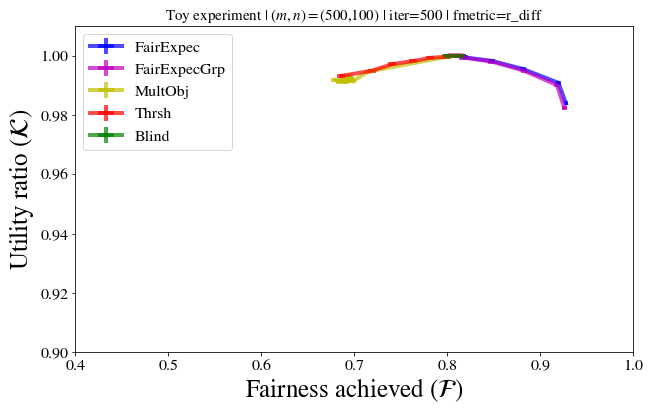

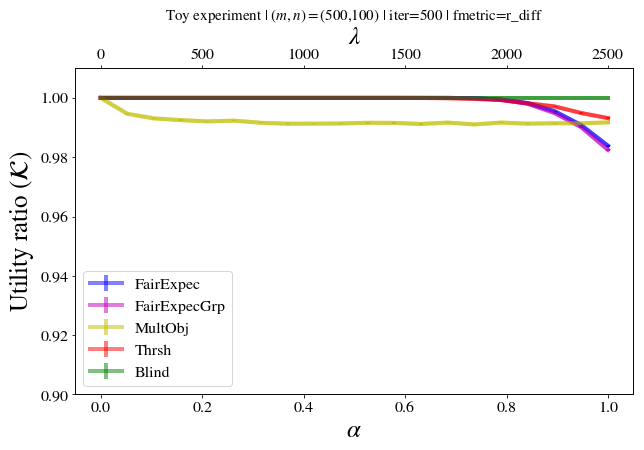

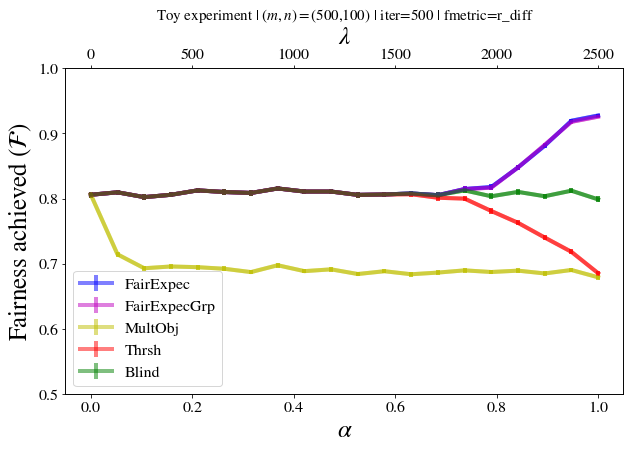

In [54]:
# Generate Figure 1 and Figure 10 (Risk difference)
experiment_toy(iter=500, m=500, n=100, bias_value_multiplier=1, lam=[0,0,0,0,2500.0],\
           verbose=0, save=1, target='equal', fair_metric='r_diff')

alpha:  0.0
[500, 500, 500, 500, 500] [500, 500, 500, 500, 500]
------------------------- alpha=0.0 -------------------------
alpha:  0.05263157894736842
[500, 500, 500, 500, 500] [500, 500, 500, 500, 500]
------------------------- alpha=0.05263157894736842 -------------------------
alpha:  0.10526315789473684
[500, 500, 500, 500, 500] [500, 500, 500, 500, 500]
------------------------- alpha=0.10526315789473684 -------------------------
alpha:  0.15789473684210525
[500, 500, 500, 500, 500] [500, 500, 500, 500, 500]
------------------------- alpha=0.15789473684210525 -------------------------
alpha:  0.21052631578947367
[500, 500, 500, 500, 500] [500, 500, 500, 500, 500]
------------------------- alpha=0.21052631578947367 -------------------------
alpha:  0.2631578947368421
[500, 500, 500, 500, 500] [500, 500, 500, 500, 500]
------------------------- alpha=0.2631578947368421 -------------------------
alpha:  0.3157894736842105
[500, 500, 500, 500, 500] [500, 500, 500, 500, 500]
-------

time taken:  2331.427759170532


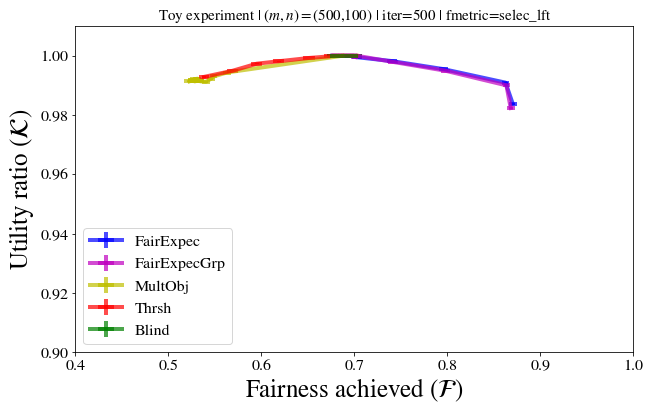

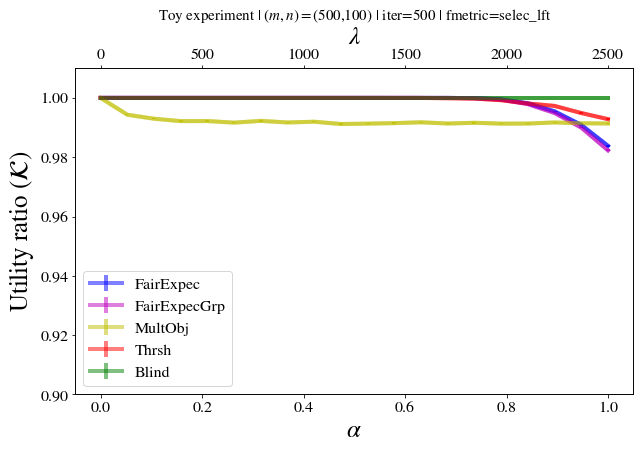

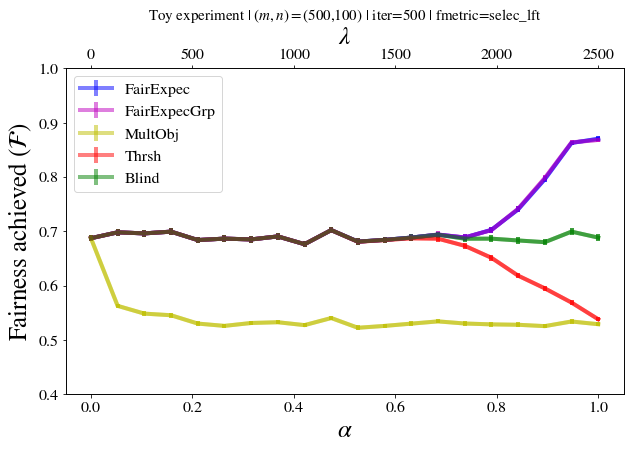

In [55]:
# Generate Figure 11 (Selection lift)
experiment_toy(iter=500, m=500, n=100, bias_value_multiplier=1, lam=[0,0,0,0,2500.0],\
           verbose=0, save=1, target='equal', fair_metric='selec_lft')

### Plot for different n/m

n:  50
[100, 100, 100, 100, 100] [100, 100, 100, 100, 100]
------------------------- n=50 -------------------------
n:  100
[100, 100, 100, 100, 100] [100, 100, 100, 100, 100]
------------------------- n=100 -------------------------
n:  150
[100, 100, 100, 100, 100] [100, 100, 100, 100, 100]
------------------------- n=150 -------------------------
n:  200
[100, 100, 100, 100, 100] [100, 100, 100, 100, 100]
------------------------- n=200 -------------------------
n:  250
[100, 100, 100, 100, 100] [100, 100, 100, 100, 100]
------------------------- n=250 -------------------------
n:  300
[100, 100, 100, 100, 100] [100, 100, 100, 100, 100]
------------------------- n=300 -------------------------
n:  350
[100, 100, 100, 100, 100] [100, 100, 100, 100, 100]
------------------------- n=350 -------------------------
FairExpec  (fairness):  [0.9024, 0.9194, 0.9398666666666666, 0.9512999999999997, 0.95592, 0.9588666666666668, 0.9631999999999998]
FairExpec  (std):  [0.08566352782835879, 0.055

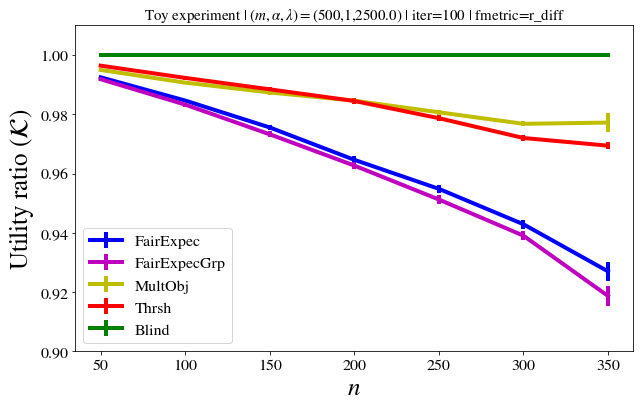

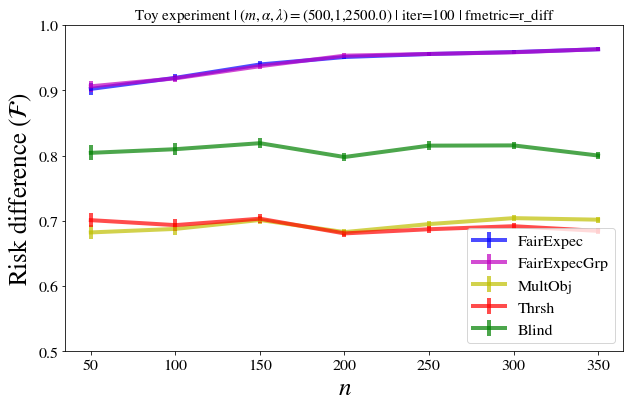

In [103]:
# Generate Figure 9 (Risk difference)
plot_for_diff_n_toy(iter=100, m=500, n=100, bias_value_multiplier=1, lam=[0,0,0,0,2500.0],\
           verbose=0, save=1, target='equal', fair_metric='r_diff')

---

---


# 3. Real-world data for candidate selection (Section 4.4)

In [157]:
## Constants
race = {'white': 0, 'black': 1, 'asian': 2, 'hispanic': 3}
inv_race = {0 : 'white', 1 : 'black', 2 : 'asian', 3 : 'hispanic'}

## Helper functions

In [158]:
def reac_and_clean_census(file):
    cs2010 = {}
    nm = [] #names
    cnt_nm = []
    with open(file) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        lcnt=0
        for row in csv_reader:
            if lcnt==0: lcnt+=1; continue;
            if row[0]=="ALL OTHER NAMES": continue;
            # 5: white, 6: black, 7: Asian and Native Hawaiian and Other \
            # Pacific Islander Alone, 8:American Indian and Alaska Native Alone, 10: hispanic
            for i in [5,6,7,10]:
                if row[i]=="(S)": row[i]=0;
            tmp = [float(row[5]), float(row[6]), float(row[7]), float(row[10])]
            if np.sum(tmp) < 1e-5: continue
            cs2010[row[0]] = np.array(tmp)
            cs2010[row[0]] = cs2010[row[0]]/np.sum(cs2010[row[0]])
            nm.append(row[0])
            cnt_nm.append(float(row[2]))
    return cs2010, np.array(nm), np.array(cnt_nm)

file = home_folder+'census_2010.csv'
cs2010, nm, cnt_nm = reac_and_clean_census(file)
cnt_nm = np.array(cnt_nm)
cnt_nm_norm = cnt_nm/np.sum(cnt_nm)

## Calculating the composition of the ground population
sum = [0 for i in range(4)]
for i in range(len(nm)): sum+=cs2010[nm[i]]*cnt_nm[i]
    

sum=np.array(sum)
print("Composition of population in terms of race:", sum/np.sum(sum))

nm_by_race = [[] for i in range(4)]; cnt_nm_by_race = [[] for i in range(4)]
for i in range(len(nm)):
    k = np.argmax(cs2010[nm[i]])
    nm_by_race[k].append(nm[i])
    cnt_nm_by_race[k].append(cnt_nm[i])

Composition of population in terms of race: [0.65812974 0.1276957  0.04677185 0.16740271]


In [55]:
def gen_candidates(m,white_black_only=0,rand_gen=None):
    assert(not white_black_only)
    global cs2010; global nm; global cnt_nm_norm;
    rng = get_rng(rand_gen)
    #
    cnd_nm = rng.choice(nm, m, p=cnt_nm_norm)
    q = np.array([cs2010[cnd_nm[i]] for i in range(m)])
    #
    inv_race = {0 : 'white', 1 : 'black', 2 : 'asian', 3 : 'hispanic'}
    x = [[cnd_nm[i], rng.choice(list(inv_race.keys()), 1, p=q[i])[0] ] for i in range(m)]
    return x, q

def gen_candidates_custom_population(siz, white_black_only=0,rand_gen=None):
    global cs2010; global nm_by_race; global cnt_nm_by_race;
    rng = get_rng(rand_gen)
    inv_race = {0 : 'white', 1 : 'black', 2 : 'asian', 3 : 'hispanic'}
    #
    p=len(siz);
    cnd_nm = []
    for l in range(p): cnd_nm.extend(rng.choice(nm_by_race[l], siz[l], p=np.array(cnt_nm_by_race[l])/np.sum(cnt_nm_by_race[l])))
    q = np.array([cs2010[c] for c in cnd_nm])
    #
    ind = [i for i in range(len(cnd_nm))]; rng.shuffle(ind);
    cnd_nm = np.array(cnd_nm); q = np.array(q)
    cnd_nm = cnd_nm[ind]; q = q[ind]
    #
    # round down to white vs black
    if white_black_only:
        for i in range(len(q)):
            q[i][2]=0; q[i][3]=0;
            if np.sum(q[i])==0: q[i] = [rng.uniform(0,1),0,0,0]; q[i][1]=1-q[i][0]
            q[i]=q[i]/np.sum(q[i]);
    # x[i]: ["last_name", "race"]
    x = [[cnd_nm[i], rng.choice(list(inv_race.keys()), 1, p=q[i])[0] ] for i in range(len(q))]
    return x, q

def get_white_alone_new(white_alone_old,income_groups,multiplier):
    a=np.array(income_groups)
    b=[np.argmin([np.abs(aa*multiplier-k-1) for k in income_groups]) for aa in a]
    white_alone = np.zeros_like(a)
    for i in range(len(a)): white_alone[b[i]] += white_alone_old[i]
    return white_alone

def gen_utility(x,sample_from_unif=0,multiplier=1,rand_gen=None):
    rng = get_rng(rand_gen)
    global cs2010; global nm; global cnt_nm;
    def sample_utility_race_batch(r,size=1):
        # derived from: https://www.census.gov/data/tables/time-series/demo/income-poverty/cps-finc/finc-02.html
        income_groups = [2500, 7500, 12500, 17500, 22500, 27500, 32500, 37500, 42500, 47500, 52500, 57500, 62500, 67500, 72500, 77500, 82500, 87500, 92500, 97500, 102500, 107500, 112500, 117500, 122500, 127500, 132500, 137500, 142500, 147500, 152500, 157500, 162500, 167500, 172500, 177500, 182500, 187500, 192500, 197500, 250000]
        white_alone_old = [1306, 806, 1153, 1376, 2038, 2176, 2402, 2559, 2295, 2346, 2536, 2317, 2372, 2191, 2074, 2230, 1967, 1868, 1937, 1686, 1791, 1552, 1521, 1313, 1273, 1209, 1089, 939, 932, 918, 995, 671, 780, 655, 620, 575, 544, 496, 408, 423, 7792]
        black_alone = [431, 326, 463, 437, 462, 509, 608, 463, 486, 375, 446, 388, 363, 288, 288, 319, 263, 190, 198, 168, 202, 171, 175, 122, 129, 100, 116, 73, 85, 95, 113, 62, 64, 76, 44, 76, 31, 40, 38, 30, 459]
        asian_alone = [106, 42, 99, 101, 148, 148, 147, 129, 163, 104, 165, 130, 140, 100, 130, 136, 138, 149, 100, 110, 162, 125, 99, 105, 109, 91, 117, 80, 82, 59, 105, 67, 74, 48, 59, 49, 37, 57, 47, 45, 996]
        hispanic = [448, 267, 374, 555, 765, 734, 735, 783, 652, 639, 676, 530, 555, 418, 438, 508, 388, 276, 316, 303, 223, 206, 181, 193, 183, 144, 153, 108, 129, 108, 101, 84, 94, 81, 64, 63, 44, 53, 38, 25, 644]
        #
        white_alone = get_white_alone_new(white_alone_old,income_groups,multiplier=multiplier)
        #
        income_groups=np.array(income_groups); white_alone=np.array(white_alone); black_alone=np.array(black_alone); asian_alone=np.array(asian_alone); hispanic=np.array(hispanic)
        data = [ i/np.sum(i) for i in [white_alone, black_alone, asian_alone, hispanic]]
        # Sample utility from the census data
        if sample_from_unif: 
            c=1+(multiplier-1)*(r==0);
            return c*rng.uniform(0,1,size)
        else: return rng.choice(income_groups, size, p=data[r])+rng.uniform(0,1,size)-2
    m = len(x);
    ## speed up by drawing samples for the same race together.
    w = []
    races = [i for i in range(4)]
    cnt = [0]*len(races)
    util_race = [sample_utility_race_batch(r, size=m+10) for r in races]
    for i in range(m): 
        r=x[i][1]; 
        assert(r<len(races))
        w.append(util_race[r][cnt[r]]); 
        cnt[r]+=1
    return w

def gen_candidate_calibrate_with_util(m, siz, custom_size=0,bias_value_multiplier=1, rand_gen=None):
    inv_race = {0 : 'white', 1 : 'black', 2 : 'asian', 3 : 'hispanic'}
    rng = get_rng(rand_gen)
    global cs2010; global nm; global cnt_nm;
    if not custom_size:
        cnd_nm = rng.choice(nm, m, p=np.array(cnt_nm)/np.sum(cnt_nm))
        q_tmp = np.array([cs2010[cnd_nm[i]] for i in range(m)])
    else:
        p=len(siz);
        cnd_nm = []
        for l in range(p): cnd_nm.extend(rng.choice(nm_by_race[l], siz[l], p=np.array(cnt_nm_by_race[l])/np.sum(cnt_nm_by_race[l])))
        q_tmp = np.array([cs2010[c] for c in cnd_nm])
        #
        ind = [i for i in range(len(cnd_nm))]; rng.shuffle(ind);
        cnd_nm = np.array(cnd_nm); q_tmp = np.array(q_tmp)
        cnd_nm = cnd_nm[ind]; q_tmp = q_tmp[ind]
        #
    x = [[cnd_nm[i], rng.choice(list(inv_race.keys()), 1, p=q_tmp[i])[0] ] for i in range(m)]
    w = gen_utility(x,sample_from_unif=0,multiplier=bias_value_multiplier)
    #
    p=4
    income_groups = [0,2500, 7500, 12500, 17500, 22500, 27500, 32500, 37500, 42500, 47500, 52500, 57500, 62500, 67500, 72500, 77500, 82500, 87500, 92500, 97500, 102500, 107500, 112500, 117500, 122500, 127500, 132500, 137500, 142500, 147500, 152500, 157500, 162500, 167500, 172500, 177500, 182500, 187500, 192500, 197500, 250000]
    white_alone_old = [1,1306, 806, 1153, 1376, 2038, 2176, 2402, 2559, 2295, 2346, 2536, 2317, 2372, 2191, 2074, 2230, 1967, 1868, 1937, 1686, 1791, 1552, 1521, 1313, 1273, 1209, 1089, 939, 932, 918, 995, 671, 780, 655, 620, 575, 544, 496, 408, 423, 7792]
    black_alone = [0,431, 326, 463, 437, 462, 509, 608, 463, 486, 375, 446, 388, 363, 288, 288, 319, 263, 190, 198, 168, 202, 171, 175, 122, 129, 100, 116, 73, 85, 95, 113, 62, 64, 76, 44, 76, 31, 40, 38, 30, 459]
    asian_alone = [0,106, 42, 99, 101, 148, 148, 147, 129, 163, 104, 165, 130, 140, 100, 130, 136, 138, 149, 100, 110, 162, 125, 99, 105, 109, 91, 117, 80, 82, 59, 105, 67, 74, 48, 59, 49, 37, 57, 47, 45, 996]
    hispanic = [0,448, 267, 374, 555, 765, 734, 735, 783, 652, 639, 676, 530, 555, 418, 438, 508, 388, 276, 316, 303, 223, 206, 181, 193, 183, 144, 153, 108, 129, 108, 101, 84, 94, 81, 64, 63, 44, 53, 38, 25, 644]
    # calculating white_alone
    white_alone = get_white_alone_new(white_alone_old,income_groups,multiplier=bias_value_multiplier)
    #
    data = [ i/np.sum(i) for i in [white_alone, black_alone, asian_alone, hispanic]]
    #
    q=np.zeros_like(q_tmp)
    for i in range(m):
        ind = np.argmin([np.abs(w[i]-k)  for k in income_groups]) ## doesnt work if noise `gen_utility` is ≥ 2500!
        for l in range(p): q[i][l] =  q_tmp[i][l]*data[l][ind]/np.sum([q_tmp[i][l]*data[l][ind] for l in range(p)])
    return x, w, q

#### Getting group flip probabilities

In [58]:
# Stored values:
# Qgrp=np.array([[0.82891355, 0.13426209, 0.00837239, 0.02845197],
#        [0.31660366, 0.6441989 , 0.01145682, 0.02774062],
#        [0.07880176, 0.02704637, 0.86853654, 0.02561534],
#        [0.06975409, 0.00667832, 0.02165772, 0.90190987]])
# t_proportion = np.array([0.658212, 0.126862, 0.046672, 0.168254])

# Calculate Qgrp
p = 4
m=500000 # large value
Qgrp = np.zeros((4,4))

# sample
cnd, q = gen_candidates(m)
w = gen_utility(cnd,sample_from_unif=0,multiplier=1)

# calculate 
t_proportion = [np.sum([cnd[i][1]==j for i in range(m)])/m for j in range(4)]

tmp = range(p)
for i, j in itertools.product(range(p), tmp):
    tot = np.sum( [i == np.argmax(q[t]) for t in range(m)])
    typ_t = np.sum( [(j == cnd[t][1])*(i == np.argmax(q[t])) for t in range(m)])
    Qgrp[i][j] = typ_t/tot

In [60]:
eval(debug("Qgrp")) 
eval(debug("t_proportion"))

Qgrp = [[0.82831705 0.13491695 0.00837663 0.02838937]
 [0.32096922 0.63654111 0.01223013 0.03025953]
 [0.07580714 0.025032   0.87118949 0.02797136]
 [0.06963199 0.00611268 0.0208182  0.90343713]]
t_proportion = [0.657762, 0.127188, 0.046896, 0.168154]


## Simulation code

In [141]:
def subset_selection_parallel(alpha, iter=100, m=1000, n=50, custom_size=0, size=[0],\
                     bias_value_multiplier=1, calibrate_with_util=0,\
                     store_max=1, verbose=0, lam=1, fair_metric='r_diff', target='equal'):
    # fair_metric: 
    #       'r_diff' risk difference, 
    #       'select_lft' selection lift, 
    #       'custom' what alpha does the result satisfy with target as proportional representation.
    # 
    # target: 'proportional' representation or equal representation.
    #
    # We compare the number of women selected by the thresholding and the fair in expectation scheme.
    # For each iteration, we sample the predictions of the classifier (from rothe et al. 2017) from the distributions fitted earlier.
    # We use the following parameters: (m,n,p)
    assert(target == 'equal' or target == 'proportional')
    p = 4 # four races
    
    if custom_size: m=np.sum(size) # if m < 20 * (4*n/5): raise Exception("m too small for the census dataset! We won't have at least n candidates from each race.")
    
    # algos = [fair_select_lp, thresh_select, blind_select, fair_select_lp, lagrangian_solver]
    # algo_names = ["fair", "thresh", "blind", "fairGroup", "lag2"]
    
    algos = [fair_select_lp, fair_select_lp, lagrangian_solver, thresh_select, blind_select]
    algo_res = [[] for a in algos]
    algo_val = [[] for a in algos]
    algo_names = ["fair", "fairExpecGrp", "lag2", "thresh", "blind"]
    
    # we run several jobs in parallel to speed up the experiment
    def select_job(iter, seed, alpha, m, n, custom_size,size,\
                   bias_value_multiplier, calibrate_with_util, store_max,verbose,\
                   lam, p):
        ## set new random seed to ensure each thread is independent with HP
        rng_loc = random_numpy.default_rng(seed) 
        cnd=0; q=0; w=0;
        
        algos = [fair_select_lp, fair_select_lp, lagrangian_solver, thresh_select, blind_select]
        algo_names = ["fair", "fairExpecGrp", "lag2", "thresh", "blind"]
        
        fair_res_job  = []; thresh_res_job = []; blind_res_job  = []; lag_res_job = []; lag_res2_job = [];\
        fair_val_job  = []; thresh_val_job = []; blind_val_job  = []; lag_val_job = []; lag_val2_job = []
        algo_res_job = [fair_res_job, thresh_res_job, blind_res_job, lag_res_job, lag_res2_job]
        algo_val_job = [fair_val_job, thresh_val_job, blind_val_job, lag_val_job, lag_val2_job]
        
        i=0
        while i < iter: 
            print("iter: ", i, end=", ")
            # Generate candidates
            if calibrate_with_util: 
                if not custom_size: cnd,w,q = gen_candidate_calibrate_with_util(m,siz=[0],rand_gen=rng_loc)
                else: cnd,w,q = gen_candidate_calibrate_with_util(m=m,siz=size,\
                                    custom_size=custom_size,bias_value_multiplier=bias_value_multiplier,\
                                    rand_gen=rng_loc)
            else:
                if not custom_size: cnd, q = gen_candidates(m, rand_gen=rng_loc); 
                else: cnd, q = gen_candidates_custom_population(size, rand_gen=rng_loc)
                w = gen_utility(cnd,sample_from_unif=0,multiplier=bias_value_multiplier,\
                                rand_gen=rng_loc); 
            qgrp = np.array([Qgrp[np.argmax(x)] for x in q])
               
            ave_w = np.mean(w)
            
            if target == 'equal': t = np.array([1.0/p]*p)
            elif target == 'proportional': t = np.array(t_proportion)
            
            u = np.array([n*t[s]+n*(1-t[s])*(1-alpha) for s in range(p)]) ## male, female
            t = np.reshape(t, (p,1)); w = np.reshape(w, (m,1)); q = np.reshape(q, (m,p)); u = np.reshape(u, (p,1))  ## male, female
            
            #eval(debug("t"))
            def aggregate_stats(x,store_val=False,store_max=False,name=""):
                race_ind = [[(c[1]==l) for c in cnd] for l in range(p)]
                num_picked = [np.dot(race_ind[l],x)   for l in range(p)]
                val = np.sum([x[i]*w[i] for i in range(m)]) / np.sum(x) * n
                # eval(debug("num_picked")); #debug("val")
                if verbose: print(name,": ", num_picked)
                # print(name,": ", np.sum(x), flush=True)
                
                if store_val: return val
                elif store_max: return np.max(num_picked)
                elif fair_metric == 'selec_lft': 
                    mi = 2
                    for i,j in itertools.product(range(p),range(p)): 
                        mi = min(mi, num_picked[i]*t[j]/t[i]/num_picked[j] if num_picked[j] else 0.0)
                    return mi
                elif fair_metric == 'r_diff':
                    mx = -1
                    min_t = min(t)
                    for i,j in itertools.product(range(p),range(p)): 
                        mx = max(mx, min_t * abs(num_picked[i]*1.0/n/t[i]-num_picked[j]*1.0/n/t[j]))
                    return 1 - mx
                elif fair_metric == 'custom':
                    mi = 2
                    for i,j in itertools.product(range(p),range(p)): 
                        mi = min(mi, p/(p-1.0) * (1 - num_picked[i]/n))
                    return mi
                else: print("Must choose a fairness definition!"); raise NotImplementedError
            # Run algorithms
            fg=0
            for j, algo in enumerate(algos):
                if verbose: print('trying'+algo_names[j], end=" ")
                try:
                    if algo_names[j] == "lag2": x=algo(w,q,t,n,lam=lam[4]*ave_w, eps=1e-2)
                    elif algo_names[j] == "fairExpecGrp": 
                        # val(debug("n,p,t"))
                        # eval(debug("alpha"))
                        # eval(debug("np.min(alpha,0.97)"))
                        uu = np.array([n*t[s]+n*(1-t[s])*(1-np.minimum(alpha,0.97)) for s in range(p)]) ## male, female
                        uu = np.reshape(uu, (p,1))  ## male, female
                        # eval(debug("u"))
                        # eval(debug("uu"))
                        x=algo(w, qgrp, uu, n, lam=lam[j]*ave_w, eps=1e-2)
                    else: x=algo(w,q,u,n,lam=lam[j]*ave_w, eps=1e-2) 
                        
                    # print(algo_names[j], ': ', np.sum(x), np.sum([x[i]*w[i] for i in range(m)]));
                    
                    if type(x)!=type(-1): x=list(x)
                    else: fg=1; print(algo_names[j]+" returned invalid solution\n");
                    if not fg and np.sum(x) > n*3/2: fg=1; print(algo_names[j]+" returned invalid solution2\n");
                except Exception as exc:
                    fg=1; print(exc); print(algo_names[j]+'looping due to timeout');
                if fg: #breaking
                    for k in range(j): algo_res[k]=algo_res[k][:-1]; algo_val[k]=algo_val[k][:-1];
                    break
                if verbose: print(algo_names[j],": ",np.sum(x), end= " | ")
                algo_res_job[j].append(aggregate_stats(x,store_max=store_max, name=algo_names[j]))
                algo_val_job[j].append(aggregate_stats(x,store_val=True, name=algo_names[j]))
            if fg: continue
            i+=1
        return (algo_res_job, algo_val_job)     
    #
    ## Ensure proper parallel randomization
    proc = CORES
    ss = rng.bit_generator._seed_seq ## seed sequence (source: https://albertcthomas.github.io/good-practices-random-number-generators/)
    child_states = ss.spawn(proc) ## child sequences 
    #
    child_args = []
    answer = Parallel(n_jobs=proc, prefer="threads")(delayed(select_job)(int(iter/proc), child_states[i], \
                                               alpha, m, n, custom_size, size, bias_value_multiplier, \
                                               calibrate_with_util, store_max, verbose, \
                                               copy.deepcopy(lam), p) for i in range(proc))
    #
    ## Store answers computed
    for i in range(proc):
        res_job, val_job = answer[i]
        for j in range(len(res_job)): algo_res[j].extend(res_job[j])
        for j in range(len(val_job)): algo_val[j].extend(val_job[j])
        for j in range(len(val_job)): algo_res[j] = algo_res[j][:iter]
        for j in range(len(val_job)): algo_val[j] = algo_val[j][:iter]
    
    # Output
    out = []
    print([len(res) for res in algo_res], [len(val) for val in algo_val])
    
    algo_val[4]=np.array(algo_val[4]); # blind
    
    for i in range(len(algo_names)): print(algo_names[i], ": ", np.mean(algo_res[i]))
    for v in algo_res: out.append([np.mean(v), np.std(v)])
    
    for i, v in enumerate(algo_val):
        if i == 4: out.append([1,0]); continue
        v=np.array(v);
        v=v/algo_val[4]; 
        out.append([np.mean(v), np.std(v)])
    return out[0], out[1], out[2], out[3], out[4], out[5], out[6], out[7], out[8], out[9]

In [142]:
debug = lambda str: f"print(\"{str}\",\"=\",eval(\"{str}\"))"
def experiment(iter=100, m=1000, n=50, peff=4, custom_size=0, custom_size_arg=0.5, \
               bias_value_multiplier=1, calibrate_with_util=0, store_max=1, lam=[0,0,0,1.0,5.0],\
               fair_metric='r_diff', verbose=0, save=1, target='equal'):
    # Initialize
    p = 4 #peff is p effective
    range_alpha=np.linspace(0,1,5)
    if peff==4:
        range_alpha=np.array([0.,  0.07894737, 0.15789474, 0.23684211,\
                              0.27631579, 0.31578947, 0.35526316, 0.39473684,\
                              0.43421053, 0.47368421, 0.51315789, 0.55263158,\
                              0.59210526, 0.63157895, 0.67105263, 0.71052632,\
                              0.72,0.73,0.74, 0.75])
        range_alpha=range_alpha*p/(p-1.0)
    range_lam=np.array([0,10,50,100,150,200,250,300,350,400,450,500,550,600,700,800,1000,1200,1400,1500])/1500.0#np.array(list(np.logspace(0,3,15))+list(np.linspace(1000,1500,5)))/1500 #np.linspace(0,1,20)
    
    #For faster experiment (temporary)
    # range_alpha=np.array([0.,0.2,0.4,0.6,0.8,0.9, 1])
    # range_lam=np.array([0,250,400,700,900,1200,1500])/1500.0#np.array(list(np.logspace(0,3,15))+list(np.linspace(1000,1500,5)))/1500 #np.linspace(0,1,20)
    
    range_lam=np.array(range_lam);
    # range_lam=np.linspace(0,1,7)
    range_alpha=np.array(range_alpha);
    lam = np.array(lam)
    fair_res={'mean':[], 'std':[]}; thresh_res={'mean':[], 'std':[]}; blind_res={'mean':[], 'std':[]}; fairGrp_res={'mean':[], 'std':[]}; lag_res={'mean':[], 'std':[]}
    fair_val={'mean':[], 'std':[]}; thresh_val={'mean':[], 'std':[]}; blind_val={'mean':[], 'std':[]}; fairGrp_val={'mean':[], 'std':[]}; lag_val={'mean':[], 'std':[]}
    func = [fair_res, fairGrp_res, lag_res, thresh_res, blind_res,\
            fair_val, fairGrp_val, lag_val, thresh_val, blind_val]
    #
    size=[0]*p
    if custom_size: size=[int(np.ceil(m*custom_size_arg)), int(np.ceil(m*(1-custom_size_arg))), 0, 0]
    # Run experiment
    for i, alpha in enumerate(range_alpha):
        st = time.time()
        temp = subset_selection_parallel(alpha, iter=iter, m=m, n=n, custom_size=custom_size, \
                                size=size, bias_value_multiplier=bias_value_multiplier,\
                                calibrate_with_util=calibrate_with_util, target=target,\
                                store_max=store_max, verbose=verbose,lam=range_lam[i]*lam,fair_metric=fair_metric)
        print("time take/val: ", time.time()-st)
        tmp = [[] for i in range(10)]
        tmp[0],tmp[1],tmp[2],tmp[3],tmp[4],tmp[5],tmp[6],tmp[7],tmp[8],tmp[9] = temp
        # Store results
        print("-"*25, f"alpha={alpha}", "-"*25)
        for xyz in range(10):  
            func[xyz]['mean'].append(tmp[xyz][0])
            func[xyz]['std'].append(tmp[xyz][1])
    ##
    def get_fairness(output):
        raise NotImplementedError
        # out <= n*(1-a) and out >= n-n*(1-a) = na
        output = np.array(output)
        if verbose: eval(debug("output")); eval(debug("1-(output/n)"))
        #
        if peff != 2: return (1-(output/n)) * peff/(peff-1)
        return np.minimum(1-(output/n),output/n) * peff/(peff-1)
    #
    algo_res = [fair_res, fairGrp_res, lag_res, thresh_res, blind_res]
    algo_val = [fair_val, fairGrp_val, lag_val, thresh_val, blind_val]
    algo_name = ['FairExpec', 'FairExpecGrp', 'MultObj', 'Thrsh', 'Blind']
    algo_col = ['b','m','y','r','g']
    
    # algo_name = ['FairExpec', 'Thrsh', f'FairExpecGrp', f'MultObj', 'Blind']
    # algo_col = ['b','r','m','y','g']
    #
    def plot(store_val=False, store_max=False, plot_true_fair=False,\
             res_lambda=False, plot_fair_alpha=False, plot_fair_lambda=False):
        assert(store_val + store_max + plot_true_fair <= 1)
        x=range_alpha
        fig, ax = plt.subplots()
        
        ax2 = -1
        
        if plot_fair_alpha or store_val:
            ax2 = ax.twiny()
            ax2.set_xlabel('$\\lambda$',fontsize=25)
        
        ## Plot: value vs fairness 
        if plot_true_fair:
            for j in range(5):
                res = algo_res[j]
                val = algo_val[j];
                # for j,(res,val) in enumerate(zip(algo_res[:-1],algo_val[:-1])):
                xaxis=res['mean'] ## get fairness of the result
                print(algo_name[j], " (fairness): ", xaxis)
                print(algo_name[j], " (val): ", val['mean'])
                ## sort to make the line plot clean
                tmpvalmean = [x for _,x in sorted(zip(xaxis,val['mean']))]
                tmpvalstd = [x for _,x in sorted(zip(xaxis,val['std']))]
                xaxis = sorted(xaxis)
                # plot
                plt.errorbar(xaxis, tmpvalmean, yerr=tmpvalstd/np.sqrt(iter), xerr=res['std']/np.sqrt(iter), color=algo_col[j], label=algo_name[j], linewidth=4, alpha=0.7)
        ## Plot: fairness vs alpha
        elif plot_fair_alpha:
            for j, res in enumerate(algo_res):
                # if j == 2 or j == 2: continue # do not plot lagrangian_fair vs alpha
                # yaxis=np.array(res['mean']) ## get fairness of the result
                # mask = x<=0.97
                # plt.errorbar(x[mask], yaxis[mask], np.array(res['std'])[mask]/np.sqrt(iter), color=algo_col[j], label=algo_name[j], linewidth=4)
                if j != 1: 
                    ax.errorbar(x, res['mean'], res['std']/np.sqrt(iter), color=algo_col[j], label=algo_name[j], linewidth=4, alpha=0.5)
                    ax2.errorbar(x, res['mean'],yerr=res['std']/np.sqrt(iter), color=algo_col[j], label=algo_name[j], linewidth=4, alpha=0.5)
                else: 
                    mask = x<=0.97
                    ax2.errorbar(x[mask], np.array(res['mean'])[mask],yerr=np.array(res['std'])[mask]/np.sqrt(iter), color=algo_col[j], label=algo_name[j], linewidth=4, alpha=0.5)
                    ax.errorbar(x[mask], np.array(res['mean'])[mask],yerr=np.array(res['std'])[mask]/np.sqrt(iter), color=algo_col[j], label=algo_name[j], linewidth=4, alpha=0.5)
        ## Plot: fairness vs lambda
        elif plot_fair_lambda:  
            raise NotImplementedError
            for j, res in enumerate(algo_res):
                if j != 2 and j != 4: continue # do not plot alpha_fair vs lambda
                yaxis=res['mean'] ## get fairness of the result
                plt.errorbar(lam[4]*range_lam, yaxis, res['std']/np.sqrt(iter), color=algo_col[j], label=algo_name[j], linewidth=4)
        ## Plot: value vs alpha
        elif store_val:  
            for j, val in enumerate(algo_val):
                if j != 1: 
                    ax.errorbar(x, val['mean'], val['std']/np.sqrt(iter), color=algo_col[j], label=algo_name[j], linewidth=4, alpha=0.5)
                    ax2.errorbar(x, val['mean'],yerr=val['std']/np.sqrt(iter), color=algo_col[j], label=algo_name[j], linewidth=4, alpha=0.5)
                else: 
                    ax2.errorbar(x, val['mean'],yerr=val['std']/np.sqrt(iter), color=algo_col[j], label=algo_name[j], linewidth=4, alpha=0.5)
                    ax.errorbar(x, val['mean'],yerr=val['std']/np.sqrt(iter), color=algo_col[j], label=algo_name[j], linewidth=4, alpha=0.5)
                # if j == 2 or j == 2: continue # do not plot lagrangian_fair vs alpha
                # plt.errorbar(x, val['mean'], val['std']/np.sqrt(iter), color=algo_col[j], label=algo_name[j], linewidth=4)
        ## Plot: res vs lambda 
        elif res_lambda:
            raise NotImplementedError
            for j in [2,4]:
                res = algo_res[j]
                plt.errorbar(lam[4]*range_lam, res['mean'], res['std']/np.sqrt(iter), color=algo_col[j], label=algo_name[j], linewidth=4)
        ## Plot: res vs alpha 
        else:
            raise NotImplementedError
            for j, res in enumerate(algo_res):
                if j == 2 or j == 3: continue # do not plot lagrangian_fair vs alpha
                plt.errorbar(x, res['mean'], res['std']/np.sqrt(iter), color=algo_col[j], label=algo_name[j], linewidth=4)
        #
        ## plot contraints (upper bound and lower bound)
        if (plot_fair_alpha + plot_fair_lambda + store_val + plot_true_fair + res_lambda) < 1: 
            plt.plot(x,[n*(1-a) for a in x], '--', color='black', label='Const.', linewidth=4)
        if (plot_fair_alpha + store_max + plot_fair_lambda + store_val + plot_true_fair + res_lambda) < 1: 
            plt.plot(x,[n-n*(1-a) for a in x], '--', color='black', label='Const.', linewidth=4)
        if res_lambda: plt.plot(lam[4]*range_lam,[n/p for a in x], '--', color='black', label='Target', linewidth=4)
        
        ## Decorate
        if store_val:
            plt.ylim(0.5,1.0+1e-2)
            plt.ylabel('Utility Ratio ($\\mathcal{K}$)', fontsize=25)
            ax.set_ylabel('Utility ratio ($\\mathcal{K}$)', fontsize=25)
        elif plot_fair_alpha or plot_fair_lambda:
            plt.ylim(0.0,1.0)
            plt.ylabel('Fairness achieved ($\\mathcal{F}$)', fontsize=25)
            ax.set_ylabel('Fairness achieved ($\\mathcal{F}$)', fontsize=25)
        elif plot_true_fair: 
            plt.ylim(0.5,1.0+1e-2)
            plt.xlim(0.0-1e-2,1.0+1e-2) 
            plt.ylabel('Utility Ratio ($\\mathcal{K}$)', fontsize=25)
        elif store_max: 
            raise NotImplementedError
            plt.ylabel('Maximum-candidates from one race', fontsize=25)
        elif res_lambda:
            raise NotImplemented 
            plt.ylim(n/4,3*n/4)
            plt.ylabel('Maximum-candidates from one race', fontsize=25)
        else: plt.ylabel('Num white candidates picked', fontsize=25)
        
        
        if plot_fair_alpha or store_val or store_max: ax.set_xlabel('$\\alpha$',fontsize=25)
        elif plot_fair_lambda or res_lambda: plt.xlabel('$\\lambda$',fontsize=25)
        elif plot_true_fair: 
            plt.xlabel('Fairness achieved ($\\mathcal{F}$)',fontsize=25); 
            if fair_metric == 'r_diff':
                plt.xlim(0.2,1.0)
            elif fair_metric == 'selec_lft':
                plt.xlim(0.0,1.0)
        else: ax.set_xlabel('$\\alpha$',fontsize=25)
            
        if ax2 != -1: 
            ax2.set_xticklabels([round(xx*lam[4]) for i, xx in enumerate(ax.get_xticks())])
        
        legend = plt.legend(loc='best', shadow=False, fontsize=16)    
        plt.tick_params(axis='both', which='major', labelsize=16)
        ax.tick_params(axis='both', which='major', labelsize=16)
        plt.title(f'$(m,n)=$({m},{n}), increase-in-white-value (multiplier)={bias_value_multiplier}, iter={iter},$\\lambda$={lam}\ncustom_size={custom_size}, custom_size_arg={custom_size_arg}, and calibrate_with_util={calibrate_with_util} f-metric={fair_metric} target={target}.', fontsize=15)
        ## Show or save
        if save: pdf_savefig()
        else: plt.show()
    #
    plot(store_val=False, store_max=False, plot_true_fair=True) #Plot: value vs fairness
    plot(store_val=True, store_max=False, plot_true_fair=False) #Plot: value vs alpha 
    # plot(store_val=False, store_max=store_max, plot_true_fair=False) #Plot: res vs alpha
    plot(store_val=False, plot_true_fair=False, res_lambda=False, plot_fair_alpha=True) #Plot: fairness vs alpha
    # plot(store_val=False, plot_true_fair=False, res_lambda=False, plot_fair_lambda=True) #Plot: fairness vs alpha

In [145]:
debug = lambda str: f"print(\"{str}\",\"=\",eval(\"{str}\"))"
def plot_for_diff_n(iter=100, m=1000, n=50, peff=4, custom_size=0, custom_size_arg=0.5, \
               bias_value_multiplier=1, calibrate_with_util=0, store_max=1, lam=[0,0,0,1.0,5.0],\
               fair_metric='r_diff', verbose=0, save=1, target='equal'):
    # Initialize
    p = 4 #peff is p effective
    range_n = np.array([20,30,40,50,60,70,80,90,100]) #,150,200,250,300,350]) 

    lam = np.array(lam)
    fair_res={'mean':[], 'std':[]}; thresh_res={'mean':[], 'std':[]}; blind_res={'mean':[], 'std':[]}; fairGrp_res={'mean':[], 'std':[]}; lag_res={'mean':[], 'std':[]}
    fair_val={'mean':[], 'std':[]}; thresh_val={'mean':[], 'std':[]}; blind_val={'mean':[], 'std':[]}; fairGrp_val={'mean':[], 'std':[]}; lag_val={'mean':[], 'std':[]}
    func = [fair_res, fairGrp_res, lag_res, thresh_res, blind_res,\
            fair_val, fairGrp_val, lag_val, thresh_val, blind_val]
    #
    size=[0]*p
    if custom_size: size=[int(np.ceil(m*custom_size_arg)), int(np.ceil(m*(1-custom_size_arg))), 0, 0]
    # Run experiment
    for i, n in enumerate(range_n):
        st = time.time()
        temp = subset_selection_parallel(1.0, iter=iter, m=m, n=n, custom_size=custom_size, \
                                size=size, bias_value_multiplier=bias_value_multiplier,\
                                calibrate_with_util=calibrate_with_util, target=target,\
                                store_max=store_max, verbose=verbose,lam=1*lam,fair_metric=fair_metric)
        print("time take/val: ", time.time()-st)
        tmp = [[] for i in range(10)]
        tmp[0],tmp[1],tmp[2],tmp[3],tmp[4],tmp[5],tmp[6],tmp[7],tmp[8],tmp[9] = temp
        # Store results
        print("-"*25, f"n={n}", "-"*25)
        for xyz in range(10):  
            func[xyz]['mean'].append(tmp[xyz][0])
            func[xyz]['std'].append(tmp[xyz][1])
    
    def get_fairness(output):
        raise NotImplementedError
        # out <= n*(1-a) and out >= n-n*(1-a) = na
        output = np.array(output)
        if verbose: eval(debug("output")); eval(debug("1-(output/n)"))
        #
        if peff != 2: return (1-(output/n)) * peff/(peff-1)
        return np.minimum(1-(output/n),output/n) * peff/(peff-1)
    
    algo_res = [fair_res, fairGrp_res, lag_res, thresh_res, blind_res]
    algo_val = [fair_val, fairGrp_val, lag_val, thresh_val, blind_val]
    algo_name = ['FairExpec', 'FairExpecGrp', 'MultObj', 'Thrsh', 'Blind']
    algo_col = ['b','m','y','r','g']
    
    def plot(store_val=False, store_max=False, plot_true_fair=False,\
             res_lambda=False, plot_fair_alpha=False, plot_fair_lambda=False):
        assert(store_val + store_max + plot_true_fair <= 1)
        x=range_n
        fig, ax = plt.subplots()
        ## Plot: value vs fairness 
        if plot_true_fair:
            for j in range(5):
                res = algo_res[j]
                val = algo_val[j];
                # for j,(res,val) in enumerate(zip(algo_res[:-1],algo_val[:-1])):
                xaxis=res['mean'] ## get fairness of the result
                print(algo_name[j], " (fairness): ", xaxis)
                print(algo_name[j], " (val): ", val['mean'])
                ## sort to make the line plot clean
                val['mean'] = [x for _,x in sorted(zip(xaxis,val['mean']))]
                val['std'] = [x for _,x in sorted(zip(xaxis,val['std']))]
                xaxis = sorted(xaxis)
                # plot
                plt.errorbar(xaxis, val['mean'], yerr=val['std']/np.sqrt(iter), xerr=res['std']/np.sqrt(iter), color=algo_col[j], label=algo_name[j], linewidth=4, alpha=0.7)
        ## Plot: fairness vs alpha
        elif plot_fair_alpha:
            for j, res in enumerate(algo_res):
                mask = x>0
                plt.errorbar(x[mask], np.array(res['mean'])[mask], np.array(res['std'])[mask]/np.sqrt(iter), color=algo_col[j], label=algo_name[j], linewidth=4)
        ## Plot: fairness vs lambda
        elif plot_fair_lambda:       
            for j, res in enumerate(algo_res):
                if j != 2 and j != 4: continue # do not plot alpha_fair vs lambda
                yaxis=res['mean'] ## get fairness of the result
                plt.errorbar(lam[4]*range_lam, yaxis, res['std']/np.sqrt(iter), color=algo_col[j], label=algo_name[j], linewidth=4)
        ## Plot: value vs alpha
        elif store_val:  
            for j, val in enumerate(algo_val):
                mask = x>0
                plt.errorbar(x[mask], np.array(val['mean'])[mask], np.array(val['std'])[mask]/np.sqrt(iter), color=algo_col[j], label=algo_name[j], linewidth=4)
        ## Plot: res vs lambda 
        elif res_lambda:
            raise NotImplementedError
            for j in [2,4]:
                res = algo_res[j]
                plt.errorbar(lam[4]*range_lam, res['mean'], res['std']/np.sqrt(iter), color=algo_col[j], label=algo_name[j], linewidth=4)
        ## Plot: res vs alpha 
        else:
            raise NotImplementedError
            for j, res in enumerate(algo_res):
                if j == 2 or j == 3: continue # do not plot lagrangian_fair vs alpha
                plt.errorbar(x, res['mean'], res['std']/np.sqrt(iter), color=algo_col[j], label=algo_name[j], linewidth=4)
        #
        ## plot contraints (upper bound and lower bound)
        if (plot_fair_alpha + plot_fair_lambda + store_val + plot_true_fair + res_lambda) < 1: 
            plt.plot(x,[n*(1-a) for a in x], '--', color='black', label='Const.', linewidth=4)
        if (plot_fair_alpha + store_max + plot_fair_lambda + store_val + plot_true_fair + res_lambda) < 1: 
            plt.plot(x,[n-n*(1-a) for a in x], '--', color='black', label='Const.', linewidth=4)
        if res_lambda: plt.plot(lam[4]*range_lam,[n/p for a in x], '--', color='black', label='Target', linewidth=4)
        #
        ## Decorate
        if store_val:
            plt.ylim(0.5,1.0+1e-2)
            plt.ylabel('Utility Ratio ($\\mathcal{K}$)', fontsize=25)
        elif plot_fair_alpha or plot_fair_lambda:
            plt.ylim(0.0,1.0)
            plt.ylabel('Risk difference ($\\mathcal{F}$)', fontsize=25)
        elif plot_true_fair: 
            plt.ylim(0.5,1.0+1e-2)
            plt.xlim(0.0-1e-2,1.0+1e-2) 
            plt.ylabel('Utility Ratio ($\\mathcal{K}$)', fontsize=25)
        elif store_max: 
            raise NotImplementedError
            plt.ylabel('Maximum-candidates from one race', fontsize=25)
        elif res_lambda:
            raise NotImplemented 
            plt.ylim(n/4,3*n/4)
            plt.ylabel('Maximum-candidates from one race', fontsize=25)
        else: plt.ylabel('Num white candidates picked', fontsize=25)
        #
        legend = plt.legend(loc='best', shadow=False, fontsize=25)
        #
        if plot_fair_alpha or store_val or store_max: plt.xlabel('$n$',fontsize=25)
        elif plot_fair_lambda or res_lambda: plt.xlabel('$\\lambda$',fontsize=25)
        elif plot_true_fair: plt.xlabel('Fairness achieved ($\\mathcal{F}$)',fontsize=25); plt.xlim(0.2,1.0)
        else: plt.xlabel('$\\alpha$',fontsize=25)
        plt.tick_params(axis='both', which='major', labelsize=16)
        plt.title(f'$(m,n)=$({m},{n}), increase-in-white-value (multiplier)={bias_value_multiplier}, iter={iter},$\\lambda$={lam}\ncustom_size={custom_size}, custom_size_arg={custom_size_arg}, and calibrate_with_util={calibrate_with_util} f-metric={fair_metric} target={target}.', fontsize=15)
        ## Show or save
        if save: pdf_savefig()
        else: plt.show()
    #
    plot(store_val=True, store_max=False, plot_true_fair=False) #Plot: value vs alpha 
    plot(store_val=False, plot_true_fair=False, res_lambda=False, plot_fair_alpha=True) #Plot: fairness vs alpha

## Experiments

### Experiment 1: Ground population

In [159]:
file = home_folder+'census_2010.csv'
cs2010, nm, cnt_nm = reac_and_clean_census(file)

iter: iter:  0, iter: iter:  0, iter:    0, 0, 0, iter:  1, iter:  1, iter:  1, iter:  1, iter:  1, iter:  2, iter:  2, iter:  2, iter:  2, iter:  2, iter:  3, iter:  3, iter:  3, iter:  3, iter:  3, iter:  4, iter:  4, iter:  4, iter:  4, iter:  4, iter:  5, iter:  5, iter:  5, iter:  5, iter:  5, iter:  6, iter:  6, iter:  6, iter:  6, iter:  6, iter:  7, iter:  7, iter:  7, iter:  7, iter:  7, iter:  8, iter:  8, iter:  8, iter:  8, iter:  8, iter:  9, iter:  9, iter:  10, iter:  9, iter:  9, iter:  9, iter:  10, iter:  11, iter:  10, iter:  10, iter:  10, iter:  12, iter:  11, iter:  11, iter:  11, iter:  11, iter:  13, iter:  12, iter:  12, iter:  12, iter:  12, iter:  14, iter:  13, iter:  15, iter:  13, iter:  13, iter:  13, iter:  14, iter:  16, iter:  14, iter:  14, iter:  14, iter:  15, iter:  15, iter:  15, iter:  17, iter:  16, iter:  15, iter:  16, iter:  16, iter:  18, iter:  17, iter:  16, iter:  17, iter:  17, iter:  19, iter:  18, iter:  17, iter:  18, iter:  18, iter:

iter:  0, iter: iter: iter: iter:  0,   0, 0,  0, iter:  1, iter:  1, iter:  1, iter:  1, iter:  1, iter:  2, iter:  2, iter:  2, iter:  2, iter:  2, iter:  3, iter:  3, iter:  3, iter:  3, iter:  3, iter:  4, iter:  4, iter:  4, iter:  4, iter:  4, iter:  5, iter:  5, iter:  5, iter:  5, iter:  5, iter:  6, iter:  6, iter:  6, iter:  6, iter:  6, iter:  7, iter:  7, iter:  7, iter:  7, iter:  7, iter:  8, iter:  8, iter:  8, iter:  8, iter:  8, iter:  9, iter:  9, iter:  9, iter:  9, iter:  9, iter:  10, iter:  10, iter:  10, iter:  10, iter:  10, iter:  11, iter:  11, iter:  11, iter:  11, iter:  11, iter:  12, iter:  12, iter:  12, iter:  12, iter:  12, iter:  13, iter:  13, iter:  13, iter:  13, iter:  13, iter:  14, iter:  14, iter:  14, iter:  14, iter:  14, iter:  15, iter:  15, iter:  15, iter:  15, iter:  16, iter:  15, iter:  16, iter:  16, iter:  17, iter:  16, iter:  17, iter:  16, iter:  17, iter:  18, iter:  17, iter:  18, iter:  17, iter:  18, iter:  19, iter:  19, iter:

iter:  0, iter: iter: iter: iter:  0,    0, 0, 0, iter:  1, iter:  1, iter:  1, iter:  1, iter:  1, iter:  2, iter:  2, iter:  2, iter:  2, iter:  2, iter:  3, iter:  3, iter:  3, iter:  3, iter:  3, iter:  4, iter:  4, iter:  4, iter:  4, iter:  4, iter:  5, iter:  5, iter:  5, iter:  5, iter:  5, iter:  6, iter:  6, iter:  6, iter:  6, iter:  6, iter:  7, iter:  7, iter:  7, iter:  7, iter:  7, iter:  8, iter:  8, iter:  8, iter:  8, iter:  8, iter:  9, iter:  9, iter:  9, iter:  9, iter:  9, iter:  10, iter:  10, iter:  10, iter:  10, iter:  10, 'NoneType' object is not subscriptable
fairExpecGrplooping due to timeout
iter: iter:  10,  11, 'NoneType' object is not subscriptable
fairExpecGrplooping due to timeout
iter:  10, iter:  11, iter:  11, iter:  11, iter:  12, iter:  11, iter:  12, iter:  12, iter:  12, iter:  13, iter:  12, iter:  13, iter:  13, iter:  13, iter:  14, iter:  13, iter:  14, iter:  14, iter:  14, iter:  15, iter:  14, iter:  15, iter:  15, iter:  15, iter:  16, 

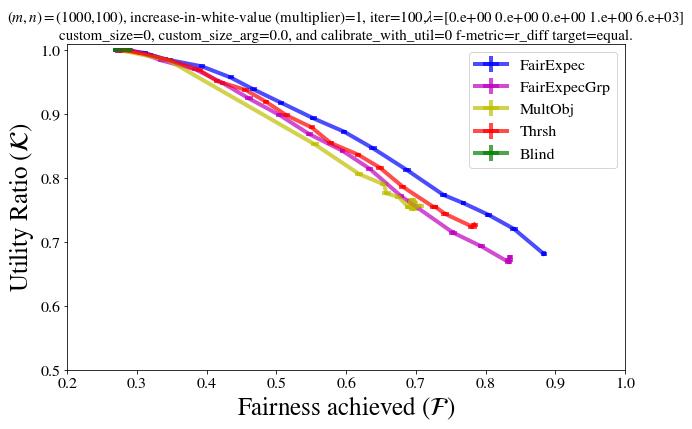

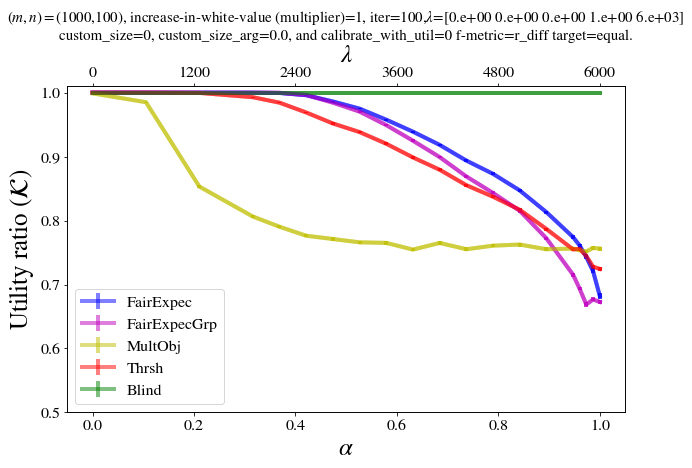

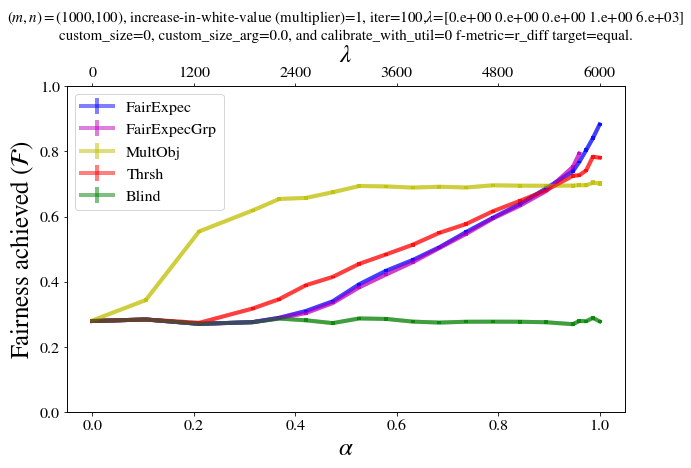

In [48]:
# Generate Figure 3 and Figure 15 (Risk difference)
experiment(iter=100, m=1000, n=100, custom_size=0, custom_size_arg=0.0,\
           bias_value_multiplier=1, store_max=0, lam=[0,0,0,1.0,6000.0],\
           fair_metric='r_diff', verbose=0, save=1)

iter: iter:  0, iter:  iter: iter:  0,  0, 0 0, , fair :  [array([80]), array([1]), array([10]), array([9])]
fair :  [array([78]), array([4]), array([9]), array([9])]
fair :  [array([75]), array([10]), array([7]), array([8])]
fair :  [array([84]), array([4]), array([9]), array([3])]
fair :  [array([84]), array([3]), array([6]), array([7])]
fair :  [array([80]), array([1]), array([10]), array([9])]
fair :  [array([78]), array([4]), array([9]), array([9])]
fair :  [array([75]), array([10]), array([7]), array([8])]
fair :  [array([84]), array([3]), array([6]), array([7])]
fair :  [array([84]), array([4]), array([9]), array([3])]
fairExpecGrp :  [array([80]), array([1]), array([10]), array([9])]
fairExpecGrp :  [array([78]), array([4]), array([9]), array([9])]
fairExpecGrp :  [array([75]), array([10]), array([7]), array([8])]
fairExpecGrp :  [array([84]), array([3]), array([6]), array([7])]
fairExpecGrp :  [array([84]), array([4]), array([9]), array([3])]
fairExpecGrp :  [array([80]), arra

thresh :  [array([68]), array([6]), array([17]), array([9])]
thresh :  [array([75]), array([8]), array([9]), array([8])]
thresh :  [array([68]), array([6]), array([17]), array([9])]
thresh :  [array([75]), array([8]), array([9]), array([8])]
blind :  [array([68]), array([6]), array([17]), array([9])]
blind :  [array([75]), array([8]), array([9]), array([8])]
blind :  [array([68]), array([6]), array([17]), array([9])]
iter:  4, blind :  [array([75]), array([8]), array([9]), array([8])]
iter:  3, fair :  [array([71]), array([10]), array([13]), array([6])]
fair :  [array([71]), array([10]), array([13]), array([6])]
fair :  [array([81]), array([6]), array([5]), array([8])]
fair :  [array([81]), array([6]), array([5]), array([8])]
fairExpecGrp :  [array([71]), array([10]), array([13]), array([6])]
fairExpecGrp :  [array([71]), array([10]), array([13]), array([6])]
fairExpecGrp :  [array([81]), array([6]), array([5]), array([8])]
fairExpecGrp :  [array([81]), array([6]), array([5]), array([8

fairExpecGrp :  [array([78]), array([3]), array([10]), array([9])]
fairExpecGrp :  [array([78]), array([3]), array([10]), array([9])]
lag2 :  [array([74]), array([9]), array([8]), array([9])]
lag2 :  [array([76]), array([9]), array([3]), array([12])]
lag2 :  [array([74]), array([9]), array([8]), array([9])]
lag2 :  [array([76]), array([9]), array([3]), array([12])]
threshthresh  :  [array([73]), array([10]), array([8]), array([9])]
:  [array([76]), array([9]), array([3]), array([12])]
thresh :  [array([73]), array([10]), array([8]), array([9])]
thresh :  [array([76]), array([9]), array([3]), array([12])]
blind :  [array([73]), array([10]), array([8]), array([9])]
blind :  [array([76]), array([9]), array([3]), array([12])]
blindblind :  [array([73]), array([10]), array([8]), array([9])]
iter:  5,  :  [array([76]), array([9]), array([3]), array([12])]
iter:  5, lag2 :  [array([84]), array([3]), array([3]), array([10])]
lag2 :  [array([84]), array([3]), array([3]), array([10])]
fair :  [a

lag2 :  [array([75]), array([8]), array([10]), array([7])]
fairExpecGrp :  [array([74]), array([11]), array([6]), array([9])]
thresh :  [array([76]), array([4]), array([12]), array([8])]
thresh :  [array([76]), array([4]), array([13]), array([7])]
thresh :  [array([74]), array([8]), array([11]), array([7])]
lag2 :  [array([74]), array([11]), array([6]), array([9])]
thresh :  [array([76]), array([4]), array([12]), array([8])]
thresh :  [array([74]), array([8]), array([11]), array([7])]
thresh :  [array([76]), array([4]), array([13]), array([7])]
lag2 :  [array([74]), array([11]), array([6]), array([9])]
blind :  [array([76]), array([4]), array([12]), array([8])]
blind :  [array([74]), array([8]), array([11]), array([7])]
blind :  [array([76]), array([4]), array([13]), array([7])]
thresh :  [array([74]), array([11]), array([6]), array([9])]
blind :  [array([76]), array([4]), array([13]), array([7])]
iter:  9, blindblind :  [array([74]), array([8]), array([11]), array([7])]
iter:  9,  :  

fairExpecGrp :  [array([80]), array([5]), array([8]), array([7])]
fairExpecGrp :  [array([87]), array([3]), array([6]), array([4])]
thresh :  [array([77]), array([6]), array([9]), array([8])]
thresh :  [array([79]), array([3]), array([11]), array([7])]
fairExpecGrp :  [array([80]), array([5]), array([8]), array([7])]
blind :  [array([72]), array([4]), array([9]), array([15])]
blind :  [array([77]), array([6]), array([9]), array([8])]
blind :  [array([79]), array([3]), array([11]), array([7])]
blind :  [array([72]), array([4]), array([9]), array([15])]
iter:  10, blind :  [array([77]), array([6]), array([9]), array([8])]
iter:  10, blind :  [array([79]), array([3]), array([11]), array([7])]
iter:  12, fair :  [array([71]), array([9]), array([8]), array([12])]
fair :  [array([83]), array([4]), array([6]), array([7])]
fair :  [array([71]), array([9]), array([8]), array([12])]
fair :  [array([81]), array([5]), array([9]), array([5])]
fair :  [array([83]), array([4]), array([6]), array([7])

fair :  [array([73]), array([7]), array([11]), array([9])]
blind :  [array([70]), array([4]), array([14]), array([12])]
lag2 :  [array([77]), array([6]), array([5]), array([12])]
lag2 :  [array([75]), array([10]), array([9]), array([6])]
blind :  [array([70]), array([4]), array([14]), array([12])]
iter:  15, fairExpecGrp :  [array([73]), array([7]), array([11]), array([9])]
lag2 :  [array([75]), array([10]), array([9]), array([6])]
lag2 :  [array([77]), array([6]), array([5]), array([12])]
fairExpecGrp :  [array([73]), array([7]), array([11]), array([9])]
fair :  [array([81]), array([7]), array([7]), array([5])]
thresh :  [array([80]), array([6]), array([5]), array([9])]
thresh :  [array([75]), array([10]), array([9]), array([6])]
fair :  [array([81]), array([7]), array([7]), array([5])]
thresh :  [array([80]), array([6]), array([5]), array([9])]
thresh :  [array([75]), array([10]), array([9]), array([6])]
fairExpecGrp :  [array([81]), array([7]), array([7]), array([5])]
blind :  [arra

blind :  [array([75]), array([9]), array([12]), array([4])]
thresh :  [array([83]), array([3]), array([5]), array([9])]
blind :  [array([80]), array([4]), array([8]), array([8])]
iter:  15, thresh :  [array([75]), array([7]), array([8]), array([10])]
thresh :  [array([82]), array([8]), array([4]), array([6])]
thresh :  [array([83]), array([3]), array([5]), array([9])]
blind :  [array([75]), array([9]), array([12]), array([4])]
iter:  15, thresh :  [array([75]), array([7]), array([8]), array([10])]
thresh :  [array([82]), array([8]), array([4]), array([6])]
fair :  [array([82]), array([4]), array([8]), array([6])]
blind :  [array([83]), array([3]), array([5]), array([9])]
blind :  [array([75]), array([7]), array([8]), array([10])]
blind :  [array([82]), array([8]), array([4]), array([6])]
fair :  [array([76]), array([7]), array([11]), array([6])]
fair :  [array([82]), array([4]), array([8]), array([6])]
blind :  [array([83]), array([3]), array([5]), array([9])]
iter:  18, blind :  [arra

thresh :  [array([81]), array([5]), array([7]), array([7])]
thresh :  [array([72]), array([8]), array([11]), array([9])]
fairExpecGrp :  [array([82]), array([3]), array([9]), array([6])]
thresh :  [array([81]), array([5]), array([7]), array([7])]
fairExpecGrp :  [array([82]), array([3]), array([9]), array([6])]
thresh :  [array([72]), array([8]), array([11]), array([9])]
blind :  [array([81]), array([5]), array([7]), array([7])]
blind :  [array([72]), array([8]), array([11]), array([9])]
blind :  [array([81]), array([5]), array([7]), array([7])]
iter:  18, blind :  [array([72]), array([8]), array([11]), array([9])]
iter:  18, fair :  [array([78]), array([9]), array([7]), array([6])]
fair :  [array([79]), array([4]), array([7]), array([10])]
fair :  [array([78]), array([9]), array([7]), array([6])]
fair :  [array([79]), array([4]), array([7]), array([10])]
fairExpecGrp :  [array([78]), array([9]), array([7]), array([6])]
fairExpecGrp :  [array([79]), array([4]), array([7]), array([10])]

/usr/local/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


fair :  [array([76]), array([4]), array([10]), array([10])]
fair :  [array([77]), array([3]), array([10]), array([10])]
fair :  [array([71]), array([10]), array([8]), array([11])]
fair :  [array([76]), array([8]), array([12]), array([4])]
fair :  [array([85]), array([3]), array([8]), array([4])]
fair :  [array([77]), array([3]), array([10]), array([10])]
fair :  [array([76]), array([4]), array([10]), array([10])]
fair :  [array([71]), array([10]), array([8]), array([11])]
fair :  [array([76]), array([8]), array([12]), array([4])]
fair :  [array([85]), array([3]), array([8]), array([4])]
fairExpecGrp :  [array([77]), array([3]), array([10]), array([10])]
fairExpecGrp :  [array([76]), array([4]), array([10]), array([10])]
fairExpecGrp :  [array([71]), array([10]), array([8]), array([11])]
fairExpecGrp :  [array([76]), array([8]), array([12]), array([4])]
fairExpecGrp :  [array([85]), array([3]), array([8]), array([4])]
fairExpecGrp :  [array([77]), array([3]), array([10]), array([10])]
f

lag2 :  [array([72]), array([8]), array([11]), array([9])]
lag2 :  [array([68]), array([11]), array([7]), array([14])]
thresh :  [array([80]), array([9]), array([5]), array([6])]
fairExpecGrp :  [array([76]), array([8]), array([6]), array([10])]
thresh :  [array([75]), array([6]), array([12]), array([7])]
thresh :  [array([72]), array([9]), array([5]), array([14])]
thresh :  [array([80]), array([9]), array([5]), array([6])]
fairExpecGrp :  [array([76]), array([8]), array([6]), array([10])]
thresh :  [array([75]), array([6]), array([12]), array([7])]
thresh :  [array([72]), array([9]), array([5]), array([14])]
blind :  [array([80]), array([9]), array([5]), array([6])]
blind :  [array([75]), array([6]), array([12]), array([7])]
lag2 :  [array([71]), array([9]), array([7]), array([13])]
blind :  [array([72]), array([9]), array([5]), array([14])]
blind :  [array([80]), array([9]), array([5]), array([6])]
iter:  2, blind :  [array([75]), array([6]), array([12]), array([7])]
iter:  2, lag2 :

iter:  4, fair :  [array([78]), array([8]), array([7]), array([7])]
fair :  [array([78]), array([8]), array([7]), array([7])]
fairExpecGrp :  [array([78]), array([8]), array([7]), array([7])]
fairExpecGrp :  [array([78]), array([8]), array([7]), array([7])]
lag2 :  [array([72]), array([6]), array([11]), array([11])]
lag2 :  [array([72]), array([6]), array([11]), array([11])]
thresh :  [array([75]), array([6]), array([10]), array([9])]
thresh :  [array([75]), array([6]), array([10]), array([9])]
blind :  [array([75]), array([6]), array([10]), array([9])]
blind :  [array([75]), array([6]), array([10]), array([9])]
iter:  7, lag2 :  [array([75]), array([7]), array([9]), array([9])]
lag2 :  [array([75]), array([7]), array([9]), array([9])]
thresh :  [array([78]), array([8]), array([7]), array([7])]
thresh :  [array([78]), array([8]), array([7]), array([7])]
fair :  [array([78]), array([8]), array([9]), array([5])]
blind :  [array([78]), array([8]), array([7]), array([7])]
fair :  [array([7

fairExpecGrp :  [array([78]), array([4]), array([11]), array([7])]
thresh :  [array([69]), array([9]), array([12]), array([10])]
thresh :  [array([79]), array([8]), array([5]), array([8])]
fairExpecGrp :  [array([77]), array([6]), array([7]), array([10])]
lag2 :  [array([69]), array([5]), array([13]), array([13])]
fairExpecGrp :  [array([78]), array([4]), array([11]), array([7])]
thresh :  [array([69]), array([9]), array([12]), array([10])]
blind :  [array([79]), array([8]), array([5]), array([8])]
lag2 :  [array([69]), array([5]), array([13]), array([13])]
lag2 :  [array([65]), array([8]), array([11]), array([16])]
blind :  [array([79]), array([8]), array([5]), array([8])]
iter:  10, blind :  [array([69]), array([9]), array([12]), array([10])]
lag2 :  [array([69]), array([3]), array([15]), array([13])]
thresh :  [array([75]), array([5]), array([12]), array([8])]
lag2 :  [array([65]), array([8]), array([11]), array([16])]
blind :  [array([69]), array([9]), array([12]), array([10])]
ite

fairExpecGrp :  [array([76]), array([8]), array([9]), array([7])]
fairExpecGrp :  [array([78]), array([5]), array([10]), array([7])]
fairExpecGrp :  [array([76]), array([8]), array([9]), array([7])]
fairExpecGrp :  [array([78]), array([5]), array([10]), array([7])]
lag2 :  [array([68]), array([8]), array([11]), array([13])]
lag2 :  [array([68]), array([8]), array([11]), array([13])]
thresh :  [array([71]), array([7]), array([10]), array([12])]
thresh :  [array([71]), array([7]), array([10]), array([12])]
lag2 :  [array([74]), array([5]), array([12]), array([9])]
blind :  [array([71]), array([7]), array([10]), array([12])]
lag2 :  [array([74]), array([5]), array([12]), array([9])]
lag2 :  [array([72]), array([5]), array([10]), array([13])]
blind :  [array([71]), array([7]), array([10]), array([12])]
iter:  12, thresh :  [array([78]), array([5]), array([10]), array([7])]
lag2 :  [array([72]), array([5]), array([10]), array([13])]
thresh :  [array([78]), array([5]), array([10]), array([7]

iter:  12, blind :  [array([80]), array([3]), array([9]), array([8])]
blind :  [array([80]), array([3]), array([9]), array([8])]
iter:  12, fair :  [array([74]), array([8]), array([8]), array([10])]
lag2 :  [array([77]), array([8]), array([7]), array([8])]
lag2 :  [array([77]), array([8]), array([7]), array([8])]fair
 :  [array([74]), array([8]), array([8]), array([10])]
thresh :  [array([79]), array([7]), array([6]), array([8])]
thresh :  [array([79]), array([7]), array([6]), array([8])]
fairExpecGrp :  [array([74]), array([8]), array([8]), array([10])]
blind :  [array([79]), array([7]), array([6]), array([8])]
fairExpecGrp :  [array([74]), array([8]), array([8]), array([10])]
fair :  [array([78]), array([8]), array([10]), array([4])]
blind :  [array([79]), array([7]), array([6]), array([8])]
iter:  16, fair :  [array([78]), array([8]), array([10]), array([4])]
fairExpecGrp :  [array([78]), array([8]), array([10]), array([4])]
fairExpecGrp :  [array([78]), array([8]), array([10]), arr

fairExpecGrp :  [array([76]), array([8]), array([12]), array([4])]
fair :  [array([78]), array([5]), array([7]), array([10])]
fairExpecGrp :  [array([78]), array([5]), array([7]), array([10])]
fairExpecGrp :  [array([78]), array([5]), array([7]), array([10])]
fair :  [array([76]), array([14]), array([6]), array([4])]
fair :  [array([76]), array([14]), array([6]), array([4])]
fairExpecGrp :  [array([76]), array([14]), array([6]), array([4])]
fairExpecGrp :  [array([76]), array([14]), array([6]), array([4])]
lag2 :  [array([78]), array([6]), array([6]), array([10])]
lag2 :  [array([78]), array([6]), array([6]), array([10])]
thresh :  [array([82]), array([4]), array([4]), array([10])]
thresh :  [array([82]), array([4]), array([4]), array([10])]
blind :  [array([82]), array([4]), array([4]), array([10])]
blind :  [array([82]), array([4]), array([4]), array([10])]
iter:  17, lag2 :  [array([67]), array([12]), array([10]), array([11])]
lag2 :  [array([67]), array([12]), array([10]), array([1

thresh :  [array([63]), array([10]), array([11]), array([16])]
fairExpecGrp :  [array([77]), array([3]), array([10]), array([10])]
thresh :  [array([63]), array([10]), array([11]), array([16])]
lag2 :  [array([70]), array([4]), array([14]), array([12])]
fairExpecGrp :  [array([77]), array([3]), array([10]), array([10])]
blind :  [array([63]), array([10]), array([11]), array([16])]
lag2 :  [array([70]), array([4]), array([14]), array([12])]
blind :  [array([63]), array([10]), array([11]), array([16])]
thresh :  [array([78]), array([4]), array([10]), array([8])]
thresh :  [array([78]), array([4]), array([10]), array([8])]
blind :  [array([78]), array([4]), array([10]), array([8])]
blind :  [array([78]), array([4]), array([10]), array([8])]
lag2 :  [array([72]), array([6]), array([13]), array([9])]
lag2 :  [array([72]), array([6]), array([13]), array([9])]
thresh :  [array([74]), array([4]), array([13]), array([9])]
thresh :  [array([74]), array([4]), array([13]), array([9])]
blind :  [ar

iter:  1, blind :  [array([81]), array([3]), array([9]), array([7])]
iter:  2, blind :  [array([80]), array([4]), array([6]), array([10])]
iter:  1, lag2 :  [array([55]), array([13]), array([16]), array([16])]
fair :  [array([72]), array([11]), array([7]), array([10])]
fair :  [array([73]), array([4]), array([17]), array([6])]
thresh :  [array([71]), array([9]), array([11]), array([9])]
fair :  [array([76]), array([8]), array([12]), array([4])]
fair :  [array([81]), array([5]), array([10]), array([4])]
fair :  [array([72]), array([11]), array([7]), array([10])]
fair :  [array([73]), array([4]), array([17]), array([6])]
thresh :  [array([71]), array([9]), array([11]), array([9])]
fair :  [array([76]), array([8]), array([12]), array([4])]
fair :  [array([81]), array([5]), array([10]), array([4])]
fairExpecGrp :  [array([72]), array([11]), array([7]), array([10])]
fairExpecGrp :  [array([73]), array([4]), array([17]), array([6])]
blind :  [array([71]), array([9]), array([11]), array([9])]

iter:  3, lag2 :  [array([55]), array([13]), array([18]), array([14])]
lag2 :  [array([66]), array([9]), array([17]), array([8])]
fair :  [array([74]), array([9]), array([9]), array([8])]
lag2 :  [array([55]), array([13]), array([18]), array([14])]
fair :  [array([74]), array([9]), array([9]), array([8])]
thresh :  [array([76]), array([6]), array([13]), array([5])]
lag2 :  [array([66]), array([9]), array([17]), array([8])]
fairExpecGrp :  [array([74]), array([9]), array([9]), array([8])]
thresh :  [array([76]), array([6]), array([13]), array([5])]
thresh :  [array([87]), array([4]), array([7]), array([2])]
fairExpecGrp :  [array([74]), array([9]), array([9]), array([8])]
blind :  [array([76]), array([6]), array([13]), array([5])]
thresh :  [array([87]), array([4]), array([7]), array([2])]
blind :  [array([76]), array([6]), array([13]), array([5])]
iter:  4, blind :  [array([87]), array([4]), array([7]), array([2])]
blind :  [array([87]), array([4]), array([7]), array([2])]
iter:  6, fa

fairExpecGrp :  [array([71]), array([7]), array([16]), array([6])]
thresh :  [array([77]), array([9]), array([6]), array([8])]thresh
 :  [array([80]), array([8]), array([8]), array([4])]
fairExpecGrp :  [array([81]), array([5]), array([8]), array([6])]
fairExpecGrp :  [array([71]), array([7]), array([16]), array([6])]
thresh :  [array([80]), array([8]), array([8]), array([4])]
thresh :  [array([77]), array([9]), array([6]), array([8])]
fairExpecGrp :  [array([81]), array([5]), array([8]), array([6])]
blind :  [array([81]), array([7]), array([8]), array([4])]
blind :  [array([79]), array([9]), array([5]), array([7])]
blind :  [array([79]), array([9]), array([5]), array([7])]
iter:  6, blind :  [array([81]), array([7]), array([8]), array([4])]
iter:  7, lag2 :  [array([52]), array([13]), array([23]), array([12])]
fair :  [array([82]), array([4]), array([9]), array([5])]
lag2 :  [array([65]), array([9]), array([16]), array([10])]
lag2 :  [array([49]), array([14]), array([21]), array([16])

lag2 :  [array([54]), array([10]), array([18]), array([18])]
lag2 :  [array([53]), array([14]), array([16]), array([17])]
blind :  [array([72]), array([9]), array([14]), array([5])]
iter:  9, fair :  [array([74]), array([8]), array([9]), array([9])]
fairExpecGrp :  [array([80]), array([5]), array([7]), array([8])]
thresh :  [array([81]), array([3]), array([9]), array([7])]
thresh :  [array([79]), array([9]), array([7]), array([5])]
fairExpecGrp :  [array([74]), array([8]), array([9]), array([9])]
fair :  [array([77]), array([3]), array([12]), array([8])]
fairExpecGrp :  [array([80]), array([5]), array([7]), array([8])]
thresh :  [array([81]), array([3]), array([9]), array([7])]
thresh :  [array([79]), array([9]), array([7]), array([5])]
fairExpecGrp :  [array([74]), array([8]), array([9]), array([9])]
fair :  [array([77]), array([3]), array([12]), array([8])]
blind :  [array([84]), array([3]), array([8]), array([5])]
blind :  [array([84]), array([8]), array([6]), array([2])]
fairExpecG

fairExpecGrp :  [array([79]), array([8]), array([6]), array([7])]
blind :  [array([81]), array([3]), array([7]), array([9])]
blind :  [array([73]), array([6]), array([12]), array([9])]
fairExpecGrp :  [array([79]), array([5]), array([10]), array([6])]
fairExpecGrp :  [array([79]), array([8]), array([6]), array([7])]
fairExpecGrp :  [array([79]), array([5]), array([10]), array([6])]
blind :  [array([81]), array([3]), array([7]), array([9])]
iter:  12, blind :  [array([73]), array([6]), array([12]), array([9])]
iter:  11, lag2 :  [array([57]), array([12]), array([15]), array([16])]
fair :  [array([72]), array([7]), array([13]), array([8])]
lag2 :  [array([53]), array([10]), array([19]), array([18])]
fair :  [array([82]), array([4]), array([7]), array([7])]
fair :  [array([72]), array([7]), array([13]), array([8])]
lag2 :  [array([57]), array([12]), array([15]), array([16])]
lag2 :  [array([53]), array([10]), array([19]), array([18])]
fair :  [array([82]), array([4]), array([7]), array([7

thresh :  [array([71]), array([8]), array([16]), array([5])]
fair :  [array([90]), array([5]), array([2]), array([3])]
lag2 :  [array([57]), array([11]), array([17]), array([15])]
fairExpecGrp :  [array([73]), array([5]), array([12]), array([10])]
lag2 :  [array([52]), array([10]), array([21]), array([17])]
thresh :  [array([71]), array([8]), array([16]), array([5])]
fairExpecGrp :  [array([90]), array([5]), array([2]), array([3])]
thresh :  [array([77]), array([5]), array([9]), array([9])]
thresh :  [array([79]), array([5]), array([10]), array([6])]
blind :  [array([71]), array([8]), array([16]), array([5])]
fairExpecGrp :  [array([90]), array([5]), array([2]), array([3])]
thresh :  [array([77]), array([5]), array([9]), array([9])]
thresh :  [array([79]), array([5]), array([10]), array([6])]
blind :  [array([71]), array([8]), array([16]), array([5])]
iter:  14, blind :  [array([77]), array([5]), array([9]), array([9])]
blind :  [array([81]), array([5]), array([8]), array([6])]
blind :

lag2 :  [array([58]), array([9]), array([15]), array([18])]
blind :  [array([82]), array([2]), array([6]), array([10])]
iter:  16, lag2 :  [array([58]), array([9]), array([15]), array([18])]
fair :  [array([80]), array([3]), array([8]), array([9])]
fair :  [array([80]), array([3]), array([8]), array([9])]
thresh :  [array([85]), array([2]), array([6]), array([7])]
fair :  [array([73]), array([3]), array([8]), array([16])]
thresh :  [array([85]), array([2]), array([6]), array([7])]
fairExpecGrp :  [array([80]), array([3]), array([8]), array([9])]
fair :  [array([73]), array([3]), array([8]), array([16])]
blind :  [array([89]), array([2]), array([3]), array([6])]
fairExpecGrp :  [array([80]), array([3]), array([8]), array([9])]
fairExpecGrp :  [array([73]), array([3]), array([8]), array([16])]
blind :  [array([89]), array([2]), array([3]), array([6])]
iter:  17, fairExpecGrp :  [array([73]), array([3]), array([8]), array([16])]
lag2 :  [array([53]), array([16]), array([18]), array([13])]

lag2 :  [array([57]), array([8]), array([21]), array([14])]
lag2 :  [array([57]), array([8]), array([21]), array([14])]
thresh :  [array([79]), array([7]), array([8]), array([6])]
thresh :  [array([79]), array([7]), array([8]), array([6])]
blind :  [array([79]), array([7]), array([8]), array([6])]
blind :  [array([79]), array([7]), array([8]), array([6])]
[100, 100, 100, 100, 100] [100, 100, 100, 100, 100]
fair :  [0.06166337]
fairExpecGrp :  [0.06166337]
lag2 :  0.19513210227623468
thresh :  [0.0638055]
blind :  [0.06166337]
time take/val:  127.88374304771423
------------------------- alpha=0.21052632000000002 -------------------------
iter:  0, iter: iter: iter: iter:  0,    0, 0, 0, fair :  [array([81]), array([6]), array([7]), array([6])]
fair :  [array([81]), array([2]), array([8]), array([9])]
fair :  [array([80]), array([4]), array([11]), array([5])]
fair :  [array([76]), array([5]), array([9]), array([10])]
fair :  [array([76]), array([6]), array([12]), array([6])]
fair :  [arr

lag2 :  [array([49]), array([12]), array([19]), array([20])]
fairExpecGrp :  [array([76]), array([4]), array([13]), array([7])]
lag2 :  [array([55]), array([11]), array([18]), array([16])]
lag2 :  [array([56]), array([9]), array([18]), array([17])]
lag2 :  [array([55]), array([11]), array([18]), array([16])]
thresh :  [array([72]), array([7]), array([10]), array([11])]
lag2 :  [array([56]), array([9]), array([18]), array([17])]
lag2 :  [array([52]), array([13]), array([18]), array([17])]
lag2 :  [array([49]), array([14]), array([20]), array([17])]
thresh :  [array([72]), array([7]), array([10]), array([11])]
thresh :  [array([72]), array([9]), array([7]), array([12])]
thresh :  [array([75]), array([4]), array([12]), array([9])]
lag2 :  [array([52]), array([13]), array([18]), array([17])]
lag2 :  [array([49]), array([14]), array([20]), array([17])]
thresh :  [array([72]), array([9]), array([7]), array([12])]
blind :  [array([73]), array([7]), array([10]), array([10])]
thresh :  [array([

blind :  [array([82]), array([5]), array([7]), array([6])]
blind :  [array([71]), array([8]), array([13]), array([8])]
blind :  [array([73]), array([5]), array([12]), array([10])]
blind :  [array([71]), array([8]), array([13]), array([8])]
iter:  5, blind :  [array([73]), array([5]), array([12]), array([10])]
iter:  5, blind :  [array([82]), array([5]), array([7]), array([6])]
iter:  5, lag2 :  [array([50]), array([11]), array([18]), array([21])]
lag2 :  [array([45]), array([16]), array([20]), array([19])]
fair :  [array([77]), array([7]), array([8]), array([8])]
fair :  [array([71]), array([10]), array([7]), array([12])]
fair :  [array([78]), array([7]), array([7]), array([8])]
lag2 :  [array([45]), array([16]), array([20]), array([19])]
lag2 :  [array([50]), array([11]), array([18]), array([21])]
fair :  [array([77]), array([7]), array([8]), array([8])]
fair :  [array([78]), array([7]), array([7]), array([8])]
fair :  [array([71]), array([10]), array([7]), array([12])]
thresh :  [arr

lag2 :  [array([52]), array([11]), array([20]), array([17])]
lag2 :  [array([49]), array([16]), array([22]), array([13])]
fair :  [array([65]), array([7]), array([15]), array([13])]
fair :  [array([69]), array([10]), array([12]), array([9])]
thresh :  [array([77]), array([5]), array([9]), array([9])]
thresh :  [array([72]), array([6]), array([12]), array([10])]
thresh :  [array([70]), array([9]), array([13]), array([8])]
fairExpecGrp :  [array([65]), array([7]), array([15]), array([13])]
fairExpecGrp :  [array([69]), array([10]), array([12]), array([9])]
thresh :  [array([72]), array([6]), array([12]), array([10])]
thresh :  [array([77]), array([5]), array([9]), array([9])]
thresh :  [array([70]), array([9]), array([13]), array([8])]
fairExpecGrp :  [array([65]), array([7]), array([15]), array([13])]
fairExpecGrp :  [array([69]), array([10]), array([12]), array([9])]
blind :  [array([80]), array([5]), array([8]), array([7])]
blind :  [array([72]), array([6]), array([12]), array([10])]


fairExpecGrp :  [array([82]), array([5]), array([5]), array([8])]
fairExpecGrp :  [array([76]), array([5]), array([13]), array([6])]
blind :  [array([72]), array([5]), array([15]), array([8])]
iter:  11, blind :  [array([80]), array([7]), array([7]), array([6])]
iter:  11, blind :  [array([82]), array([3]), array([8]), array([7])]
blind :  [array([82]), array([3]), array([8]), array([7])]
iter:  10, lag2 :  [array([52]), array([14]), array([13]), array([21])]
lag2 :  [array([45]), array([16]), array([21]), array([18])]
fair :  [array([75]), array([9]), array([11]), array([5])]
fair :  [array([76]), array([8]), array([6]), array([10])]
lag2 :  [array([45]), array([16]), array([21]), array([18])]
fair :  [array([75]), array([9]), array([11]), array([5])]
lag2 :  [array([52]), array([14]), array([13]), array([21])]
fair :  [array([76]), array([8]), array([6]), array([10])]
fair :  [array([66]), array([7]), array([17]), array([10])]
thresh :  [array([74]), array([5]), array([14]), array([7

fair :  [array([83]), array([2]), array([6]), array([9])]
lag2 :  [array([49]), array([9]), array([20]), array([22])]
lag2 :  [array([45]), array([18]), array([23]), array([14])]
lag2 :  [array([48]), array([13]), array([24]), array([15])]
fair :  [array([79]), array([6]), array([8]), array([7])]
fair :  [array([83]), array([2]), array([6]), array([9])]
thresh :  [array([71]), array([5]), array([13]), array([11])]
thresh :  [array([76]), array([7]), array([10]), array([7])]
thresh :  [array([75]), array([5]), array([13]), array([7])]
fair :  [array([79]), array([6]), array([8]), array([7])]
fairExpecGrp :  [array([83]), array([2]), array([6]), array([9])]
thresh :  [array([71]), array([5]), array([13]), array([11])]
thresh :  [array([76]), array([7]), array([10]), array([7])]
thresh :  [array([75]), array([5]), array([13]), array([7])]
fairExpecGrp :  [array([79]), array([6]), array([8]), array([7])]
fairExpecGrp :  [array([83]), array([2]), array([6]), array([9])]
blind :  [array([71]

thresh :  [array([76]), array([6]), array([7]), array([11])]
fair :  [array([82]), array([4]), array([9]), array([5])]
fairExpecGrp :  [array([78]), array([5]), array([9]), array([8])]
thresh :  [array([78]), array([4]), array([10]), array([8])]
fairExpecGrp :  [array([77]), array([4]), array([13]), array([6])]
thresh :  [array([76]), array([6]), array([7]), array([11])]
fairExpecGrp :  [array([78]), array([5]), array([9]), array([8])]
fairExpecGrp :  [array([82]), array([4]), array([9]), array([5])]
blind :  [array([88]), array([3]), array([7]), array([2])]
fairExpecGrp :  [array([77]), array([4]), array([13]), array([6])]
blind :  [array([78]), array([6]), array([6]), array([10])]
fairExpecGrp :  [array([82]), array([4]), array([9]), array([5])]
blind :  [array([88]), array([3]), array([7]), array([2])]
iter:  16, blind :  [array([78]), array([6]), array([6]), array([10])]
iter:  16, lag2 :  [array([51]), array([16]), array([17]), array([16])]
lag2 :  [array([51]), array([16]), array

blind :  [array([77]), array([8]), array([10]), array([5])]
lag2 :  [array([49]), array([12]), array([21]), array([18])]
fairExpecGrp :  [array([77]), array([10]), array([6]), array([7])]
fair :  [array([76]), array([6]), array([9]), array([9])]
fairExpecGrp :  [array([79]), array([3]), array([10]), array([8])]
blind :  [array([77]), array([8]), array([10]), array([5])]
iter:  18, thresh :  [array([70]), array([6]), array([12]), array([12])]
fairExpecGrp :  [array([76]), array([6]), array([9]), array([9])]
lag2 :  [array([54]), array([14]), array([16]), array([16])]
thresh :  [array([70]), array([6]), array([12]), array([12])]
fair :  [array([79]), array([4]), array([6]), array([11])]
fairExpecGrp :  [array([76]), array([6]), array([9]), array([9])]
lag2 :  [array([48]), array([13]), array([18]), array([21])]
lag2 :  [array([54]), array([14]), array([16]), array([16])]
blind :  [array([77]), array([5]), array([8]), array([10])]
fair :  [array([79]), array([4]), array([6]), array([11])]

iter:  1, blind :  [array([85]), array([2]), array([4]), array([9])]
iter:  1, fair :  [array([72]), array([10]), array([6]), array([12])]
fair :  [array([77]), array([7]), array([4]), array([12])]
blind :  [array([78]), array([6]), array([6]), array([10])]
iter:  1, fair :  [array([72]), array([10]), array([6]), array([12])]
fair :  [array([77]), array([7]), array([4]), array([12])]
fair :  [array([82]), array([2]), array([11]), array([5])]
fair :  [array([78]), array([9]), array([6]), array([7])]
fair :  [array([74]), array([8]), array([9]), array([9])]
fairExpecGrp :  [array([72]), array([10]), array([6]), array([12])]
fair :  [array([82]), array([2]), array([11]), array([5])]
fairExpecGrp :  [array([77]), array([7]), array([4]), array([12])]
fair :  [array([78]), array([9]), array([6]), array([7])]
fairExpecGrp :  [array([72]), array([10]), array([6]), array([12])]
fair :  [array([74]), array([8]), array([9]), array([9])]
fairExpecGrp :  [array([77]), array([7]), array([4]), array(

thresh :  [array([66]), array([11]), array([8]), array([15])]
blind :  [array([79]), array([2]), array([7]), array([12])]
thresh :  [array([63]), array([9]), array([15]), array([13])]
blind :  [array([74]), array([9]), array([8]), array([9])]
lag2 :  [array([49]), array([13]), array([19]), array([19])]
thresh :  [array([66]), array([11]), array([8]), array([15])]
blind :  [array([79]), array([2]), array([7]), array([12])]
iter:  4, thresh :  [array([63]), array([9]), array([15]), array([13])]
blind :  [array([74]), array([9]), array([8]), array([9])]
iter:  4, lag2 :  [array([49]), array([13]), array([19]), array([19])]
blind :  [array([74]), array([10]), array([5]), array([11])]
blind :  [array([66]), array([10]), array([13]), array([11])]
fair :  [array([74]), array([5]), array([15]), array([6])]
thresh :  [array([66]), array([8]), array([11]), array([15])]
blind :  [array([74]), array([10]), array([5]), array([11])]
iter:  4, fair :  [array([81]), array([6]), array([9]), array([4])]

lag2 :  [array([46]), array([14]), array([18]), array([22])]
thresh :  [array([72]), array([3]), array([14]), array([11])]
lag2 :  [array([46]), array([14]), array([18]), array([22])]
fairExpecGrp :  [array([71]), array([6]), array([15]), array([8])]
fairExpecGrp :  [array([84]), array([3]), array([11]), array([2])]
fair :  [array([74]), array([5]), array([11]), array([10])]
thresh :  [array([72]), array([3]), array([14]), array([11])]
fairExpecGrp :  [array([71]), array([6]), array([15]), array([8])]
fairExpecGrp :  [array([84]), array([3]), array([11]), array([2])]
thresh :  [array([71]), array([3]), array([8]), array([18])]
fair :  [array([74]), array([5]), array([11]), array([10])]
blind :  [array([81]), array([3]), array([9]), array([7])]
thresh :  [array([71]), array([3]), array([8]), array([18])]
lag2 :  [array([51]), array([16]), array([17]), array([16])]
fairExpecGrp :  [array([74]), array([5]), array([11]), array([10])]
blind :  [array([81]), array([3]), array([9]), array([7]

lag2 :  [array([46]), array([15]), array([19]), array([20])]
fairExpecGrp :  [array([76]), array([5]), array([6]), array([13])]
blind :  [array([72]), array([5]), array([17]), array([6])]
blind :  [array([75]), array([3]), array([16]), array([6])]
iter:  9, fairExpecGrp :  [array([76]), array([5]), array([6]), array([13])]
lag2 :  [array([53]), array([14]), array([18]), array([15])]
blind :  [array([72]), array([5]), array([17]), array([6])]
iter:  9, thresh :  [array([70]), array([8]), array([11]), array([11])]
lag2 :  [array([53]), array([14]), array([18]), array([15])]
thresh :  [array([70]), array([8]), array([11]), array([11])]
lag2 :  [array([45]), array([16]), array([18]), array([21])]
fair :  [array([78]), array([6]), array([9]), array([7])]
fair :  [array([77]), array([3]), array([9]), array([11])]
thresh :  [array([75]), array([7]), array([6]), array([12])]
lag2 :  [array([45]), array([16]), array([18]), array([21])]
fair :  [array([78]), array([6]), array([9]), array([7])]
b

iter:  12, lag2 :  [array([48]), array([18]), array([17]), array([17])]
lag2 :  [array([44]), array([17]), array([19]), array([20])]
fair :  [array([78]), array([6]), array([7]), array([9])]
lag2 :  [array([48]), array([18]), array([17]), array([17])]
fair :  [array([74]), array([8]), array([9]), array([9])]
fair :  [array([71]), array([7]), array([10]), array([12])]
thresh :  [array([67]), array([7]), array([13]), array([13])]
fairExpecGrp :  [array([79]), array([6]), array([6]), array([9])]
fair :  [array([74]), array([8]), array([9]), array([9])]
fair :  [array([71]), array([7]), array([10]), array([12])]
thresh :  [array([68]), array([7]), array([12]), array([13])]
thresh :  [array([67]), array([7]), array([13]), array([13])]
fairExpecGrp :  [array([79]), array([6]), array([6]), array([9])]
thresh :  [array([68]), array([7]), array([12]), array([13])]
fairExpecGrp :  [array([74]), array([8]), array([9]), array([9])]
fairExpecGrp :  [array([71]), array([7]), array([10]), array([12])

thresh :  [array([67]), array([5]), array([10]), array([18])]
lag2 :  [array([46]), array([13]), array([20]), array([21])]
fair :  [array([78]), array([6]), array([10]), array([6])]
blind :  [array([76]), array([7]), array([8]), array([9])]
thresh :  [array([67]), array([5]), array([10]), array([18])]
fairExpecGrp :  [array([75]), array([1]), array([12]), array([12])]
thresh :  [array([74]), array([4]), array([7]), array([15])]
fairExpecGrp :  [array([78]), array([6]), array([10]), array([6])]
blind :  [array([76]), array([7]), array([8]), array([9])]
iter:  15, fairExpecGrp :  [array([75]), array([1]), array([12]), array([12])]
blind :  [array([74]), array([5]), array([10]), array([11])]
thresh :  [array([74]), array([4]), array([7]), array([15])]
fairExpecGrp :  [array([78]), array([6]), array([10]), array([6])]
blind :  [array([74]), array([5]), array([10]), array([11])]
iter:  15, lag2blind  :  [array([88]), array([4]), array([2]), array([6])]
:  [array([50]), array([12]), array([2

lag2 :  [array([57]), array([8]), array([15]), array([20])]
blind :  [array([75]), array([6]), array([9]), array([10])]
thresh :  [array([74]), array([8]), array([5]), array([13])]
fair :  [array([76]), array([7]), array([7]), array([10])]
fairExpecGrp :  [array([76]), array([8]), array([9]), array([7])]
lag2 :  [array([57]), array([8]), array([15]), array([20])]
blind :  [array([75]), array([6]), array([9]), array([10])]
iter:  17, blind :  [array([81]), array([7]), array([5]), array([7])]
fairExpecGrp :  [array([76]), array([7]), array([7]), array([10])]
thresh :  [array([76]), array([4]), array([8]), array([12])]
lag2 :  [array([41]), array([14]), array([21]), array([24])]
blind :  [array([81]), array([7]), array([5]), array([7])]
iter:  17, fairExpecGrp :  [array([76]), array([7]), array([7]), array([10])]
fair :  [array([65]), array([7]), array([16]), array([12])]
thresh :  [array([76]), array([4]), array([8]), array([12])]
lag2 :  [array([41]), array([14]), array([21]), array([24

iter:  19, lag2 :  [array([49]), array([11]), array([23]), array([17])]
lag2 :  [array([43]), array([19]), array([21]), array([17])]
fair :  [array([76]), array([5]), array([13]), array([6])]
lag2 :  [array([49]), array([11]), array([23]), array([17])]
lag2 :  [array([43]), array([19]), array([21]), array([17])]
fair :  [array([76]), array([5]), array([13]), array([6])]
thresh :  [array([71]), array([5]), array([17]), array([7])]
thresh :  [array([74]), array([2]), array([15]), array([9])]
fairExpecGrp :  [array([76]), array([5]), array([13]), array([6])]
thresh :  [array([74]), array([2]), array([15]), array([9])]
thresh :  [array([71]), array([5]), array([17]), array([7])]
fairExpecGrp :  [array([76]), array([5]), array([13]), array([6])]
blind :  [array([80]), array([3]), array([13]), array([4])]
blind :  [array([75]), array([6]), array([14]), array([5])]
blind :  [array([75]), array([6]), array([14]), array([5])]
blind :  [array([80]), array([3]), array([13]), array([4])]
lag2 :  [

fair :  [array([77]), array([3]), array([12]), array([8])]
fairExpecGrp :  [array([83]), array([1]), array([8]), array([8])]
fair :  [array([71]), array([6]), array([8]), array([15])]
fair :  [array([69]), array([4]), array([13]), array([14])]
fairExpecGrp :  [array([77]), array([5]), array([8]), array([10])]
fair :  [array([77]), array([3]), array([12]), array([8])]
fair :  [array([69]), array([4]), array([13]), array([14])]
fairExpecGrp :  [array([77]), array([5]), array([8]), array([10])]
fairExpecGrp :  [array([72]), array([6]), array([7]), array([15])]
lag2 :  [array([51]), array([10]), array([20]), array([19])]
fairExpecGrp :  [array([79]), array([3]), array([10]), array([8])]
lag2 :  [array([51]), array([10]), array([20]), array([19])]
fairExpecGrp :  [array([72]), array([6]), array([7]), array([15])]
fairExpecGrp :  [array([69]), array([4]), array([13]), array([14])]
fairExpecGrp :  [array([79]), array([3]), array([10]), array([8])]
lag2 :  [array([45]), array([14]), array([23]

lag2 :  [array([43]), array([18]), array([19]), array([20])]
thresh :  [array([71]), array([5]), array([15]), array([9])]
thresh :  [array([68]), array([10]), array([7]), array([15])]
blind :  [array([83]), array([7]), array([7]), array([3])]
iter:  5, fair :  [array([78]), array([4]), array([8]), array([10])]
thresh :  [array([67]), array([5]), array([11]), array([17])]
thresh :  [array([71]), array([5]), array([15]), array([9])]
blind :  [array([79]), array([7]), array([5]), array([9])]
fair :  [array([78]), array([4]), array([8]), array([10])]
fair :  [array([75]), array([6]), array([7]), array([12])]
thresh :  [array([67]), array([5]), array([11]), array([17])]
blind :  [array([76]), array([4]), array([13]), array([7])]
blind :  [array([79]), array([7]), array([5]), array([9])]
iter:  5, fairExpecGrp :  [array([79]), array([4]), array([7]), array([10])]
fair :  [array([75]), array([6]), array([7]), array([12])]
blind :  [array([79]), array([4]), array([9]), array([8])]
blind :  [ar

thresh :  [array([65]), array([8]), array([16]), array([11])]
fair :  [array([74]), array([3]), array([9]), array([14])]
thresh :  [array([73]), array([5]), array([13]), array([9])]
fair :  [array([71]), array([6]), array([13]), array([10])]
lag2 :  [array([45]), array([12]), array([22]), array([21])]
thresh :  [array([65]), array([8]), array([16]), array([11])]
fairExpecGrp :  [array([74]), array([3]), array([9]), array([14])]
blind :  [array([80]), array([8]), array([8]), array([4])]
fairExpecGrp :  [array([71]), array([6]), array([13]), array([10])]
lag2 :  [array([45]), array([12]), array([22]), array([21])]
blind :  [array([74]), array([10]), array([11]), array([5])]
fairExpecGrp :  [array([74]), array([3]), array([9]), array([14])]
blind :  [array([80]), array([8]), array([8]), array([4])]
iter:  8, fairExpecGrp :  [array([71]), array([6]), array([13]), array([10])]
thresh :  [array([66]), array([6]), array([12]), array([16])]
blind :  [array([74]), array([10]), array([11]), arra

thresh :  [array([67]), array([7]), array([8]), array([18])]
fairExpecGrp :  [array([73]), array([7]), array([11]), array([9])]
fair :  [array([75]), array([7]), array([13]), array([5])]
lag2 :  [array([42]), array([16]), array([23]), array([19])]
thresh :  [array([73]), array([4]), array([11]), array([12])]
blind :  [array([75]), array([8]), array([7]), array([10])]
lag2 :  [array([42]), array([16]), array([23]), array([19])]
fairExpecGrp :  [array([75]), array([7]), array([13]), array([5])]
blind :  [array([79]), array([5]), array([7]), array([9])]
blind :  [array([75]), array([8]), array([7]), array([10])]
iter:  10, fairExpecGrp :  [array([75]), array([7]), array([13]), array([5])]
thresh :  [array([59]), array([8]), array([15]), array([18])]
blind :  [array([79]), array([5]), array([7]), array([9])]
iter:  10, lag2 :  [array([44]), array([18]), array([19]), array([19])]
thresh :  [array([59]), array([8]), array([15]), array([18])]
fair :  [array([74]), array([3]), array([12]), arr

fair :  [array([76]), array([5]), array([5]), array([14])]
blind :  [array([80]), array([2]), array([10]), array([8])]
fairExpecGrp :  [array([76]), array([7]), array([7]), array([10])]
blind :  [array([72]), array([4]), array([14]), array([10])]
iter:  13, fair :  [array([76]), array([5]), array([5]), array([14])]
blind :  [array([80]), array([2]), array([10]), array([8])]
iter:  13, lag2 :  [array([45]), array([15]), array([18]), array([22])]
fair :  [array([76]), array([4]), array([10]), array([10])]
fairExpecGrp :  [array([75]), array([5]), array([5]), array([15])]
lag2 :  [array([45]), array([16]), array([19]), array([20])]
lag2 :  [array([45]), array([15]), array([18]), array([22])]
fair :  [array([81]), array([5]), array([5]), array([9])]
fair :  [array([76]), array([4]), array([10]), array([10])]
lag2 :  [array([45]), array([16]), array([19]), array([20])]
fairExpecGrp :  [array([75]), array([5]), array([5]), array([15])]
fair :  [array([81]), array([5]), array([5]), array([9])

blind :  [array([74]), array([5]), array([11]), array([10])]
lag2 :  [array([48]), array([15]), array([17]), array([20])]
lag2 :  [array([47]), array([13]), array([22]), array([18])]
blindfair :  [array([74]), array([5]), array([11]), array([10])]
iter:  16,  :  [array([80]), array([5]), array([7]), array([8])]
fair :  [array([79]), array([4]), array([10]), array([7])]
thresh :  [array([70]), array([5]), array([11]), array([14])]
thresh :  [array([68]), array([3]), array([12]), array([17])]
fair :  [array([80]), array([5]), array([7]), array([8])]
fair :  [array([79]), array([4]), array([10]), array([7])]
thresh :  [array([70]), array([5]), array([11]), array([14])]
fair :  [array([71]), array([8]), array([8]), array([13])]
thresh :  [array([68]), array([3]), array([12]), array([17])]
fairExpecGrp :  [array([82]), array([5]), array([7]), array([6])]
fairExpecGrp :  [array([80]), array([4]), array([10]), array([6])]
fair :  [array([71]), array([8]), array([8]), array([13])]
blind :  [ar

thresh :  [array([69]), array([12]), array([8]), array([11])]
thresh :  [array([69]), array([8]), array([12]), array([11])]
thresh :  [array([65]), array([9]), array([17]), array([9])]
fairExpecGrp :  [array([73]), array([9]), array([12]), array([6])]
fairExpecGrp :  [array([79]), array([9]), array([2]), array([10])]
thresh :  [array([69]), array([12]), array([8]), array([11])]
thresh :  [array([69]), array([8]), array([12]), array([11])]
thresh :  [array([65]), array([9]), array([17]), array([9])]
fairExpecGrp :  [array([73]), array([9]), array([12]), array([6])]
fairExpecGrp :  [array([79]), array([9]), array([2]), array([10])]
blind :  [array([78]), array([9]), array([6]), array([7])]
blind :  [array([74]), array([8]), array([10]), array([8])]
blind :  [array([74]), array([8]), array([12]), array([6])]
blind :  [array([78]), array([9]), array([6]), array([7])]
iter:  18, blind :  [array([74]), array([8]), array([10]), array([8])]
iter:  19, blind :  [array([74]), array([8]), array([

lag2 :  [array([55]), array([11]), array([18]), array([16])]
thresh :  [array([66]), array([6]), array([14]), array([14])]
thresh :  [array([67]), array([6]), array([9]), array([18])]
thresh :  [array([60]), array([10]), array([18]), array([12])]
thresh :  [array([68]), array([8]), array([13]), array([11])]
thresh :  [array([71]), array([6]), array([10]), array([13])]
thresh :  [array([66]), array([6]), array([14]), array([14])]
thresh :  [array([67]), array([6]), array([9]), array([18])]
thresh :  [array([60]), array([10]), array([18]), array([12])]
thresh :  [array([68]), array([8]), array([13]), array([11])]
thresh :  [array([71]), array([6]), array([10]), array([13])]
blind :  [array([76]), array([4]), array([14]), array([6])]
blind :  [array([78]), array([7]), array([6]), array([9])]
blind :  [array([62]), array([9]), array([17]), array([12])]
blind :  [array([81]), array([6]), array([9]), array([4])]
blind :  [array([76]), array([4]), array([14]), array([6])]
iter:  1, blind :  [

lag2 :  [array([49]), array([15]), array([21]), array([15])]
fair :  [array([73]), array([4]), array([9]), array([14])]
fair :  [array([71]), array([5]), array([10]), array([14])]
fair :  [array([75]), array([8]), array([5]), array([12])]
lag2 :  [array([49]), array([15]), array([21]), array([15])]
lag2 :  [array([50]), array([15]), array([20]), array([15])]
fairExpecGrp :  [array([73]), array([4]), array([9]), array([14])]
fairExpecGrp :  [array([72]), array([5]), array([10]), array([13])]
fairExpecGrp :  [array([71]), array([8]), array([5]), array([16])]
lag2 :  [array([50]), array([15]), array([20]), array([15])]
thresh :  [array([66]), array([5]), array([18]), array([11])]
fairExpecGrp :  [array([73]), array([4]), array([9]), array([14])]
fairExpecGrp :  [array([72]), array([5]), array([10]), array([13])]
fairExpecGrp :  [array([71]), array([8]), array([5]), array([16])]
thresh :  [array([66]), array([5]), array([18]), array([11])]
thresh :  [array([67]), array([6]), array([13]), a

blind :  [array([71]), array([6]), array([12]), array([11])]
thresh :  [array([66]), array([1]), array([16]), array([17])]
fair :  [array([72]), array([4]), array([14]), array([10])]
thresh :  [array([62]), array([8]), array([15]), array([15])]
fairExpecGrp :  [array([69]), array([7]), array([12]), array([12])]
blind :  [array([71]), array([6]), array([12]), array([11])]
iter:  6, fair :  [array([72]), array([4]), array([14]), array([10])]
thresh :  [array([66]), array([1]), array([16]), array([17])]
thresh :  [array([62]), array([8]), array([15]), array([15])]
fairExpecGrp :  [array([69]), array([7]), array([12]), array([12])]
fairExpecGrp :  [array([73]), array([4]), array([14]), array([9])]
blind :  [array([82]), array([1]), array([10]), array([7])]
fair :  [array([71]), array([8]), array([10]), array([11])]
blind :  [array([69]), array([10]), array([10]), array([11])]
blind :  [array([82]), array([1]), array([10]), array([7])]
iter:  6, fairExpecGrp :  [array([73]), array([4]), arr

lag2 :  [array([46]), array([14]), array([22]), array([18])]
blind :  [array([76]), array([4]), array([14]), array([6])]
blind :  [array([71]), array([5]), array([15]), array([9])]
fairExpecGrp :  [array([74]), array([7]), array([8]), array([11])]
fairExpecGrp :  [array([69]), array([4]), array([10]), array([17])]
thresh :  [array([62]), array([8]), array([16]), array([14])]
blind :  [array([76]), array([4]), array([14]), array([6])]
iter:  9, blind :  [array([71]), array([5]), array([15]), array([9])]
iter:  9, thresh :  [array([62]), array([8]), array([16]), array([14])]
lag2 :  [array([51]), array([16]), array([19]), array([14])]
lag2 :  [array([41]), array([12]), array([22]), array([25])]
fair :  [array([72]), array([5]), array([11]), array([12])]
lag2 :  [array([51]), array([16]), array([19]), array([14])]
lag2 :  [array([41]), array([12]), array([22]), array([25])]
fair :  [array([74]), array([5]), array([11]), array([10])]
blind :  [array([75]), array([7]), array([13]), array([5

blind :  [array([84]), array([3]), array([10]), array([3])]
iter:  11, lag2 :  [array([49]), array([10]), array([21]), array([20])]
blind :  [array([81]), array([3]), array([8]), array([8])]
iter:  11, lag2 :  [array([46]), array([14]), array([19]), array([21])]
fairExpecGrp :  [array([71]), array([6]), array([13]), array([10])]
lag2 :  [array([49]), array([10]), array([21]), array([20])]
lag2 :  [array([46]), array([14]), array([19]), array([21])]
fair :  [array([73]), array([7]), array([7]), array([13])]
fairExpecGrp :  [array([71]), array([6]), array([13]), array([10])]
fair :  [array([72]), array([9]), array([10]), array([9])]
thresh :  [array([65]), array([6]), array([15]), array([14])]
fair :  [array([73]), array([7]), array([7]), array([13])]
thresh :  [array([62]), array([4]), array([16]), array([18])]
fair :  [array([72]), array([9]), array([10]), array([9])]
thresh :  [array([65]), array([6]), array([15]), array([14])]
thresh :  [array([62]), array([4]), array([16]), array([1

lag2 :  [array([41]), array([19]), array([20]), array([20])]
lag2 :  [array([46]), array([13]), array([20]), array([21])]
fair :  [array([72]), array([5]), array([12]), array([11])]
fairExpecGrp :  [array([68]), array([8]), array([11]), array([13])]
blind :  [array([75]), array([6]), array([10]), array([9])]
lag2 :  [array([41]), array([19]), array([20]), array([20])]
lag2 :  [array([46]), array([13]), array([20]), array([21])]
fair :  [array([72]), array([5]), array([12]), array([11])]
fairExpecGrp :  [array([68]), array([8]), array([11]), array([13])]
blind :  [array([75]), array([6]), array([10]), array([9])]
iter:  14, thresh :  [array([62]), array([9]), array([10]), array([19])]
thresh :  [array([61]), array([6]), array([13]), array([20])]
fairExpecGrp :  [array([75]), array([5]), array([11]), array([9])]
thresh :  [array([62]), array([9]), array([10]), array([19])]
thresh :  [array([61]), array([6]), array([13]), array([20])]
lag2 :  [array([44]), array([14]), array([20]), array(

fair :  [array([71]), array([6]), array([13]), array([10])]
blind :  [array([75]), array([5]), array([11]), array([9])]
iter:  17, fair :  [array([70]), array([7]), array([14]), array([9])]
thresh :  [array([62]), array([7]), array([19]), array([12])]
fair :  [array([71]), array([6]), array([13]), array([10])]
fairExpecGrp :  [array([71]), array([7]), array([14]), array([8])]
lag2 :  [array([47]), array([13]), array([23]), array([17])]
fair :  [array([68]), array([9]), array([12]), array([11])]
thresh :  [array([62]), array([7]), array([19]), array([12])]
fairExpecGrp :  [array([73]), array([5]), array([12]), array([10])]
lag2 :  [array([47]), array([13]), array([23]), array([17])]
fairExpecGrp :  [array([71]), array([7]), array([14]), array([8])]
fair :  [array([68]), array([9]), array([12]), array([11])]
blind :  [array([73]), array([7]), array([14]), array([6])]
fairExpecGrp :  [array([73]), array([5]), array([12]), array([10])]
thresh :  [array([66]), array([4]), array([12]), array

fairExpecGrp :  [array([73]), array([3]), array([11]), array([13])]
thresh :  [array([67]), array([6]), array([12]), array([15])]
lag2 :  [array([47]), array([12]), array([24]), array([17])]
fair :  [array([67]), array([6]), array([16]), array([11])]
blind :  [array([82]), array([3]), array([10]), array([5])]
thresh :  [array([67]), array([6]), array([12]), array([15])]
fair :  [array([67]), array([6]), array([16]), array([11])]
thresh :  [array([66]), array([5]), array([14]), array([15])]
blind :  [array([82]), array([3]), array([10]), array([5])]
iter:  19, lag2 :  [array([52]), array([11]), array([20]), array([17])]
blind :  [array([77]), array([9]), array([6]), array([8])]
thresh :  [array([66]), array([5]), array([14]), array([15])]
fairExpecGrp :  [array([67]), array([7]), array([15]), array([11])]
lag2 :  [array([52]), array([11]), array([20]), array([17])]
fair :  [array([71]), array([8]), array([8]), array([13])]
blind :  [array([77]), array([9]), array([6]), array([8])]
iter:

lag2 :  [array([46]), array([10]), array([23]), array([21])]
thresh :  [array([62]), array([5]), array([18]), array([15])]
thresh :  [array([57]), array([7]), array([19]), array([17])]
thresh :  [array([60]), array([4]), array([19]), array([17])]
thresh :  [array([60]), array([6]), array([14]), array([20])]
thresh :  [array([62]), array([5]), array([18]), array([15])]
thresh :  [array([57]), array([7]), array([19]), array([17])]
thresh :  [array([61]), array([6]), array([17]), array([16])]
blind :  [array([73]), array([6]), array([12]), array([9])]
blind :  [array([74]), array([7]), array([9]), array([10])]
blind :  [array([77]), array([4]), array([12]), array([7])]
blind :  [array([74]), array([6]), array([12]), array([8])]
thresh :  [array([61]), array([6]), array([17]), array([16])]
blind :  [array([73]), array([6]), array([12]), array([9])]
iter:  2, blind :  [array([74]), array([7]), array([9]), array([10])]
iter:  2, blind :  [array([77]), array([4]), array([12]), array([7])]
ite

fairExpecGrp :  [array([71]), array([4]), array([12]), array([13])]
fairExpecGrp :  [array([64]), array([11]), array([8]), array([17])]
fairExpecGrp :  [array([68]), array([6]), array([11]), array([15])]
lag2 :  [array([38]), array([17]), array([26]), array([19])]
fair :  [array([64]), array([6]), array([16]), array([14])]
fairExpecGrp :  [array([64]), array([11]), array([8]), array([17])]
lag2 :  [array([38]), array([17]), array([26]), array([19])]
lag2 :  [array([51]), array([14]), array([18]), array([17])]
fair :  [array([64]), array([6]), array([16]), array([14])]
thresh :  [array([51]), array([14]), array([18]), array([17])]
lag2 :  [array([45]), array([15]), array([20]), array([20])]
lag2 :  [array([51]), array([14]), array([18]), array([17])]
lag2 :  [array([42]), array([18]), array([21]), array([19])]
fairExpecGrp :  [array([66]), array([5]), array([15]), array([14])]
thresh :  [array([51]), array([14]), array([18]), array([17])]
lag2 :  [array([45]), array([15]), array([20]), 

blind :  [array([79]), array([5]), array([7]), array([9])]
fairExpecGrp :  [array([69]), array([5]), array([15]), array([11])]
fair :  [array([69]), array([7]), array([16]), array([8])]
thresh :  [array([59]), array([9]), array([15]), array([17])]
lag2 :  [array([54]), array([7]), array([21]), array([18])]
blind :  [array([79]), array([5]), array([7]), array([9])]
iter:  10, fair :  [array([69]), array([7]), array([16]), array([8])]
thresh :  [array([59]), array([9]), array([15]), array([17])]
thresh :  [array([69]), array([2]), array([10]), array([19])]
lag2 :  [array([56]), array([12]), array([17]), array([15])]
fairExpecGrp :  [array([69]), array([6]), array([15]), array([10])]
fair :  [array([68]), array([6]), array([9]), array([17])]
blind :  [array([74]), array([6]), array([12]), array([8])]
thresh :  [array([69]), array([2]), array([10]), array([19])]
lag2 :  [array([56]), array([12]), array([17]), array([15])]
fairExpecGrp :  [array([69]), array([6]), array([15]), array([10])]


lag2 :  [array([45]), array([15]), array([23]), array([17])]
fairExpecGrp :  [array([66]), array([7]), array([11]), array([16])]
fair :  [array([63]), array([7]), array([12]), array([18])]
thresh :  [array([64]), array([4]), array([13]), array([19])]
blind :  [array([67]), array([12]), array([12]), array([9])]
iter:  12, fairExpecGrp :  [array([66]), array([7]), array([11]), array([16])]
thresh :  [array([59]), array([7]), array([15]), array([19])]
thresh :  [array([64]), array([4]), array([13]), array([19])]
fairExpecGrp :  [array([63]), array([5]), array([13]), array([19])]
thresh :  [array([59]), array([7]), array([15]), array([19])]
fair :  [array([69]), array([7]), array([11]), array([13])]
fairExpecGrp :  [array([63]), array([5]), array([13]), array([19])]
lag2 :  [array([44]), array([15]), array([22]), array([19])]
blind :  [array([79]), array([3]), array([6]), array([12])]
blind :  [array([70]), array([6]), array([13]), array([11])]
lag2 :  [array([44]), array([15]), array([22]

thresh :  [array([66]), array([5]), array([16]), array([13])]
blind :  [array([70]), array([11]), array([9]), array([10])]
iter:  15, lag2 :  [array([46]), array([14]), array([22]), array([18])]
fairExpecGrp :  [array([66]), array([2]), array([15]), array([17])]
fairExpecGrp :  [array([63]), array([8]), array([14]), array([15])]
thresh :  [array([66]), array([5]), array([16]), array([13])]
lag2 :  [array([46]), array([14]), array([22]), array([18])]
fairExpecGrp :  [array([66]), array([2]), array([15]), array([17])]
fair :  [array([69]), array([10]), array([9]), array([12])]
fairExpecGrp :  [array([63]), array([8]), array([14]), array([15])]
blind :  [array([80]), array([3]), array([11]), array([6])]
thresh :  [array([65]), array([7]), array([17]), array([11])]
fair :  [array([69]), array([10]), array([9]), array([12])]
blind :  [array([80]), array([3]), array([11]), array([6])]
iter:  15, lag2 :  [array([51]), array([11]), array([19]), array([19])]
lag2 :  [array([45]), array([15]), a

fair :  [array([68]), array([6]), array([15]), array([11])]
thresh :  [array([61]), array([6]), array([12]), array([21])]
lag2 :  [array([45]), array([19]), array([21]), array([15])]
fairExpecGrp :  [array([71]), array([6]), array([10]), array([13])]
blind :  [array([76]), array([8]), array([12]), array([4])]
fair :  [array([68]), array([6]), array([15]), array([11])]
blind :  [array([81]), array([4]), array([5]), array([10])]
thresh :  [array([60]), array([11]), array([14]), array([15])]
blind :  [array([76]), array([8]), array([12]), array([4])]
iter:  18, blind :  [array([81]), array([4]), array([5]), array([10])]
iter:  17, lag2 :  [array([49]), array([15]), array([17]), array([19])]
fairExpecGrp :  [array([68]), array([6]), array([15]), array([11])]
thresh :  [array([60]), array([11]), array([14]), array([15])]
lag2 :  [array([49]), array([15]), array([17]), array([19])]
fairExpecGrp :  [array([68]), array([6]), array([15]), array([11])]
blind :  [array([76]), array([12]), array([

lag2 :  [array([44]), array([13]), array([23]), array([20])]
lag2 :  [array([44]), array([13]), array([23]), array([20])]
thresh :  [array([57]), array([6]), array([16]), array([21])]
thresh :  [array([57]), array([6]), array([16]), array([21])]
blind :  [array([74]), array([7]), array([9]), array([10])]
blind :  [array([74]), array([7]), array([9]), array([10])]
[100, 100, 100, 100, 100] [100, 100, 100, 100, 100]
fair :  0.09397469467507262
fairExpecGrp :  [0.08387728]
lag2 :  0.30619998400821485
thresh :  [0.10786524]
blind :  0.06738241401844826
time take/val:  103.30843591690063
------------------------- alpha=0.5263157866666667 -------------------------
iter:  0, iter: iter: iter: iter:  0,    0, 0, 0, fair :  [array([62]), array([7]), array([13]), array([18])]
fair :  [array([63]), array([6]), array([14]), array([17])]
fair :  [array([64]), array([6]), array([15]), array([15])]
fair :  [array([63]), array([7]), array([14]), array([16])]
fair :  [array([66]), array([7]), array([9]

fairExpecGrp :  [array([67]), array([2]), array([12]), array([19])]
thresh :  [array([58]), array([10]), array([10]), array([22])]
lag2 :  [array([44]), array([18]), array([21]), array([17])]
lag2 :  [array([46]), array([11]), array([21]), array([22])]
lag2 :  [array([39]), array([19]), array([18]), array([24])]
thresh :  [array([58]), array([10]), array([10]), array([22])]
lag2 :  [array([47]), array([14]), array([20]), array([19])]
lag2 :  [array([44]), array([18]), array([21]), array([17])]
lag2 :  [array([39]), array([19]), array([18]), array([24])]
lag2 :  [array([46]), array([11]), array([21]), array([22])]
blind :  [array([81]), array([6]), array([3]), array([10])]
lag2 :  [array([47]), array([14]), array([20]), array([19])]
thresh :  [array([58]), array([9]), array([18]), array([15])]
thresh :  [array([53]), array([10]), array([14]), array([23])]
thresh :  [array([60]), array([5]), array([14]), array([21])]
blind :  [array([81]), array([6]), array([3]), array([10])]
iter:  3, t

iter:  5, fairExpecGrp :  [array([60]), array([9]), array([20]), array([11])]
blind :  [array([76]), array([3]), array([7]), array([14])]
iter:  5, fair :  [array([62]), array([10]), array([13]), array([15])]
fair :  [array([61]), array([6]), array([13]), array([20])]
fairExpecGrp :  [array([60]), array([9]), array([20]), array([11])]
fair :  [array([60]), array([7]), array([14]), array([19])]
fair fair : :   [array([62]), array([7]), array([11]), array([20])][array([62]), array([10]), array([13]), array([15])]

fair :  [array([61]), array([6]), array([13]), array([20])]
fair :  [array([60]), array([7]), array([14]), array([19])]
fair :  [array([62]), array([7]), array([11]), array([20])]
lag2 :  [array([42]), array([16]), array([24]), array([18])]
fairExpecGrp :  [array([62]), array([7]), array([13]), array([18])]
fairExpecGrp :  [array([63]), array([4]), array([11]), array([22])]
fairExpecGrp :  [array([60]), array([8]), array([13]), array([19])]
lag2 :  [array([42]), array([16]), ar

thresh :  [array([59]), array([6]), array([17]), array([18])]
lag2 :  [array([39]), array([16]), array([26]), array([19])]
fair :  [array([64]), array([5]), array([10]), array([21])]
thresh :  [array([58]), array([6]), array([21]), array([15])]
thresh :  [array([63]), array([2]), array([21]), array([14])]
thresh :  [array([59]), array([6]), array([17]), array([18])]
lag2 :  [array([39]), array([16]), array([26]), array([19])]
fair :  [array([64]), array([5]), array([10]), array([21])]
thresh :  [array([58]), array([6]), array([21]), array([15])]
thresh :  [array([63]), array([2]), array([21]), array([14])]
blind :  [array([74]), array([6]), array([9]), array([11])]
thresh :  [array([57]), array([7]), array([15]), array([21])]
fairExpecGrp :  [array([63]), array([5]), array([10]), array([22])]
blind :  [array([78]), array([4]), array([11]), array([7])]
blind :  [array([82]), array([2]), array([7]), array([9])]
blind :  [array([74]), array([6]), array([9]), array([11])]
iter:  8, thresh 

fairExpecGrp :  [array([67]), array([6]), array([10]), array([17])]
blind :  [array([78]), array([8]), array([10]), array([4])]
fairExpecGrp :  [array([66]), array([3]), array([12]), array([19])]
fairExpecGrp :  [array([67]), array([3]), array([11]), array([19])]
fairExpecGrp :  [array([67]), array([6]), array([10]), array([17])]
fair :  [array([62]), array([3]), array([16]), array([19])]
blind :  [array([78]), array([8]), array([10]), array([4])]
iter:  11, fairExpecGrp :  [array([66]), array([3]), array([12]), array([19])]
fairExpecGrp :  [array([67]), array([3]), array([11]), array([19])]
fair :  [array([62]), array([3]), array([16]), array([19])]
lag2 :  [array([50]), array([17]), array([21]), array([12])]
fair :  [array([62]), array([5]), array([13]), array([20])]
lag2 :  [array([47]), array([11]), array([20]), array([22])]
fairExpecGrp :  [array([61]), array([3]), array([17]), array([19])]
lag2 :  [array([51]), array([10]), array([18]), array([21])]
lag2 :  [array([50]), array([1

blind :  [array([80]), array([4]), array([8]), array([8])]
lag2 :  [array([51]), array([18]), array([18]), array([13])]
blind :  [array([74]), array([9]), array([8]), array([9])]
iter:  13, blind :  [array([72]), array([10]), array([13]), array([5])]
iter:  13, blind :  [array([80]), array([4]), array([8]), array([8])]
iter:  13, lag2 :  [array([51]), array([13]), array([20]), array([16])]
lag2 :  [array([51]), array([18]), array([18]), array([13])]
fair :  [array([62]), array([11]), array([12]), array([15])]
lag2 :  [array([51]), array([13]), array([20]), array([16])]
thresh :  [array([64]), array([4]), array([16]), array([16])]
fair :  [array([62]), array([12]), array([11]), array([15])]
fairfair :  [array([62]), array([11]), array([12]), array([15])]
 :  [array([61]), array([8]), array([15]), array([16])]
thresh :  [array([60]), array([11]), array([13]), array([16])]
thresh :  [array([64]), array([4]), array([16]), array([16])]
fair :  [array([62]), array([12]), array([11]), array([

lag2 :  [array([35]), array([20]), array([24]), array([21])]
lag2 :  [array([47]), array([12]), array([19]), array([22])]
fair :  [array([61]), array([6]), array([14]), array([19])]
lag2 :  [array([41]), array([17]), array([25]), array([17])]
fair :  [array([61]), array([5]), array([17]), array([17])]
thresh :  [array([57]), array([3]), array([21]), array([19])]
thresh :  [array([57]), array([4]), array([14]), array([25])]
fairExpecGrp :  [array([63]), array([5]), array([15]), array([17])]
thresh :  [array([53]), array([13]), array([14]), array([20])]
fairExpecGrp :  [array([59]), array([4]), array([17]), array([20])]
thresh :  [array([57]), array([3]), array([21]), array([19])]
thresh :  [array([57]), array([4]), array([14]), array([25])]
fairExpecGrp :  [array([63]), array([5]), array([15]), array([17])]
thresh :  [array([53]), array([13]), array([14]), array([20])]
fairExpecGrp :  [array([59]), array([4]), array([17]), array([20])]
blind :  [array([67]), array([7]), array([16]), arr

fair :  [array([62]), array([5]), array([13]), array([20])]
fair :  [array([61]), array([10]), array([15]), array([14])]
blind :  [array([67]), array([7]), array([15]), array([11])]
iter:  19, fairExpecGrp :  [array([67]), array([6]), array([12]), array([15])]
thresh :  [array([58]), array([9]), array([15]), array([18])]
fairExpecGrp :  [array([62]), array([5]), array([13]), array([20])]
fairExpecGrp :  [array([60]), array([7]), array([18]), array([15])]
thresh :  [array([58]), array([9]), array([15]), array([18])]
fair :  [array([63]), array([9]), array([16]), array([12])]
fairExpecGrp :  [array([62]), array([5]), array([13]), array([20])]
fairExpecGrp :  [array([60]), array([7]), array([18]), array([15])]
blind :  [array([74]), array([11]), array([8]), array([7])]
fair :  [array([63]), array([9]), array([16]), array([12])]
lag2 :  [array([45]), array([14]), array([22]), array([19])]
blind :  [array([74]), array([11]), array([8]), array([7])]
iter:  18, fairExpecGrp :  [array([62]), a

blind :  [array([82]), array([2]), array([7]), array([9])]
blind :  [array([76]), array([5]), array([9]), array([10])]
blind :  [array([74]), array([9]), array([7]), array([10])]
thresh :  [array([56]), array([8]), array([16]), array([20])]
blind :  [array([83]), array([9]), array([6]), array([2])]
blind :  [array([82]), array([2]), array([7]), array([9])]
iter:  1, blind :  [array([76]), array([5]), array([9]), array([10])]
iter:  1, blind :  [array([74]), array([9]), array([7]), array([10])]
iter:  1, blind :  [array([73]), array([6]), array([11]), array([10])]
blind :  [array([83]), array([9]), array([6]), array([2])]
iter:  1, fair :  [array([55]), array([9]), array([17]), array([19])]
blind :  [array([73]), array([6]), array([11]), array([10])]
iter:  1, fair :  [array([63]), array([5]), array([10]), array([22])]
fair :  [array([61]), array([9]), array([16]), array([14])]
fair :  [array([65]), array([6]), array([12]), array([17])]
fair :  [array([55]), array([9]), array([17]), arr

lag2 :  [array([46]), array([17]), array([21]), array([16])]
fairExpecGrp :  [array([56]), array([7]), array([12]), array([25])]
fairExpecGrp :  [array([59]), array([9]), array([16]), array([16])]
lag2 :  [array([46]), array([17]), array([21]), array([16])]
thresh :  [array([61]), array([6]), array([10]), array([23])]
lag2 :  [array([47]), array([12]), array([22]), array([19])]
fairExpecGrp :  [array([59]), array([9]), array([16]), array([16])]
thresh :  [array([61]), array([6]), array([10]), array([23])]
thresh :  [array([58]), array([8]), array([13]), array([21])]
lag2 :  [array([47]), array([12]), array([22]), array([19])]
lag2 :  [array([46]), array([16]), array([18]), array([20])]
thresh :  [array([58]), array([8]), array([13]), array([21])]
blind :  [array([83]), array([5]), array([5]), array([7])]
thresh :  [array([60]), array([6]), array([14]), array([20])]
lag2 :  [array([46]), array([16]), array([18]), array([20])]
lag2 :  [array([45]), array([14]), array([23]), array([18])]


thresh :  [array([52]), array([8]), array([17]), array([23])]
fairExpecGrp :  [array([60]), array([6]), array([17]), array([17])]
fairExpecGrp :  [array([68]), array([0]), array([12]), array([20])]
blind :  [array([83]), array([3]), array([6]), array([8])]
fair :  [array([54]), array([13]), array([14]), array([19])]
blind :  [array([80]), array([7]), array([7]), array([6])]
fairExpecGrp :  [array([68]), array([0]), array([12]), array([20])]
blind :  [array([83]), array([3]), array([6]), array([8])]
iter:  6, fair :  [array([54]), array([13]), array([14]), array([19])]
lag2 :  [array([47]), array([18]), array([20]), array([15])]
blind :  [array([80]), array([7]), array([7]), array([6])]
iter:  6, lag2 :  [array([47]), array([18]), array([20]), array([15])]
fairExpecGrp :  [array([53]), array([7]), array([15]), array([25])]
lag2 :  [array([54]), array([9]), array([19]), array([18])]
fair :  [array([58]), array([13]), array([14]), array([15])]
fair :  [array([60]), array([8]), array([16])

blind :  [array([79]), array([6]), array([8]), array([7])]
iter:  9, fairExpecGrp :  [array([59]), array([3]), array([15]), array([23])]
thresh :  [array([55]), array([7]), array([16]), array([22])]
fair :  [array([59]), array([6]), array([12]), array([23])]
lag2 :  [array([45]), array([19]), array([22]), array([14])]
thresh :  [array([55]), array([7]), array([16]), array([22])]
fairExpecGrp :  [array([58]), array([4]), array([16]), array([22])]
fair :  [array([59]), array([9]), array([15]), array([17])]
lag2 :  [array([43]), array([13]), array([22]), array([22])]
lag2 :  [array([45]), array([19]), array([22]), array([14])]
fairExpecGrp :  [array([58]), array([4]), array([16]), array([22])]
blind :  [array([77]), array([3]), array([9]), array([11])]
fair :  [array([59]), array([9]), array([15]), array([17])]
lag2 :  [array([43]), array([13]), array([22]), array([22])]
thresh :  [array([52]), array([9]), array([17]), array([22])]
blind :  [array([77]), array([3]), array([9]), array([11]

fairExpecGrp :  [array([56]), array([9]), array([18]), array([17])]
blind :  [array([74]), array([13]), array([7]), array([6])]
lag2 :  [array([55]), array([7]), array([19]), array([19])]
blind :  [array([76]), array([9]), array([6]), array([9])]
iter:  11, fair :  [array([61]), array([7]), array([15]), array([17])]
fairExpecGrp :  [array([56]), array([9]), array([18]), array([17])]
blind :  [array([74]), array([13]), array([7]), array([6])]
iter:  12, thresh :  [array([60]), array([5]), array([19]), array([16])]
fair :  [array([61]), array([7]), array([15]), array([17])]
fair :  [array([61]), array([7]), array([16]), array([16])]
lag2 :  [array([44]), array([14]), array([21]), array([21])]
thresh :  [array([60]), array([5]), array([19]), array([16])]
fair :  [array([62]), array([7]), array([16]), array([15])]
fairExpecGrp :  [array([61]), array([6]), array([15]), array([18])]
fair :  [array([61]), array([7]), array([16]), array([16])]
lag2 :  [array([44]), array([14]), array([21]), ar

fair :  [array([58]), array([8]), array([21]), array([13])]
blind :  [array([73]), array([11]), array([10]), array([6])]
iter:  14, lag2 :  [array([52]), array([15]), array([22]), array([11])]
lag2 :  [array([44]), array([16]), array([22]), array([18])]
fairExpecGrp :  [array([59]), array([6]), array([20]), array([15])]
lag2 :  [array([46]), array([16]), array([16]), array([22])]
thresh :  [array([56]), array([8]), array([19]), array([17])]
thresh :  [array([54]), array([6]), array([15]), array([25])]
fair :  [array([61]), array([7]), array([17]), array([15])]
fairExpecGrp :  [array([59]), array([6]), array([20]), array([15])]
lag2 :  [array([46]), array([16]), array([16]), array([22])]
thresh :  [array([56]), array([8]), array([19]), array([17])]
thresh :  [array([54]), array([6]), array([15]), array([25])]
fair :  [array([61]), array([7]), array([17]), array([15])]
thresh :  [array([57]), array([4]), array([15]), array([24])]
blind :  [array([75]), array([9]), array([9]), array([7])]

thresh :  [array([62]), array([6]), array([16]), array([16])]
lag2 :  [array([39]), array([16]), array([24]), array([21])]
fair :  [array([61]), array([7]), array([13]), array([19])]
fairExpecGrp :  [array([61]), array([5]), array([19]), array([15])]
lag2 :  [array([39]), array([16]), array([24]), array([21])]
fair :  [array([57]), array([7]), array([22]), array([14])]
blind :  [array([81]), array([6]), array([8]), array([5])]
fair :  [array([61]), array([7]), array([13]), array([19])]
blind :  [array([81]), array([6]), array([8]), array([5])]
iter:  17, fair :  [array([57]), array([7]), array([22]), array([14])]
thresh :  [array([52]), array([9]), array([20]), array([19])]
fairExpecGrp :  [array([60]), array([4]), array([14]), array([22])]
lag2 :  [array([45]), array([18]), array([18]), array([19])]
thresh :  [array([52]), array([9]), array([20]), array([19])]
fairExpecGrp :  [array([57]), array([3]), array([24]), array([16])]
fair :  [array([62]), array([7]), array([17]), array([14])

lag2 :  [array([46]), array([14]), array([21]), array([19])]
lag2 :  [array([45]), array([16]), array([20]), array([19])]
blind :  [array([80]), array([3]), array([11]), array([6])]
thresh :  [array([55]), array([10]), array([10]), array([25])]
fairExpecGrp :  [array([55]), array([14]), array([12]), array([19])]
thresh :  [array([58]), array([4]), array([16]), array([22])]
lag2 :  [array([45]), array([16]), array([20]), array([19])]
thresh :  [array([55]), array([10]), array([10]), array([25])]
fairExpecGrp :  [array([55]), array([14]), array([12]), array([19])]
thresh :  [array([58]), array([4]), array([16]), array([22])]
thresh :  [array([59]), array([6]), array([15]), array([20])]
blind :  [array([72]), array([5]), array([8]), array([15])]
blind :  [array([78]), array([4]), array([10]), array([8])]
thresh :  [array([59]), array([6]), array([15]), array([20])]
blind :  [array([72]), array([5]), array([8]), array([15])]
iter:  19, blind :  [array([78]), array([4]), array([10]), array(

thresh :  [array([50]), array([8]), array([20]), array([22])]
thresh :  [array([49]), array([8]), array([18]), array([25])]
lag2 :  [array([49]), array([12]), array([21]), array([18])]
thresh :  [array([58]), array([8]), array([14]), array([20])]
thresh :  [array([53]), array([6]), array([14]), array([27])]
blind :  [array([69]), array([5]), array([15]), array([11])]
blind :  [array([77]), array([6]), array([10]), array([7])]
thresh :  [array([58]), array([8]), array([14]), array([20])]
thresh :  [array([53]), array([6]), array([14]), array([27])]
thresh :  [array([56]), array([2]), array([19]), array([23])]
blind :  [array([69]), array([5]), array([15]), array([11])]
iter:  2, blind :  [array([77]), array([6]), array([10]), array([7])]
iter:  2, blind :  [array([77]), array([3]), array([9]), array([11])]
thresh :  [array([56]), array([2]), array([19]), array([23])]
blind :  [array([80]), array([9]), array([6]), array([5])]
blind :  [array([77]), array([3]), array([9]), array([11])]
it

fairExpecGrp :  [array([58]), array([3]), array([21]), array([18])]
fairExpecGrp :  [array([52]), array([7]), array([12]), array([29])]
lag2 :  [array([43]), array([17]), array([23]), array([17])]
fair :  [array([62]), array([3]), array([12]), array([23])]
fairExpecGrp :  [array([58]), array([3]), array([21]), array([18])]
fairExpecGrp :  [array([52]), array([7]), array([12]), array([29])]
lag2 :  [array([43]), array([17]), array([23]), array([17])]
fair :  [array([62]), array([3]), array([12]), array([23])]
lag2 :  [array([50]), array([11]), array([20]), array([19])]
thresh :  [array([48]), array([8]), array([15]), array([29])]
fairExpecGrp :  [array([59]), array([2]), array([13]), array([26])]
lag2 :  [array([43]), array([16]), array([21]), array([20])]
lag2 :  [array([45]), array([15]), array([23]), array([17])]
lag2 :  [array([50]), array([11]), array([20]), array([19])]
thresh :  [array([48]), array([8]), array([15]), array([29])]
lag2 :  [array([45]), array([15]), array([23]), ar

fair :  [array([55]), array([1]), array([21]), array([23])]
lag2 :  [array([41]), array([17]), array([21]), array([21])]
blind :  [array([79]), array([5]), array([11]), array([5])]
blind :  [array([78]), array([8]), array([9]), array([5])]
fairExpecGrp :  [array([52]), array([6]), array([20]), array([22])]
fairExpecGrp :  [array([55]), array([0]), array([23]), array([22])]
thresh :  [array([53]), array([2]), array([15]), array([30])]
blind :  [array([79]), array([5]), array([11]), array([5])]
iter:  7, blind :  [array([78]), array([8]), array([9]), array([5])]
iter:  7, fairExpecGrp :  [array([55]), array([0]), array([23]), array([22])]
fairExpecGrp :  [array([52]), array([6]), array([20]), array([22])]
thresh :  [array([53]), array([2]), array([15]), array([30])]
fair :  [array([62]), array([2]), array([18]), array([18])]
fair :  [array([58]), array([4]), array([18]), array([20])]
blind :  [array([82]), array([3]), array([8]), array([7])]
fair :  [array([62]), array([2]), array([18]),

fairExpecGrp :  [array([51]), array([11]), array([15]), array([23])]
blind :  [array([76]), array([5]), array([8]), array([11])]
iter:  10, blind :  [array([77]), array([3]), array([11]), array([9])]
iter:  10, lag2 :  [array([40]), array([18]), array([23]), array([19])]
fair :  [array([54]), array([9]), array([13]), array([24])]
lag2 :  [array([40]), array([18]), array([23]), array([19])]
lag2 :  [array([43]), array([20]), array([17]), array([20])]
fair :  [array([54]), array([9]), array([13]), array([24])]
fair :  [array([61]), array([8]), array([10]), array([21])]
fair :  [array([54]), array([6]), array([12]), array([28])]
lag2 :  [array([43]), array([20]), array([17]), array([20])]
thresh :  [array([54]), array([5]), array([14]), array([27])]
fair :  [array([61]), array([8]), array([10]), array([21])]
fair :  [array([54]), array([6]), array([12]), array([28])]
fairExpecGrp :  [array([55]), array([5]), array([14]), array([26])]
thresh :  [array([54]), array([5]), array([14]), array(

lag2 :  [array([47]), array([17]), array([15]), array([21])]
lag2 :  [array([51]), array([16]), array([15]), array([18])]
lag2 :  [array([47]), array([12]), array([24]), array([17])]
fair :  [array([56]), array([12]), array([10]), array([22])]
fair :  [array([58]), array([4]), array([15]), array([23])]
thresh :  [array([54]), array([4]), array([18]), array([24])]
thresh :  [array([55]), array([8]), array([11]), array([26])]
thresh :  [array([56]), array([5]), array([18]), array([21])]
fairExpecGrp :  [array([55]), array([8]), array([11]), array([26])]
fairExpecGrp :  [array([55]), array([3]), array([17]), array([25])]
thresh :  [array([54]), array([4]), array([18]), array([24])]
thresh :  [array([55]), array([8]), array([11]), array([26])]
thresh :  [array([56]), array([5]), array([18]), array([21])]
fairExpecGrp :  [array([55]), array([8]), array([11]), array([26])]
blind :  [array([80]), array([5]), array([5]), array([10])]
fairExpecGrp :  [array([55]), array([3]), array([17]), array

thresh :  [array([51]), array([10]), array([14]), array([25])]
fair :  [array([51]), array([9]), array([22]), array([18])]
fairExpecGrp :  [array([54]), array([6]), array([21]), array([19])]
thresh :  [array([56]), array([5]), array([15]), array([24])]
fairExpecGrp :  [array([52]), array([4]), array([20]), array([24])]
thresh :  [array([51]), array([10]), array([14]), array([25])]
fairExpecGrp :  [array([54]), array([6]), array([21]), array([19])]
fair :  [array([51]), array([9]), array([22]), array([18])]
fairExpecGrp :  [array([52]), array([4]), array([20]), array([24])]
blind :  [array([80]), array([6]), array([7]), array([7])]
blind :  [array([81]), array([6]), array([8]), array([5])]
fairExpecGrp :  [array([51]), array([8]), array([21]), array([20])]
blind :  [array([80]), array([6]), array([7]), array([7])]
iter:  15, fairExpecGrp :  [array([51]), array([8]), array([21]), array([20])]
blind :  [array([81]), array([6]), array([8]), array([5])]
iter:  15, lag2 :  [array([41]), arra

fairExpecGrp :  [array([57]), array([2]), array([14]), array([27])]
fairExpecGrp :  [array([55]), array([7]), array([11]), array([27])]
thresh :  [array([53]), array([8]), array([12]), array([27])]
blind :  [array([83]), array([3]), array([5]), array([9])]
fair :  [array([59]), array([3]), array([17]), array([21])]
fairExpecGrp :  [array([57]), array([2]), array([14]), array([27])]
blind :  [array([83]), array([3]), array([5]), array([9])]
iter:  18, blind :  [array([71]), array([9]), array([6]), array([14])]
fair :  [array([59]), array([3]), array([17]), array([21])]
lag2 :  [array([42]), array([18]), array([18]), array([22])]
blind :  [array([71]), array([9]), array([6]), array([14])]
iter:  17, lag2 :  [array([49]), array([15]), array([18]), array([18])]
fairExpecGrp :  [array([57]), array([3]), array([17]), array([23])]
lag2 :  [array([42]), array([18]), array([18]), array([22])]
fair :  [array([54]), array([4]), array([16]), array([26])]
lag2 :  [array([49]), array([15]), array([1

iter:  0, iter: iter: iter:  0, iter:   0, 0,  0, fair :  [array([56]), array([8]), array([18]), array([18])]
fair :  [array([54]), array([10]), array([16]), array([20])]
fair :  [array([48]), array([7]), array([21]), array([24])]
fair :  [array([54]), array([6]), array([21]), array([19])]
fair :  [array([47]), array([10]), array([21]), array([22])]
fair :  [array([56]), array([8]), array([18]), array([18])]
fair :  [array([54]), array([10]), array([16]), array([20])]
fair :  [array([48]), array([7]), array([21]), array([24])]
fair :  [array([54]), array([6]), array([21]), array([19])]
fair :  [array([47]), array([10]), array([21]), array([22])]
fairExpecGrp :  [array([51]), array([6]), array([18]), array([25])]
fairExpecGrp :  [array([53]), array([4]), array([17]), array([26])]
fairExpecGrp :  [array([49]), array([5]), array([21]), array([25])]
fairExpecGrp :  [array([49]), array([4]), array([21]), array([26])]
fairExpecGrp :  [array([49]), array([9]), array([21]), array([21])]
fairEx

iter:  3, lag2 :  [array([42]), array([17]), array([24]), array([17])]
lag2 :  [array([45]), array([16]), array([23]), array([16])]
lag2 :  [array([41]), array([18]), array([21]), array([20])]
blind :  [array([79]), array([7]), array([7]), array([7])]
lag2 :  [array([42]), array([17]), array([24]), array([17])]
fair :  [array([54]), array([7]), array([16]), array([23])]
thresh :  [array([47]), array([12]), array([17]), array([24])]
thresh :  [array([47]), array([5]), array([23]), array([25])]
blind :  [array([79]), array([7]), array([7]), array([7])]
iter:  3, fair :  [array([54]), array([7]), array([16]), array([23])]
thresh :  [array([50]), array([3]), array([22]), array([25])]
thresh :  [array([47]), array([12]), array([17]), array([24])]
thresh :  [array([47]), array([5]), array([23]), array([25])]
fairExpecGrp :  [array([54]), array([7]), array([17]), array([22])]
thresh :  [array([50]), array([3]), array([22]), array([25])]
fair :  [array([56]), array([9]), array([18]), array([17

thresh :  [array([50]), array([11]), array([15]), array([24])]
fair :  [array([47]), array([12]), array([24]), array([17])]
fair :  [array([55]), array([2]), array([14]), array([29])]
fairExpecGrp :  [array([53]), array([6]), array([18]), array([23])]
lag2 :  [array([50]), array([12]), array([20]), array([18])]
thresh :  [array([50]), array([11]), array([15]), array([24])]
fair :  [array([47]), array([12]), array([24]), array([17])]
fairExpecGrp :  [array([55]), array([1]), array([13]), array([31])]
fairExpecGrp :  [array([53]), array([6]), array([18]), array([23])]
lag2 :  [array([50]), array([12]), array([20]), array([18])]
blind :  [array([75]), array([10]), array([6]), array([9])]
fairExpecGrp :  [array([49]), array([7]), array([27]), array([17])]
fairExpecGrp :  [array([55]), array([1]), array([13]), array([31])]
blind :  [array([75]), array([10]), array([6]), array([9])]
iter:  6, thresh :  [array([49]), array([5]), array([15]), array([31])]
fairExpecGrplag2 :  [array([49]), arra

blind :  [array([70]), array([10]), array([12]), array([8])]
fairExpecGrp :  [array([49]), array([5]), array([14]), array([32])]
lag2 :  [array([38]), array([17]), array([22]), array([23])]
thresh :  [array([52]), array([11]), array([17]), array([20])]
fair :  [array([56]), array([5]), array([16]), array([23])]
blind :  [array([70]), array([10]), array([12]), array([8])]
iter:  8, thresh :  [array([46]), array([6]), array([17]), array([31])]
blind :  [array([77]), array([6]), array([9]), array([8])]
lag2 :  [array([48]), array([14]), array([17]), array([21])]
fairExpecGrp :  [array([51]), array([3]), array([18]), array([28])]
blind :  [array([77]), array([6]), array([9]), array([8])]
iter:  8, thresh :  [array([46]), array([6]), array([17]), array([31])]
fair :  [array([52]), array([10]), array([14]), array([24])]
lag2 :  [array([48]), array([14]), array([17]), array([21])]
fairExpecGrp :  [array([51]), array([3]), array([18]), array([28])]
fair :  [array([52]), array([10]), array([14]

iter:  11, thresh :  [array([48]), array([10]), array([18]), array([24])]
fair :  [array([53]), array([7]), array([13]), array([27])]
lag2 :  [array([47]), array([14]), array([23]), array([16])]
thresh :  [array([48]), array([10]), array([18]), array([24])]
lag2 :  [array([51]), array([14]), array([19]), array([16])]
fairExpecGrp :  [array([47]), array([6]), array([14]), array([33])]
fair :  [array([56]), array([5]), array([16]), array([23])]
lag2 :  [array([47]), array([14]), array([23]), array([16])]
lag2 :  [array([51]), array([14]), array([19]), array([16])]
blind :  [array([80]), array([11]), array([5]), array([4])]
fairExpecGrp :  [array([47]), array([6]), array([14]), array([33])]
fair :  [array([56]), array([5]), array([16]), array([23])]
thresh :  [array([55]), array([8]), array([18]), array([19])]
blind :  [array([80]), array([11]), array([5]), array([4])]
iter:  11, thresh :  [array([52]), array([7]), array([12]), array([29])]
fairExpecGrp :  [array([54]), array([4]), array(

thresh :  [array([49]), array([9]), array([14]), array([28])]
fairExpecGrp :  [array([52]), array([0]), array([20]), array([28])]
thresh :  [array([53]), array([4]), array([14]), array([29])]
fair :  [array([51]), array([9]), array([19]), array([21])]
fair :  [array([48]), array([10]), array([20]), array([22])]
thresh :  [array([49]), array([9]), array([14]), array([28])]
blind :  [array([82]), array([2]), array([5]), array([11])]
fairExpecGrp :  [array([46]), array([8]), array([18]), array([28])]
fairExpecGrp :  [array([49]), array([7]), array([19]), array([25])]
lag2 :  [array([46]), array([14]), array([21]), array([19])]
blind :  [array([80]), array([5]), array([8]), array([7])]
blind :  [array([82]), array([2]), array([5]), array([11])]
iter:  13, fairExpecGrp :  [array([46]), array([8]), array([18]), array([28])]
fairExpecGrp :  [array([49]), array([7]), array([19]), array([25])]
lag2 :  [array([46]), array([14]), array([21]), array([19])]
blind :  [array([80]), array([5]), array(

fairExpecGrp :  [array([51]), array([1]), array([17]), array([31])]
thresh :  [array([43]), array([9]), array([19]), array([29])]
thresh :  [array([55]), array([7]), array([16]), array([22])]
fairExpecGrp :  [array([58]), array([4]), array([14]), array([24])]
fair :  [array([51]), array([6]), array([22]), array([21])]
fairExpecGrp :  [array([51]), array([1]), array([17]), array([31])]
blind :  [array([78]), array([8]), array([8]), array([6])]
blind :  [array([75]), array([10]), array([10]), array([5])]
fairExpecGrp :  [array([58]), array([4]), array([14]), array([24])]
fair :  [array([51]), array([6]), array([22]), array([21])]
blind :  [array([78]), array([8]), array([8]), array([6])]
iter:  16, blind :  [array([75]), array([10]), array([10]), array([5])]
iter:  16, lag2 :  [array([39]), array([17]), array([23]), array([21])]
lag2fairExpecGrp :  [array([53]), array([4]), array([22]), array([21])]
 :  [array([51]), array([18]), array([17]), array([14])]
lag2 :  [array([39]), array([17]

fairExpecGrp :  [array([54]), array([6]), array([20]), array([20])]
fairExpecGrp :  [array([48]), array([6]), array([23]), array([23])]
blind :  [array([72]), array([10]), array([6]), array([12])]
iter:  19, blind :  [array([81]), array([6]), array([5]), array([8])]
thresh :  [array([46]), array([10]), array([15]), array([29])]
blind :  [array([81]), array([6]), array([5]), array([8])]
iter:  18, lag2 :  [array([38]), array([16]), array([25]), array([21])]
lag2 :  [array([45]), array([22]), array([19]), array([14])]
fair :  [array([61]), array([6]), array([15]), array([18])]
thresh :  [array([46]), array([10]), array([15]), array([29])]
lag2 :  [array([38]), array([16]), array([25]), array([21])]
lag2 :  [array([45]), array([22]), array([19]), array([14])]
fair :  [array([61]), array([6]), array([15]), array([18])]
blind :  [array([75]), array([9]), array([7]), array([9])]
fair :  [array([52]), array([7]), array([19]), array([22])]
thresh :  [array([48]), array([6]), array([23]), array

iter:  1, blind :  [array([66]), array([9]), array([15]), array([10])]
blind :  [array([82]), array([9]), array([8]), array([1])]
iter:  1, blind :  [array([78]), array([3]), array([10]), array([9])]
iter:  1, blind :  [array([66]), array([9]), array([15]), array([10])]
iter:  1, fair :  [array([45]), array([11]), array([12]), array([32])]
fair :  [array([48]), array([7]), array([13]), array([32])]
fair :  [array([47]), array([7]), array([19]), array([27])]
fair :  [array([45]), array([11]), array([12]), array([32])]
fair :  [array([49]), array([6]), array([15]), array([30])]
fair :  [array([48]), array([7]), array([13]), array([32])]
fair :  [array([47]), array([7]), array([19]), array([27])]
fair :  [array([43]), array([8]), array([29]), array([20])]
fair :  [array([49]), array([6]), array([15]), array([30])]
fairExpecGrp :  [array([46]), array([7]), array([12]), array([35])]
fairExpecGrp :  [array([48]), array([4]), array([14]), array([34])]
fair :  [array([43]), array([8]), array([

lag2 :  [array([41]), array([16]), array([20]), array([23])]
lag2 :  [array([41]), array([17]), array([25]), array([17])]
thresh :  [array([45]), array([9]), array([22]), array([24])]
thresh :  [array([44]), array([8]), array([19]), array([29])]
lag2 :  [array([42]), array([19]), array([20]), array([19])]
thresh :  [array([43]), array([11]), array([11]), array([35])]
thresh :  [array([41]), array([11]), array([24]), array([24])]
thresh :  [array([45]), array([9]), array([22]), array([24])]
thresh :  [array([44]), array([8]), array([19]), array([29])]
thresh :  [array([48]), array([9]), array([18]), array([25])]
thresh :  [array([43]), array([11]), array([11]), array([35])]
thresh :  [array([41]), array([11]), array([24]), array([24])]
blind :  [array([79]), array([5]), array([8]), array([8])]
blind :  [array([73]), array([6]), array([13]), array([8])]
thresh :  [array([48]), array([9]), array([18]), array([25])]
blind :  [array([79]), array([6]), array([5]), array([10])]
blind :  [arra

iter:  6, fairExpecGrp :  [array([44]), array([7]), array([25]), array([24])]
fair :  [array([44]), array([17]), array([16]), array([23])]
fairExpecGrp :  [array([43]), array([7]), array([11]), array([39])]
fair :  [array([47]), array([9]), array([21]), array([23])]
fair :  [array([47]), array([9]), array([15]), array([29])]
fair :  [array([47]), array([9]), array([21]), array([23])]
fairExpecGrp :  [array([47]), array([9]), array([15]), array([29])]
fair :  [array([47]), array([9]), array([15]), array([29])]
fairExpecGrp :  [array([47]), array([9]), array([15]), array([29])]
lag2 :  [array([41]), array([14]), array([20]), array([25])]
lag2 :  [array([42]), array([12]), array([22]), array([24])]
fairExpecGrp :  [array([43]), array([7]), array([23]), array([27])]
fairExpecGrp :  [array([45]), array([5]), array([18]), array([32])]
lag2 :  [array([42]), array([12]), array([22]), array([24])]
lag2 :  [array([41]), array([14]), array([20]), array([25])]
fairExpecGrp :  [array([43]), array([

iter:  9, fair :  [array([52]), array([4]), array([18]), array([26])]
lag2 :  [array([47]), array([15]), array([19]), array([19])]
lag2 :  [array([49]), array([12]), array([24]), array([15])]
blind :  [array([82]), array([7]), array([4]), array([7])]
fair :  [array([49]), array([10]), array([18]), array([23])]
fair :  [array([52]), array([4]), array([18]), array([26])]
lag2 :  [array([47]), array([15]), array([19]), array([19])]
blind :  [array([82]), array([7]), array([4]), array([7])]
iter:  9, thresh :  [array([44]), array([4]), array([21]), array([31])]
fair :  [array([49]), array([10]), array([18]), array([23])]
fairExpecGrp :  [array([50]), array([1]), array([18]), array([31])]
thresh :  [array([41]), array([10]), array([19]), array([30])]
thresh :  [array([44]), array([4]), array([21]), array([31])]
fair :  [array([53]), array([6]), array([14]), array([27])]
fairExpecGrp :  [array([46]), array([7]), array([19]), array([28])]
fairExpecGrp :  [array([50]), array([1]), array([18]),

fair :  [array([43]), array([9]), array([23]), array([25])]
thresh :  [array([46]), array([8]), array([15]), array([31])]
lag2 :  [array([47]), array([14]), array([20]), array([19])]
thresh :  [array([45]), array([9]), array([26]), array([20])]
fair :  [array([46]), array([10]), array([20]), array([24])]
lag2 :  [array([47]), array([14]), array([20]), array([19])]
blind :  [array([79]), array([5]), array([10]), array([6])]
thresh :  [array([45]), array([9]), array([26]), array([20])]
fairExpecGrp :  [array([41]), array([7]), array([26]), array([26])]
fair :  [array([46]), array([10]), array([20]), array([24])]
blind :  [array([79]), array([5]), array([10]), array([6])]
iter:  12, thresh :  [array([48]), array([7]), array([17]), array([28])]
blind :  [array([77]), array([4]), array([14]), array([5])]
fairExpecGrp :  [array([41]), array([7]), array([26]), array([26])]
fairExpecGrp :  [array([43]), array([8]), array([19]), array([30])]
thresh :  [array([48]), array([7]), array([17]), arra

lag2 :  [array([45]), array([13]), array([22]), array([20])]
thresh :  [array([48]), array([5]), array([17]), array([30])]
fair :  [array([51]), array([7]), array([23]), array([19])]
fairExpecGrp :  [array([46]), array([5]), array([20]), array([29])]
thresh :  [array([47]), array([8]), array([17]), array([28])]
lag2 :  [array([45]), array([13]), array([22]), array([20])]
blind :  [array([77]), array([7]), array([6]), array([10])]
fairExpecGrp :  [array([43]), array([7]), array([26]), array([24])]
thresh :  [array([47]), array([8]), array([17]), array([28])]
lag2 :  [array([43]), array([12]), array([23]), array([22])]
thresh :  [array([48]), array([7]), array([19]), array([26])]
blind :  [array([77]), array([7]), array([6]), array([10])]
iter:  14, fairExpecGrp :  [array([43]), array([7]), array([26]), array([24])]
lag2 :  [array([43]), array([12]), array([23]), array([22])]
thresh :  [array([48]), array([7]), array([19]), array([26])]
blind :  [array([75]), array([7]), array([9]), arra

blind :  [array([74]), array([8]), array([9]), array([9])]
fair :  [array([47]), array([7]), array([18]), array([28])]
fair :  [array([49]), array([6]), array([17]), array([28])]
fair :  [array([50]), array([8]), array([16]), array([26])]
lag2 :  [array([42]), array([19]), array([25]), array([14])]
blind :  [array([74]), array([8]), array([9]), array([9])]
iter:  17, fairExpecGrp :  [array([47]), array([5]), array([16]), array([32])]
fairExpecGrp :  [array([45]), array([5]), array([19]), array([31])]
fair :  [array([50]), array([8]), array([16]), array([26])]
lag2 :  [array([42]), array([19]), array([25]), array([14])]
fairExpecGrp :  [array([47]), array([5]), array([16]), array([32])]
fairExpecGrp :  [array([45]), array([5]), array([19]), array([31])]
fair :  [array([46]), array([12]), array([18]), array([24])]
fairExpecGrp :  [array([51]), array([5]), array([15]), array([29])]
thresh :  [array([48]), array([4]), array([20]), array([28])]
fair :  [array([46]), array([12]), array([18])

blind :  [array([81]), array([6]), array([7]), array([6])]
lag2 :  [array([46]), array([15]), array([24]), array([15])]
fair :  [array([47]), array([7]), array([15]), array([31])]
thresh :  [array([49]), array([7]), array([26]), array([18])]
thresh :  [array([51]), array([10]), array([12]), array([27])]
blind :  [array([81]), array([6]), array([7]), array([6])]
lag2 :  [array([46]), array([15]), array([24]), array([15])]
fair :  [array([47]), array([7]), array([15]), array([31])]
thresh :  [array([49]), array([7]), array([26]), array([18])]
thresh :  [array([51]), array([10]), array([12]), array([27])]
thresh :  [array([47]), array([5]), array([25]), array([23])]
fairExpecGrp :  [array([42]), array([7]), array([16]), array([35])]
blind :  [array([72]), array([7]), array([12]), array([9])]
blind :  [array([84]), array([6]), array([4]), array([6])]
thresh :  [array([47]), array([5]), array([25]), array([23])]
fairExpecGrp :  [array([42]), array([7]), array([16]), array([35])]
blind :  [a

blind :  [array([80]), array([7]), array([5]), array([8])]
iter:  2, blind :  [array([81]), array([6]), array([5]), array([8])]
iter:  2, blind :  [array([84]), array([5]), array([5]), array([6])]
iter:  2, blind :  [array([73]), array([7]), array([11]), array([9])]
blind :  [array([74]), array([6]), array([14]), array([6])]
fair :  [array([41]), array([4]), array([21]), array([34])]
blind :  [array([73]), array([7]), array([11]), array([9])]
iter:  2, blind :  [array([74]), array([6]), array([14]), array([6])]
iter:  2, fair :  [array([41]), array([6]), array([31]), array([22])]
fair :  [array([48]), array([4]), array([15]), array([33])]
fair :  [array([41]), array([4]), array([21]), array([34])]
fair :  [array([41]), array([6]), array([31]), array([22])]
fair :  [array([48]), array([4]), array([15]), array([33])]
fair :  [array([40]), array([15]), array([16]), array([29])]
fair :  [array([45]), array([5]), array([18]), array([32])]
fairExpecGrp :  [array([40]), array([5]), array([23]

thresh :  [array([43]), array([7]), array([24]), array([26])]
lag2 :  [array([44]), array([16]), array([19]), array([21])]
lag2 :  [array([48]), array([11]), array([24]), array([17])]
lag2 :  [array([45]), array([16]), array([22]), array([17])]
lag2 :  [array([49]), array([11]), array([22]), array([18])]
lag2 :  [array([44]), array([16]), array([19]), array([21])]
blind :  [array([70]), array([8]), array([16]), array([6])]
thresh :  [array([44]), array([6]), array([27]), array([23])]
lag2 :  [array([49]), array([11]), array([22]), array([18])]
lag2 :  [array([45]), array([16]), array([22]), array([17])]
blind :  [array([70]), array([8]), array([16]), array([6])]
iter:  5, thresh :  [array([45]), array([9]), array([15]), array([31])]
thresh :  [array([44]), array([6]), array([27]), array([23])]
thresh :  [array([39]), array([8]), array([22]), array([31])]
thresh :  [array([45]), array([6]), array([20]), array([29])]
thresh :  [array([45]), array([9]), array([15]), array([31])]
blind :  

iter:  7, lag2 :  [array([48]), array([15]), array([19]), array([18])]
fair :  [array([44]), array([8]), array([24]), array([24])]
fair :  [array([45]), array([7]), array([19]), array([29])]
fair :  [array([42]), array([10]), array([21]), array([27])]
fair :  [array([39]), array([15]), array([19]), array([27])]
thresh :  [array([45]), array([8]), array([18]), array([29])]
fair :  [array([44]), array([8]), array([24]), array([24])]
fair :  [array([45]), array([7]), array([19]), array([29])]
fair :  [array([42]), array([10]), array([21]), array([27])]
fair :  [array([39]), array([15]), array([19]), array([27])]
thresh :  [array([45]), array([8]), array([18]), array([29])]
fairExpecGrp :  [array([46]), array([5]), array([21]), array([28])]
fairExpecGrp :  [array([43]), array([3]), array([20]), array([34])]
fairExpecGrp :  [array([40]), array([6]), array([22]), array([32])]
fairExpecGrp :  [array([43]), array([7]), array([19]), array([31])]
blind :  [array([76]), array([7]), array([10]), a

lag2 :  [array([43]), array([20]), array([21]), array([16])]
blind :  [array([74]), array([3]), array([14]), array([9])]
iter:  10, thresh :  [array([42]), array([12]), array([13]), array([33])]
thresh :  [array([43]), array([5]), array([20]), array([32])]
thresh :  [array([42]), array([12]), array([13]), array([33])]
thresh :  [array([43]), array([5]), array([20]), array([32])]
thresh :  [array([46]), array([8]), array([21]), array([25])]
fairExpecGrp :  [array([40]), array([7]), array([23]), array([30])]
fair :  [array([42]), array([4]), array([30]), array([24])]
blind :  [array([69]), array([7]), array([10]), array([14])]
blind :  [array([78]), array([5]), array([12]), array([5])]
fairExpecGrp thresh:  [array([40]), array([7]), array([23]), array([30])]
 :  [array([46]), array([8]), array([21]), array([25])]
blind :  [array([69]), array([7]), array([10]), array([14])]
iter:  10, blind :  [array([78]), array([5]), array([12]), array([5])]
iter:  10, blind :  [array([72]), array([10])

fairExpecGrp :  [array([44]), array([5]), array([23]), array([28])]
blind :  [array([79]), array([2]), array([13]), array([6])]
iter:  13, thresh :  [array([42]), array([8]), array([23]), array([27])]
fairExpecGrp :  [array([44]), array([5]), array([23]), array([28])]
fairExpecGrp :  [array([41]), array([7]), array([19]), array([33])]
fairExpecGrp :  [array([39]), array([9]), array([20]), array([32])]
thresh :  [array([42]), array([8]), array([23]), array([27])]
fairExpecGrp :  [array([41]), array([7]), array([19]), array([33])]
fairExpecGrp :  [array([39]), array([9]), array([20]), array([32])]
fair :  [array([42]), array([11]), array([17]), array([30])]
blind :  [array([74]), array([9]), array([9]), array([8])]
lag2 :  [array([44]), array([15]), array([25]), array([16])]
fair :  [array([42]), array([11]), array([17]), array([30])]
lag2 :  [array([41]), array([16]), array([23]), array([20])]
lag2 :  [array([40]), array([17]), array([23]), array([20])]
blind :  [array([74]), array([9])

blind :  [array([77]), array([6]), array([12]), array([5])]
fairExpecGrp :  [array([37]), array([8]), array([21]), array([34])]
blind :  [array([68]), array([6]), array([12]), array([14])]
blind :  [array([81]), array([2]), array([13]), array([4])]
iter:  15, thresh :  [array([44]), array([10]), array([19]), array([27])]
blind :  [array([77]), array([6]), array([12]), array([5])]
iter:  15, blind :  [array([68]), array([6]), array([12]), array([14])]
iter:  15, thresh :  [array([44]), array([10]), array([19]), array([27])]
lag2 :  [array([42]), array([19]), array([18]), array([21])]
fair :  [array([41]), array([8]), array([15]), array([36])]
fair :  [array([43]), array([5]), array([20]), array([32])]
blind :  [array([77]), array([7]), array([8]), array([8])]
fair :  [array([41]), array([10]), array([18]), array([31])]
lag2 :  [array([42]), array([19]), array([18]), array([21])]
fair :  [array([41]), array([8]), array([15]), array([36])]
fair :  [array([43]), array([5]), array([20]), ar

blind :  [array([78]), array([8]), array([8]), array([6])]
iter:  18, lag2 :  [array([47]), array([14]), array([20]), array([19])]
fairExpecGrp :  [array([41]), array([4]), array([22]), array([33])]
lag2lag2 :   :  [array([45]), array([19]), array([21]), array([15])]
[array([46]), array([19]), array([17]), array([18])]
lag2 :  [array([47]), array([14]), array([20]), array([19])]
fairExpecGrp :  [array([41]), array([4]), array([22]), array([33])]
lag2 :  [array([45]), array([19]), array([21]), array([15])]
lag2 :  [array([46]), array([19]), array([17]), array([18])]
fair :  [array([48]), array([4]), array([25]), array([23])]
thresh :  [array([43]), array([12]), array([21]), array([24])]
fair :  [array([48]), array([4]), array([25]), array([23])]
thresh :  [array([44]), array([8]), array([17]), array([31])]
thresh :  [array([47]), array([11]), array([13]), array([29])]
lag2 :  [array([50]), array([9]), array([22]), array([19])]
thresh :  [array([43]), array([12]), array([21]), array([24]

fair :  [array([38]), array([7]), array([22]), array([33])]
fairExpecGrp :  [array([39]), array([9]), array([21]), array([31])]
fairExpecGrp :  [array([40]), array([5]), array([29]), array([26])]
fairExpecGrp :  [array([33]), array([6]), array([30]), array([31])]
fairExpecGrp :  [array([40]), array([3]), array([29]), array([28])]
fairExpecGrp :  [array([35]), array([7]), array([26]), array([32])]
fairExpecGrp :  [array([39]), array([9]), array([21]), array([31])]
fairExpecGrp :  [array([40]), array([5]), array([29]), array([26])]
fairExpecGrp :  [array([33]), array([6]), array([30]), array([31])]
fairExpecGrp :  [array([40]), array([3]), array([29]), array([28])]
fairExpecGrp :  [array([35]), array([7]), array([26]), array([32])]
lag2 :  [array([44]), array([16]), array([21]), array([19])]
lag2 :  [array([40]), array([16]), array([24]), array([20])]
lag2 :  [array([39]), array([16]), array([23]), array([22])]
lag2 :  [array([42]), array([13]), array([19]), array([26])]
lag2 :  [array([

blind :  [array([74]), array([12]), array([9]), array([5])]
blind :  [array([85]), array([6]), array([7]), array([2])]
iter:  3, blind :  [array([72]), array([14]), array([6]), array([8])]
thresh :  [array([43]), array([8]), array([21]), array([28])]
thresh :  [array([44]), array([11]), array([24]), array([21])]
blind :  [array([74]), array([12]), array([9]), array([5])]
iter:  3, blind :  [array([72]), array([14]), array([6]), array([8])]
iter:  3, blind :  [array([86]), array([5]), array([4]), array([5])]
blind :  [array([77]), array([6]), array([8]), array([9])]
fair :  [array([42]), array([10]), array([18]), array([30])]
blind :  [array([86]), array([5]), array([4]), array([5])]
iter:  3, blind :  [array([77]), array([6]), array([8]), array([9])]
iter:  3, fair :  [array([42]), array([10]), array([18]), array([30])]
fair :  [array([38]), array([7]), array([26]), array([29])]
fair :  [array([37]), array([9]), array([25]), array([29])]
fairExpecGrp :  [array([38]), array([11]), array

fairExpecGrp :  [array([38]), array([6]), array([28]), array([28])]
thresh :  [array([43]), array([8]), array([19]), array([30])]
lag2 :  [array([50]), array([15]), array([16]), array([19])]
lag2 :  [array([38]), array([22]), array([23]), array([17])]
fairExpecGrp :  [array([39]), array([8]), array([24]), array([29])]
thresh :  [array([43]), array([8]), array([19]), array([30])]
lag2 :  [array([50]), array([15]), array([16]), array([19])]
lag2 :  [array([38]), array([22]), array([23]), array([17])]
fairExpecGrp :  [array([39]), array([8]), array([24]), array([29])]
lag2 :  [array([47]), array([16]), array([23]), array([14])]
blind :  [array([82]), array([4]), array([6]), array([8])]
lag2 :  [array([47]), array([16]), array([23]), array([14])]
thresh :  [array([40]), array([7]), array([21]), array([32])]
thresh :  [array([39]), array([10]), array([24]), array([27])]
blind :  [array([82]), array([4]), array([6]), array([8])]
iter:  6, lag2 :  [array([46]), array([16]), array([20]), array

iter:  8, thresh :  [array([42]), array([9]), array([20]), array([29])]
blind :  [array([78]), array([4]), array([11]), array([7])]
iter:  8, fair :  [array([38]), array([13]), array([18]), array([31])]
lag2 :  [array([47]), array([15]), array([19]), array([19])]
blind :  [array([78]), array([7]), array([9]), array([6])]
fair :  [array([36]), array([9]), array([25]), array([30])]
fair :  [array([38]), array([13]), array([18]), array([31])]
lag2 :  [array([47]), array([15]), array([19]), array([19])]
fair :  [array([37]), array([5]), array([26]), array([32])]
blind :  [array([78]), array([7]), array([9]), array([6])]
iter:  8, fair :  [array([36]), array([9]), array([25]), array([30])]
thresh :  [array([42]), array([6]), array([22]), array([30])]
fair :  [array([37]), array([5]), array([26]), array([32])]
fairExpecGrp :  [array([37]), array([10]), array([23]), array([30])]
fairExpecGrp :  [array([34]), array([6]), array([29]), array([31])]
fair :  [array([37]), array([12]), array([22]),

lag2 :  [array([46]), array([18]), array([20]), array([16])]
fairExpecGrp :  [array([35]), array([11]), array([27]), array([27])]
lag2 :  [array([40]), array([19]), array([23]), array([18])]
fairExpecGrp :  [array([40]), array([4]), array([26]), array([30])]
thresh :  [array([47]), array([7]), array([20]), array([26])]
thresh :  [array([45]), array([10]), array([21]), array([24])]
fairExpecGrp :  [array([35]), array([11]), array([27]), array([27])]
thresh :  [array([41]), array([9]), array([24]), array([26])]
fairExpecGrp :  [array([40]), array([4]), array([26]), array([30])]
thresh :  [array([47]), array([7]), array([20]), array([26])]
thresh :  [array([45]), array([10]), array([21]), array([24])]
blind :  [array([83]), array([6]), array([10]), array([1])]
thresh :  [array([41]), array([9]), array([24]), array([26])]
blind :  [array([73]), array([5]), array([9]), array([13])]
lag2 :  [array([44]), array([15]), array([19]), array([22])]
lag2 :  [array([40]), array([21]), array([21]), a

iter:  14, thresh :  [array([45]), array([10]), array([22]), array([23])]
fairExpecGrp :  [array([40]), array([5]), array([31]), array([24])]
fair :  [array([41]), array([8]), array([21]), array([30])]
fair :  [array([43]), array([7]), array([19]), array([31])]
thresh :  [array([45]), array([10]), array([22]), array([23])]
fairExpecGrp :  [array([40]), array([5]), array([31]), array([24])]
fair :  [array([41]), array([9]), array([20]), array([30])]
fairExpecGrp :  [array([38]), array([7]), array([25]), array([30])]
fairExpecGrp :  [array([38]), array([9]), array([24]), array([29])]
blind :  [array([82]), array([6]), array([9]), array([3])]
fair :  [array([41]), array([9]), array([20]), array([30])]
fairExpecGrp :  [array([38]), array([9]), array([24]), array([29])]
fairExpecGrp :  [array([38]), array([7]), array([25]), array([30])]
lag2 :  [array([44]), array([21]), array([19]), array([16])]
blind :  [array([82]), array([6]), array([9]), array([3])]
iter:  13, fairExpecGrp :  [array([4

blind :  [array([76]), array([5]), array([9]), array([10])]
iter:  16, thresh :  [array([43]), array([7]), array([23]), array([27])]
thresh :  [array([40]), array([9]), array([23]), array([28])]
thresh :  [array([38]), array([8]), array([24]), array([30])]
fairExpecGrp :  [array([38]), array([3]), array([32]), array([27])]
thresh :  [array([40]), array([9]), array([23]), array([28])]
blind :  [array([77]), array([7]), array([10]), array([6])]
blind :  [array([78]), array([5]), array([6]), array([11])]
fair :  [array([44]), array([6]), array([17]), array([33])]
fairExpecGrp :  [array([38]), array([3]), array([32]), array([27])]
blind :  [array([82]), array([4]), array([8]), array([6])]
blind :  [array([77]), array([7]), array([10]), array([6])]
iter:  16, blind :  [array([78]), array([5]), array([6]), array([11])]
iter:  16, fair :  [array([44]), array([6]), array([17]), array([33])]
blind :  [array([82]), array([4]), array([8]), array([6])]
iter:  17, lag2 :  [array([49]), array([12]),

fairExpecGrpfairExpecGrp :  [array([40]), array([7]), array([21]), array([32])]
 :  [array([38]), array([5]), array([23]), array([34])]
thresh :  [array([43]), array([12]), array([18]), array([27])]
thresh :  [array([43]), array([12]), array([18]), array([27])]
blind :  [array([76]), array([4]), array([10]), array([10])]
fairExpecGrp :  [array([38]), array([5]), array([23]), array([34])]
fairExpecGrp :  [array([40]), array([7]), array([21]), array([32])]
blind :  [array([76]), array([4]), array([10]), array([10])]
iter:  18, blind :  [array([82]), array([7]), array([5]), array([6])]
lag2 :  [array([49]), array([14]), array([23]), array([14])]
blind :  [array([82]), array([7]), array([5]), array([6])]
iter:  19, lag2 :  [array([46]), array([14]), array([18]), array([22])]
lag2 :  [array([50]), array([16]), array([15]), array([19])]
fair :  [array([38]), array([15]), array([19]), array([28])]
lag2 :  [array([49]), array([14]), array([23]), array([14])]
lag2 :  [array([46]), array([14]), 

blind :  [array([72]), array([6]), array([8]), array([14])]
iter:  1, blind :  [array([76]), array([3]), array([12]), array([9])]
iter:  1, blind :  [array([80]), array([4]), array([10]), array([6])]
iter:  1, fair :  [array([41]), array([6]), array([33]), array([20])]
fair :  [array([34]), array([7]), array([30]), array([29])]
fair :  [array([41]), array([6]), array([33]), array([20])]
fair :  [array([41]), array([8]), array([27]), array([24])]
fairfair  :  [array([38]), array([6]), array([31]), array([25])]
:  [array([34]), array([7]), array([30]), array([29])]
fair :  [array([34]), array([8]), array([30]), array([28])]
fair :  [array([41]), array([8]), array([27]), array([24])]
fairExpecGrp :  [array([38]), array([11]), array([30]), array([21])]
fair :  [array([38]), array([6]), array([31]), array([25])]
fair :  [array([34]), array([8]), array([30]), array([28])]
fairExpecGrp :  [array([26]), array([11]), array([32]), array([31])]
fairExpecGrp :  [array([38]), array([11]), array([30

thresh :  [array([37]), array([9]), array([27]), array([27])]
blind :  [array([74]), array([7]), array([9]), array([10])]
lag2 :  [array([45]), array([16]), array([20]), array([19])]
lag2 :  [array([49]), array([14]), array([19]), array([18])]
lag2 :  [array([48]), array([14]), array([21]), array([17])]
blind :  [array([74]), array([7]), array([9]), array([10])]
iter:  4, lag2 :  [array([45]), array([16]), array([20]), array([19])]
blind :  [array([76]), array([6]), array([11]), array([7])]
lag2 :  [array([49]), array([14]), array([19]), array([18])]
lag2 :  [array([48]), array([14]), array([21]), array([17])]
blind :  [array([76]), array([6]), array([11]), array([7])]
iter:  4, thresh :  [array([37]), array([12]), array([27]), array([24])]
thresh :  [array([45]), array([10]), array([21]), array([24])]
thresh :  [array([40]), array([12]), array([24]), array([24])]
fair :  [array([37]), array([10]), array([26]), array([27])]
thresh :  [array([37]), array([12]), array([27]), array([24])]

fair :  [array([37]), array([6]), array([34]), array([23])]
lag2 :  [array([44]), array([15]), array([17]), array([24])]
fairExpecGrp :  [array([39]), array([8]), array([29]), array([24])]
fair :  [array([34]), array([8]), array([31]), array([27])]
fair :  [array([35]), array([7]), array([30]), array([28])]
fair :  [array([37]), array([6]), array([34]), array([23])]
thresh :  [array([38]), array([11]), array([23]), array([28])]
fairfair :  [array([35]), array([7]), array([30]), array([28])]
 :  [array([34]), array([8]), array([31]), array([27])]
lag2 :  [array([47]), array([17]), array([20]), array([16])]
fairExpecGrp :  [array([32]), array([11]), array([32]), array([25])]
thresh :  [array([38]), array([11]), array([23]), array([28])]
lag2 :  [array([47]), array([17]), array([20]), array([16])]
fairExpecGrp :  [array([36]), array([7]), array([30]), array([27])]
fairExpecGrp :  [array([32]), array([11]), array([32]), array([25])]
fairExpecGrp :  [array([36]), array([5]), array([31]), ar

thresh :  [array([39]), array([15]), array([22]), array([24])]
thresh :  [array([40]), array([8]), array([28]), array([24])]
thresh :  [array([32]), array([15]), array([26]), array([27])]
blind :  [array([75]), array([3]), array([12]), array([10])]
iter:  9, fairExpecGrp :  [array([30]), array([8]), array([31]), array([31])]
thresh :  [array([39]), array([15]), array([22]), array([24])]
thresh :  [array([40]), array([8]), array([28]), array([24])]
thresh :  [array([32]), array([15]), array([26]), array([27])]
fairExpecGrp :  [array([30]), array([8]), array([31]), array([31])]
fair :  [array([40]), array([9]), array([24]), array([27])]
blind :  [array([80]), array([6]), array([6]), array([8])]
blind :  [array([82]), array([3]), array([9]), array([6])]
blind :  [array([82]), array([7]), array([3]), array([8])]
blind :  [array([80]), array([6]), array([6]), array([8])]
iter:  9, fair :  [array([40]), array([9]), array([24]), array([27])]
lag2 :  [array([44]), array([10]), array([21]), arr

fairExpecGrp :  [array([35]), array([8]), array([33]), array([24])]
blind :  [array([76]), array([9]), array([9]), array([6])]
lag2 :  [array([47]), array([12]), array([20]), array([21])]
fairExpecGrp :  [array([35]), array([8]), array([33]), array([24])]
fairExpecGrp :  [array([29]), array([11]), array([32]), array([28])]
fairExpecGrp :  [array([36]), array([9]), array([28]), array([27])]
blind :  [array([76]), array([9]), array([9]), array([6])]
iter:  12, fairExpecGrp :  [array([29]), array([11]), array([32]), array([28])]
fairExpecGrp :  [array([36]), array([9]), array([28]), array([27])]
thresh :  [array([37]), array([9]), array([24]), array([30])]
lag2 :  [array([44]), array([14]), array([23]), array([19])]
fair :  [array([37]), array([16]), array([23]), array([24])]
thresh :  [array([37]), array([9]), array([24]), array([30])]
lag2 :  [array([44]), array([14]), array([23]), array([19])]
fair :  [array([37]), array([16]), array([23]), array([24])]
lag2 :  [array([37]), array([21]

lag2 :  [array([48]), array([11]), array([19]), array([22])]
fair :  [array([33]), array([13]), array([27]), array([27])]
thresh :  [array([38]), array([12]), array([24]), array([26])]
blind :  [array([80]), array([4]), array([10]), array([6])]
iter:  14, thresh :  [array([50]), array([10]), array([18]), array([22])]
fair :  [array([33]), array([13]), array([27]), array([27])]
thresh :  [array([34]), array([11]), array([25]), array([30])]
blind :  [array([73]), array([11]), array([8]), array([8])]
blind :  [array([84]), array([3]), array([8]), array([5])]
fair :  [array([36]), array([7]), array([32]), array([25])]
thresh :  [array([34]), array([11]), array([25]), array([30])]
fairExpecGrp :  [array([32]), array([12]), array([30]), array([26])]
blind :  [array([73]), array([11]), array([8]), array([8])]
iter:  14, blind :  [array([84]), array([3]), array([8]), array([5])]
iter:  14, fair :  [array([36]), array([7]), array([32]), array([25])]
fairExpecGrp :  [array([32]), array([12]), ar

lag2 :  [array([45]), array([15]), array([19]), array([21])]
fair :  [array([36]), array([10]), array([29]), array([25])]
thresh :  [array([44]), array([10]), array([21]), array([25])]
fairExpecGrp :  [array([36]), array([13]), array([28]), array([23])]
thresh :  [array([43]), array([7]), array([26]), array([24])]
lag2 :  [array([38]), array([17]), array([21]), array([24])]
blind :  [array([79]), array([6]), array([11]), array([4])]
fairExpecGrp :  [array([34]), array([11]), array([31]), array([24])]
thresh :  [array([43]), array([7]), array([26]), array([24])]
lag2 :  [array([38]), array([17]), array([21]), array([24])]
lag2 :  [array([44]), array([20]), array([18]), array([18])]
blind :  [array([79]), array([6]), array([11]), array([4])]
iter:  17, fairExpecGrp :  [array([34]), array([11]), array([31]), array([24])]
thresh :  [array([35]), array([18]), array([21]), array([26])]
blind :  [array([77]), array([6]), array([10]), array([7])]
lag2 :  [array([44]), array([20]), array([18]),

thresh :  [array([38]), array([8]), array([29]), array([25])]
fairExpecGrp :  [array([35]), array([8]), array([30]), array([27])]
blind :  [array([84]), array([2]), array([10]), array([4])]
fairExpecGrp :  [array([37]), array([7]), array([26]), array([30])]
blind :  [array([76]), array([3]), array([10]), array([11])]
blind :  [array([84]), array([2]), array([10]), array([4])]
iter:  19, fairExpecGrp :  [array([37]), array([7]), array([26]), array([30])]
blind :  [array([76]), array([3]), array([10]), array([11])]
iter:  19, lag2 :  [array([45]), array([16]), array([20]), array([19])]
fair :  [array([37]), array([7]), array([26]), array([30])]
lag2 :  [array([45]), array([16]), array([20]), array([19])]
lag2 :  [array([41]), array([15]), array([20]), array([24])]
fair :  [array([37]), array([7]), array([26]), array([30])]
fair :  [array([38]), array([8]), array([30]), array([24])]
thresh :  [array([36]), array([9]), array([29]), array([26])]
lag2 :  [array([41]), array([15]), array([20]

blind :  [array([78]), array([3]), array([11]), array([8])]
thresh :  [array([35]), array([10]), array([28]), array([27])]
thresh :  [array([36]), array([12]), array([22]), array([30])]
blind :  [array([79]), array([1]), array([11]), array([9])]
thresh :  [array([39]), array([10]), array([27]), array([24])]
blind :  [array([78]), array([3]), array([11]), array([8])]
iter:  2, thresh :  [array([36]), array([12]), array([22]), array([30])]
blind :  [array([79]), array([1]), array([11]), array([9])]
iter:  2, blind :  [array([78]), array([7]), array([4]), array([11])]
thresh :  [array([39]), array([10]), array([27]), array([24])]
blind :  [array([78]), array([7]), array([4]), array([11])]
iter:  2, fairblind :  [array([78]), array([6]), array([6]), array([10])]
 :  [array([36]), array([12]), array([27]), array([25])]
blind :  [array([73]), array([5]), array([13]), array([9])]
fair :  [array([33]), array([11]), array([32]), array([24])]
fair :  [array([36]), array([12]), array([27]), array

lag2 :  [array([47]), array([12]), array([24]), array([17])]
lag2 :  [array([44]), array([16]), array([19]), array([21])]
fairExpecGrp :  [array([36]), array([11]), array([29]), array([24])]
fairExpecGrp :  [array([33]), array([14]), array([31]), array([22])]
fair :  [array([35]), array([8]), array([31]), array([26])]
thresh :  [array([40]), array([16]), array([22]), array([22])]
thresh :  [array([35]), array([11]), array([28]), array([26])]
lag2 :  [array([43]), array([16]), array([24]), array([17])]
lag2 :  [array([54]), array([9]), array([20]), array([17])]
fairExpecGrp :  [array([29]), array([14]), array([31]), array([26])]
thresh :  [array([40]), array([16]), array([22]), array([22])]
thresh :  [array([35]), array([11]), array([28]), array([26])]
lag2 :  [array([43]), array([16]), array([24]), array([17])]
lag2 :  [array([54]), array([9]), array([20]), array([17])]
fairExpecGrp :  [array([29]), array([14]), array([31]), array([26])]
blind :  [array([78]), array([13]), array([6]), 

fairExpecGrp :  [array([37]), array([11]), array([27]), array([25])]
blind :  [array([81]), array([7]), array([7]), array([5])]
iter:  7, blind :  [array([83]), array([2]), array([10]), array([5])]
iter:  7, thresh :  [array([39]), array([14]), array([27]), array([20])]
fairExpecGrp :  [array([31]), array([17]), array([29]), array([23])]
fairExpecGrp :  [array([37]), array([11]), array([27]), array([25])]
thresh :  [array([39]), array([14]), array([27]), array([20])]
fairExpecGrp :  [array([31]), array([17]), array([29]), array([23])]
fair :  [array([42]), array([10]), array([29]), array([19])]
fair :  [array([31]), array([17]), array([25]), array([27])]
blind :  [array([76]), array([6]), array([12]), array([6])]
fair :  [array([42]), array([10]), array([29]), array([19])]
fair :  [array([31]), array([17]), array([25]), array([27])]
lag2 :  [array([43]), array([16]), array([20]), array([21])]
lag2 :  [array([39]), array([18]), array([23]), array([20])]
blind :  [array([76]), array([6])

thresh :  [array([36]), array([12]), array([27]), array([25])]
blind :  [array([84]), array([3]), array([8]), array([5])]
iter:  10, lag2 :  [array([49]), array([11]), array([20]), array([20])]
lag2 :  [array([47]), array([14]), array([18]), array([21])]
fairExpecGrp :  [array([33]), array([13]), array([29]), array([25])]
blind :  [array([76]), array([7]), array([14]), array([3])]
fair :  [array([34]), array([14]), array([24]), array([28])]
thresh :  [array([38]), array([15]), array([22]), array([25])]
lag2 :  [array([49]), array([11]), array([20]), array([20])]
blind :  [array([76]), array([7]), array([14]), array([3])]
iter:  10, fairExpecGrp :  [array([33]), array([13]), array([29]), array([25])]
fairfair :  [array([32]), array([12]), array([28]), array([28])] :  
[array([34]), array([14]), array([24]), array([28])]
thresh :  [array([38]), array([15]), array([22]), array([25])]
fair :  [array([32]), array([12]), array([28]), array([28])]
thresh :  [array([40]), array([9]), array([25

lag2 :  [array([43]), array([15]), array([21]), array([21])]
fair :  [array([32]), array([17]), array([26]), array([25])]
thresh :  [array([39]), array([9]), array([28]), array([24])]
thresh :  [array([32]), array([17]), array([21]), array([30])]
fair :  [array([35]), array([11]), array([28]), array([26])]
fair :  [array([32]), array([17]), array([26]), array([25])]
thresh :  [array([36]), array([11]), array([25]), array([28])]
thresh :  [array([39]), array([9]), array([28]), array([24])]
blind :  [array([76]), array([8]), array([8]), array([8])]
fairExpecGrp :  [array([34]), array([12]), array([28]), array([26])]
thresh :  [array([36]), array([11]), array([25]), array([28])]
fairExpecGrp :  [array([28]), array([17]), array([30]), array([25])]
blind :  [array([76]), array([5]), array([13]), array([6])]
blind :  [array([76]), array([8]), array([8]), array([8])]
iter:  12, fairExpecGrp :  [array([34]), array([12]), array([28]), array([26])]
blind :  [array([76]), array([5]), array([10]),

fairExpecGrp :  [array([37]), array([7]), array([32]), array([24])]
fair :  [array([30]), array([13]), array([31]), array([26])]
thresh :  [array([35]), array([15]), array([29]), array([21])]
thresh :  [array([34]), array([12]), array([28]), array([26])]
fairExpecGrp :  [array([37]), array([7]), array([32]), array([24])]
fairExpecGrp :  [array([32]), array([15]), array([30]), array([23])]
fairExpecGrp :  [array([30]), array([14]), array([30]), array([26])]
blind :  [array([74]), array([12]), array([8]), array([6])]
thresh :  [array([34]), array([12]), array([28]), array([26])]
fairExpecGrp :  [array([30]), array([14]), array([30]), array([26])]
fairExpecGrp :  [array([32]), array([15]), array([30]), array([23])]
blind :  [array([74]), array([12]), array([8]), array([6])]
iter:  15, blind :  [array([77]), array([3]), array([11]), array([9])]
lag2 :  [array([41]), array([15]), array([25]), array([19])]
blind :  [array([77]), array([3]), array([11]), array([9])]
iter:  15, lag2 :  [array(

thresh :  [array([36]), array([12]), array([27]), array([25])]
blind :  [array([79]), array([8]), array([6]), array([7])]
thresh :  [array([35]), array([13]), array([25]), array([27])]
fairExpecGrp :  [array([31]), array([13]), array([33]), array([23])]
fairExpecGrp :  [array([35]), array([12]), array([31]), array([22])]
blind :  [array([74]), array([5]), array([13]), array([8])]
blind :  [array([79]), array([8]), array([6]), array([7])]
iter:  18, blind :  [array([77]), array([11]), array([3]), array([9])]
fairExpecGrp :  [array([35]), array([12]), array([31]), array([22])]
blind :  [array([74]), array([5]), array([13]), array([8])]
iter:  18, lag2 :  [array([43]), array([17]), array([21]), array([19])]
blind :  [array([77]), array([11]), array([3]), array([9])]
iter:  17, fair :  [array([30]), array([16]), array([30]), array([24])]
lag2 :  [array([43]), array([17]), array([21]), array([19])]
fair :  [array([30]), array([16]), array([30]), array([24])]
fair :  [array([34]), array([18]

iter:  0, iter: iter: iter: iter:  0,   0,  0, 0, fair :  [array([32]), array([14]), array([32]), array([22])]
fair :  [array([33]), array([13]), array([30]), array([24])]
fair :  [array([32]), array([18]), array([25]), array([25])]
fair :  [array([29]), array([16]), array([28]), array([27])]
fair :  [array([34]), array([12]), array([31]), array([23])]
fair :  [array([32]), array([14]), array([32]), array([22])]
'NoneType' object is not subscriptable
fairExpecGrplooping due to timeout
iter:  0, fair :  [array([33]), array([13]), array([30]), array([24])]
fair :  [array([32]), array([18]), array([25]), array([25])]
fair :  [array([29]), array([16]), array([28]), array([27])]
fair :  [array([34]), array([12]), array([31]), array([23])]
fairExpecGrp :  [array([34]), array([13]), array([30]), array([23])]
fairExpecGrp :  [array([28]), array([14]), array([30]), array([28])]
fairExpecGrp :  [array([33]), array([17]), array([26]), array([24])]
fairExpecGrp :  [array([33]), array([14]), array(

lag2 :  [array([47]), array([15]), array([19]), array([19])]
thresh :  [array([41]), array([11]), array([28]), array([20])]
thresh :  [array([41]), array([6]), array([26]), array([27])]
lag2 :  [array([49]), array([14]), array([18]), array([19])]
thresh :  [array([41]), array([10]), array([24]), array([25])]
thresh :  [array([41]), array([6]), array([26]), array([27])]
thresh :  [array([41]), array([11]), array([28]), array([20])]
lag2 :  [array([44]), array([16]), array([26]), array([14])]
thresh :  [array([41]), array([10]), array([24]), array([25])]
lag2 :  [array([49]), array([14]), array([18]), array([19])]
blind :  [array([75]), array([4]), array([10]), array([11])]
blind :  [array([78]), array([5]), array([7]), array([10])]
lag2 :  [array([44]), array([16]), array([26]), array([14])]
blind :  [array([79]), array([7]), array([12]), array([2])]
thresh :  [array([40]), array([11]), array([24]), array([25])]
blind :  [array([75]), array([4]), array([10]), array([11])]
iter:  3, blin

fairExpecGrp :  [array([29]), array([17]), array([33]), array([21])]
blind :  [array([79]), array([5]), array([11]), array([5])]
iter:  5, fairExpecGrp :  [array([28]), array([15]), array([32]), array([25])]
fairExpecGrp :  [array([34]), array([12]), array([31]), array([23])]
fair :  [array([37]), array([10]), array([26]), array([27])]
fairExpecGrp :  [array([29]), array([17]), array([33]), array([21])]
fairExpecGrp :  [array([34]), array([12]), array([31]), array([23])]
lag2 :  [array([39]), array([17]), array([25]), array([19])]
fair :  [array([37]), array([10]), array([26]), array([27])]
fair :  [array([39]), array([12]), array([27]), array([22])]
lag2 :  [array([39]), array([17]), array([25]), array([19])]
fair :  [array([39]), array([12]), array([27]), array([22])]
fairExpecGrp :  [array([34]), array([12]), array([24]), array([30])]
lag2 :  [array([43]), array([16]), array([25]), array([16])]
lag2 :  [array([49]), array([13]), array([20]), array([18])]
thresh :  [array([32]), arra

blind :  [array([74]), array([7]), array([10]), array([9])]
lag2 :  [array([42]), array([16]), array([22]), array([20])]
thresh :  [array([39]), array([16]), array([19]), array([26])]
fairExpecGrp :  [array([35]), array([13]), array([29]), array([23])]
blind :  [array([74]), array([7]), array([10]), array([9])]
iter:  8, fairExpecGrp :  [array([32]), array([15]), array([28]), array([25])]
thresh :  [array([39]), array([18]), array([19]), array([24])]
blind :  [array([76]), array([5]), array([8]), array([11])]
fairExpecGrp :  [array([32]), array([15]), array([28]), array([25])]
thresh :  [array([39]), array([18]), array([19]), array([24])]
blind :  [array([76]), array([5]), array([8]), array([11])]
iter:  8, lag2 :  [array([49]), array([12]), array([21]), array([18])]
fair :  [array([29]), array([18]), array([28]), array([25])]
blind :  [array([73]), array([10]), array([9]), array([8])]
lag2 :  [array([49]), array([12]), array([21]), array([18])]
fair :  [array([29]), array([18]), array

thresh :  [array([41]), array([12]), array([23]), array([24])]
blind :  [array([82]), array([3]), array([9]), array([6])]
fairExpecGrp :  [array([38]), array([12]), array([27]), array([23])]
fairExpecGrp :  [array([31]), array([16]), array([29]), array([24])]
lag2 :  [array([45]), array([13]), array([26]), array([16])]
blind :  [array([82]), array([9]), array([3]), array([6])]
blind :  [array([82]), array([3]), array([9]), array([6])]
iter:  10, lag2 :  [array([45]), array([13]), array([26]), array([16])]
blind :  [array([82]), array([9]), array([3]), array([6])]
iter:  11, thresh :  [array([38]), array([11]), array([30]), array([21])]
lag2 :  [array([50]), array([10]), array([21]), array([19])]
lag2 :  [array([42]), array([15]), array([22]), array([21])]
fair :  [array([39]), array([13]), array([25]), array([23])]
fair :  [array([36]), array([13]), array([30]), array([21])]
thresh :  [array([38]), array([11]), array([30]), array([21])]
lag2 :  [array([50]), array([10]), array([21]), a

blind :  [array([76]), array([10]), array([6]), array([8])]
fair :  [array([35]), array([14]), array([30]), array([21])]
blind :  [array([75]), array([3]), array([14]), array([8])]
iter:  13, blind :  [array([76]), array([10]), array([6]), array([8])]
iter:  13, lag2 :  [array([50]), array([13]), array([18]), array([19])]
fairExpecGrp :  [array([33]), array([15]), array([32]), array([20])]
lag2 :  [array([45]), array([16]), array([21]), array([18])]
lag2 :  [array([50]), array([13]), array([18]), array([19])]
fair :  [array([30]), array([15]), array([29]), array([26])]
fairExpecGrp :  [array([33]), array([15]), array([32]), array([20])]
lag2 :  [array([45]), array([16]), array([21]), array([18])]
fair :  [array([29]), array([14]), array([29]), array([28])]
fair :  [array([30]), array([15]), array([29]), array([26])]
thresh :  [array([43]), array([7]), array([25]), array([25])]
thresh :  [array([40]), array([10]), array([28]), array([22])]
fair :  [array([29]), array([14]), array([29]),

iter:  15, lag2 :  [array([47]), array([15]), array([20]), array([18])]
lag2 :  [array([43]), array([19]), array([23]), array([15])]
fair :  [array([35]), array([15]), array([28]), array([22])]
blind :  [array([75]), array([9]), array([11]), array([5])]
lag2 :  [array([43]), array([19]), array([23]), array([15])]
fair :  [array([35]), array([15]), array([28]), array([22])]
thresh :  [array([40]), array([13]), array([25]), array([22])]
fair :  [array([38]), array([11]), array([27]), array([24])]
blind :  [array([75]), array([9]), array([11]), array([5])]
iter:  16, thresh :  [array([40]), array([13]), array([25]), array([22])]
fair :  [array([38]), array([11]), array([27]), array([24])]
thresh :  [array([37]), array([13]), array([30]), array([20])]
fairExpecGrp :  [array([29]), array([16]), array([29]), array([26])]
fair :  [array([36]), array([14]), array([30]), array([20])]
blind :  [array([78]), array([4]), array([11]), array([7])]
fairExpecGrp :  [array([29]), array([16]), array([29

thresh :  [array([35]), array([10]), array([29]), array([26])]
lag2 :  [array([39]), array([17]), array([20]), array([24])]
lag2 :  [array([41]), array([16]), array([22]), array([21])]
fairExpecGrp :  [array([34]), array([16]), array([27]), array([23])]
blind :  [array([77]), array([4]), array([12]), array([7])]
fair :  [array([33]), array([17]), array([25]), array([25])]
lag2 :  [array([39]), array([17]), array([20]), array([24])]
lag2 :  [array([41]), array([16]), array([22]), array([21])]
fairExpecGrp :  [array([34]), array([16]), array([27]), array([23])]
blind :  [array([77]), array([4]), array([12]), array([7])]
iter:  19, fair :  [array([33]), array([17]), array([25]), array([25])]
thresh :  [array([33]), array([17]), array([22]), array([28])]
thresh :  [array([38]), array([13]), array([25]), array([24])]
fairExpecGrp :  [array([31]), array([18]), array([26]), array([25])]
lag2 :  [array([48]), array([15]), array([19]), array([18])]
fair :  [array([33]), array([13]), array([28])

thresh :  [array([39]), array([13]), array([24]), array([24])]
thresh :  [array([35]), array([14]), array([27]), array([24])]
thresh :  [array([40]), array([14]), array([23]), array([23])]
thresh :  [array([43]), array([10]), array([22]), array([25])]
thresh :  [array([36]), array([14]), array([26]), array([24])]
blind :  [array([84]), array([2]), array([8]), array([6])]
blind :  [array([79]), array([5]), array([9]), array([7])]
blind :  [array([77]), array([6]), array([8]), array([9])]
blind :  [array([87]), array([3]), array([5]), array([5])]
blind :  [array([78]), array([2]), array([11]), array([9])]
blind :  [array([84]), array([2]), array([8]), array([6])]
iter:  1, blind :  [array([79]), array([5]), array([9]), array([7])]
iter:  1, blind :  [array([77]), array([6]), array([8]), array([9])]
iter:  1, blind :  [array([87]), array([3]), array([5]), array([5])]
iter:  1, blind :  [array([78]), array([2]), array([11]), array([9])]
iter:  1, fair :  [array([38]), array([15]), array([2

fairExpecGrp :  [array([30]), array([15]), array([30]), array([25])]
fairExpecGrp :  [array([35]), array([13]), array([27]), array([25])]
fairExpecGrp :  [array([34]), array([11]), array([31]), array([24])]
fairExpecGrp :  [array([36]), array([13]), array([28]), array([23])]
lag2 :  [array([49]), array([13]), array([20]), array([18])]
lag2 :  [array([50]), array([14]), array([17]), array([19])]
lag2 :  [array([46]), array([13]), array([23]), array([18])]
lag2 :  [array([41]), array([19]), array([22]), array([18])]
lag2 :  [array([41]), array([14]), array([23]), array([22])]
lag2 :  [array([46]), array([13]), array([23]), array([18])]
lag2 :  [array([49]), array([13]), array([20]), array([18])]
lag2 :  [array([50]), array([14]), array([17]), array([19])]
lag2 :  [array([41]), array([19]), array([22]), array([18])]
lag2 :  [array([41]), array([14]), array([23]), array([22])]
thresh :  [array([40]), array([12]), array([27]), array([21])]
thresh :  [array([42]), array([12]), array([22]), a

blind :  [array([74]), array([8]), array([9]), array([9])]
iter:  6, blind :  [array([72]), array([12]), array([11]), array([5])]
iter:  6, thresh :  [array([35]), array([17]), array([26]), array([22])]
blind :  [array([79]), array([2]), array([14]), array([5])]
iter:  6, blind :  [array([83]), array([7]), array([3]), array([7])]
iter:  6, thresh :  [array([35]), array([17]), array([26]), array([22])]
fair :  [array([31]), array([16]), array([28]), array([25])]
fair :  [array([32]), array([15]), array([30]), array([23])]
fair :  [array([28]), array([18]), array([29]), array([25])]
fair :  [array([28]), array([17]), array([30]), array([25])]
blind :  [array([75]), array([11]), array([8]), array([6])]
fair :  [array([31]), array([16]), array([28]), array([25])]
fair :  [array([32]), array([15]), array([30]), array([23])]
fair :  [array([28]), array([18]), array([29]), array([25])]
fair :  [array([28]), array([17]), array([30]), array([25])]
'NoneType' object is not subscriptable
fairExpe

fairExpecGrp :  [array([29]), array([14]), array([30]), array([27])]
fair :  [array([32]), array([16]), array([27]), array([25])]
lag2 :  [array([42]), array([14]), array([23]), array([21])]
thresh :  [array([39]), array([12]), array([29]), array([20])]
thresh :  [array([41]), array([16]), array([23]), array([20])]
fairExpecGrp :  [array([29]), array([14]), array([30]), array([27])]
fairExpecGrp :  [array([24]), array([19]), array([30]), array([27])]
thresh :  [array([34]), array([14]), array([27]), array([25])]
thresh :  [array([39]), array([12]), array([29]), array([20])]
thresh :  [array([41]), array([16]), array([23]), array([20])]
fairExpecGrp :  [array([24]), array([19]), array([30]), array([27])]
thresh :  [array([34]), array([14]), array([27]), array([25])]
blind :  [array([74]), array([4]), array([10]), array([12])]
blind :  [array([77]), array([8]), array([11]), array([4])]
lag2 :  [array([43]), array([17]), array([18]), array([22])]
blind :  [array([73]), array([7]), array([

fair :  [array([31]), array([16]), array([27]), array([26])]
blind :  [array([79]), array([7]), array([10]), array([4])]
fairExpecGrp :  [array([43]), array([13]), array([21]), array([23])]
fairExpecGrp :  [array([34]), array([13]), array([25]), array([28])]
thresh :  [array([36]), array([14]), array([26]), array([24])]
fairExpecGrp :  [array([30]), array([13]), array([29]), array([28])]
blind :  [array([79]), array([7]), array([10]), array([4])]
iter:  11, blind :  [array([79]), array([5]), array([6]), array([10])]
fairExpecGrp :  [array([30]), array([13]), array([29]), array([28])]
lag2 :  [array([50]), array([12]), array([18]), array([20])]
lag2 :  [array([54]), array([16]), array([15]), array([15])]
blind :  [array([79]), array([5]), array([6]), array([10])]
iter:  11, fair :  [array([32]), array([17]), array([27]), array([24])]
lag2 :  [array([50]), array([12]), array([18]), array([20])]
lag2 :  [array([54]), array([16]), array([15]), array([15])]
lag2 :  [array([44]), array([16])

thresh :  [array([40]), array([16]), array([24]), array([20])]
blind :  [array([80]), array([7]), array([9]), array([4])]
fairExpecGrp :  [array([32]), array([15]), array([31]), array([22])]
fairExpecGrp :  [array([30]), array([16]), array([32]), array([22])]
thresh :  [array([40]), array([16]), array([24]), array([20])]
fair :  [array([29]), array([20]), array([27]), array([24])]
blind :  [array([80]), array([7]), array([9]), array([4])]
iter:  14, fairExpecGrp :  [array([32]), array([15]), array([31]), array([22])]
fairExpecGrp :  [array([30]), array([16]), array([32]), array([22])]
fair :  [array([29]), array([20]), array([27]), array([24])]
blind :  [array([79]), array([6]), array([11]), array([4])]
fair :  [array([30]), array([20]), array([28]), array([22])]
blind :  [array([79]), array([6]), array([11]), array([4])]
iter:  14, fairExpecGrp :  [array([28]), array([18]), array([28]), array([26])]
lag2 :  [array([48]), array([16]), array([18]), array([18])]
fair :  [array([30]), arr

thresh :  [array([35]), array([15]), array([27]), array([23])]
thresh :  [array([39]), array([11]), array([25]), array([25])]
fairExpecGrp :  [array([37]), array([14]), array([25]), array([24])]
lag2 :  [array([44]), array([19]), array([16]), array([21])]
lag2 :  [array([42]), array([18]), array([20]), array([20])]
blind :  [array([78]), array([5]), array([8]), array([9])]
thresh :  [array([39]), array([11]), array([25]), array([25])]
fairExpecGrp :  [array([37]), array([14]), array([25]), array([24])]
lag2 :  [array([44]), array([19]), array([16]), array([21])]
lag2 :  [array([42]), array([18]), array([20]), array([20])]
blind :  [array([78]), array([5]), array([8]), array([9])]
iter:  16, blind :  [array([77]), array([4]), array([9]), array([10])]
thresh :  [array([35]), array([17]), array([23]), array([25])]
thresh :  [array([35]), array([16]), array([26]), array([23])]
blind :  [array([77]), array([4]), array([9]), array([10])]
iter:  17, thresh :  [array([35]), array([17]), array(

fairExpecGrp :  [array([29]), array([18]), array([29]), array([24])]
fair :  [array([33]), array([16]), array([26]), array([25])]
fairExpecGrp :  [array([35]), array([12]), array([30]), array([23])]
blind :  [array([78]), array([2]), array([11]), array([9])]
fair :  [array([35]), array([13]), array([27]), array([25])]
fair :  [array([33]), array([16]), array([26]), array([25])]
blind :  [array([78]), array([2]), array([11]), array([9])]
iter:  19, fairExpecGrp :  [array([32]), array([12]), array([26]), array([30])]
lag2 :  [array([42]), array([16]), array([24]), array([18])]
lag2 :  [array([49]), array([13]), array([19]), array([19])]
fairExpecGrp :  [array([37]), array([11]), array([25]), array([27])]
fairExpecGrp :  [array([32]), array([12]), array([26]), array([30])]
lag2 :  [array([42]), array([16]), array([24]), array([18])]
lag2 :  [array([49]), array([13]), array([19]), array([19])]
fair :  [array([32]), array([18]), array([28]), array([22])]
fairExpecGrp :  [array([37]), array(

fair :  [array([32]), array([21]), array([25]), array([22])]
fair :  [array([36]), array([18]), array([23]), array([23])]
fair :  [array([27]), array([21]), array([26]), array([26])]
fairExpecGrp :  [array([24]), array([16]), array([31]), array([29])]
fairExpecGrp :  [array([25]), array([16]), array([32]), array([27])]
fairExpecGrp :  [array([34]), array([15]), array([27]), array([24])]
fairExpecGrp :  [array([38]), array([14]), array([23]), array([25])]
fairExpecGrp :  [array([28]), array([16]), array([28]), array([28])]
fairExpecGrp :  [array([34]), array([15]), array([27]), array([24])]
fairExpecGrp :  [array([38]), array([14]), array([23]), array([25])]
fairExpecGrp :  [array([28]), array([16]), array([28]), array([28])]
lag2 :  [array([37]), array([19]), array([22]), array([22])]
lag2 :  [array([46]), array([17]), array([16]), array([21])]
lag2lag2 :  [array([46]), array([17]), array([16]), array([21])]
 :  [array([37]), array([19]), array([22]), array([22])]
thresh :  [array([31]

fair :  [array([32]), array([20]), array([26]), array([22])]
fair :  [array([26]), array([24]), array([28]), array([22])]
thresh :  [array([41]), array([12]), array([24]), array([23])]
thresh :  [array([38]), array([13]), array([25]), array([24])]
thresh :  [array([44]), array([9]), array([26]), array([21])]
fair :  [array([32]), array([20]), array([26]), array([22])]
fair :  [array([26]), array([24]), array([28]), array([22])]
thresh :  [array([41]), array([12]), array([24]), array([23])]
thresh :  [array([38]), array([13]), array([25]), array([24])]
thresh :  [array([44]), array([9]), array([26]), array([21])]
fairExpecGrp :  [array([31]), array([12]), array([31]), array([26])]
fairExpecGrp :  [array([28]), array([20]), array([28]), array([24])]
blind :  [array([83]), array([6]), array([5]), array([6])]
blind :  [array([66]), array([7]), array([15]), array([12])]
blind :  [array([77]), array([3]), array([10]), array([10])]
fairExpecGrp :  [array([31]), array([12]), array([31]), array

fair :  [array([28]), array([21]), array([27]), array([24])]
fair :  [array([31]), array([21]), array([26]), array([22])]
thresh :  [array([41]), array([18]), array([21]), array([20])]
thresh :  [array([35]), array([20]), array([24]), array([21])]
fairExpecGrp :  [array([33]), array([16]), array([26]), array([25])]
blind :  [array([80]), array([7]), array([7]), array([6])]
fairExpecGrp :  [array([29]), array([17]), array([29]), array([25])]
thresh :  [array([35]), array([20]), array([24]), array([21])]
fairExpecGrp :  [array([34]), array([14]), array([29]), array([23])]
fairExpecGrp :  [array([33]), array([16]), array([26]), array([25])]
blind :  [array([80]), array([7]), array([7]), array([6])]
iter:  7, fairExpecGrp :  [array([29]), array([17]), array([29]), array([25])]
fairExpecGrp :  [array([34]), array([14]), array([29]), array([23])]
blind :  [array([77]), array([4]), array([13]), array([6])]
blind :  [array([77]), array([4]), array([13]), array([6])]
iter:  7, lag2 :  [array([4

blind :  [array([75]), array([2]), array([15]), array([8])]
thresh :  [array([39]), array([14]), array([23]), array([24])]
thresh :  [array([35]), array([16]), array([29]), array([20])]
fairExpecGrp :  [array([29]), array([18]), array([31]), array([22])]
blind :  [array([75]), array([2]), array([15]), array([8])]
iter:  9, thresh :  [array([39]), array([14]), array([23]), array([24])]
blind :  [array([76]), array([7]), array([9]), array([8])]
blind :  [array([74]), array([7]), array([7]), array([12])]
lag2 :  [array([47]), array([15]), array([20]), array([18])]
lag2 :  [array([38]), array([19]), array([22]), array([21])]
blind :  [array([76]), array([7]), array([9]), array([8])]
iter:  9, fair :  [array([30]), array([20]), array([27]), array([23])]
lag2 :  [array([47]), array([15]), array([20]), array([18])]
lag2 :  [array([38]), array([19]), array([22]), array([21])]
blind :  [array([74]), array([7]), array([7]), array([12])]
iter:  9, fair :  [array([30]), array([20]), array([27]), a

blind :  [array([75]), array([6]), array([11]), array([8])]
iter:  12, blind :  [array([74]), array([7]), array([9]), array([10])]
iter:  12, fairExpecGrp :  [array([34]), array([15]), array([29]), array([22])]
lag2 :  [array([40]), array([18]), array([22]), array([20])]
lag2 :  [array([50]), array([12]), array([25]), array([13])]
lag2 :  [array([40]), array([18]), array([22]), array([20])]
fairExpecGrp :  [array([34]), array([15]), array([29]), array([22])]
fair :  [array([33]), array([21]), array([23]), array([23])]
fair :  [array([33]), array([18]), array([28]), array([21])]
lag2 :  [array([50]), array([12]), array([25]), array([13])]
thresh :  [array([35]), array([14]), array([25]), array([26])]
fair :  [array([33]), array([21]), array([23]), array([23])]
fair :  [array([33]), array([18]), array([28]), array([21])]
lag2 :  [array([46]), array([12]), array([24]), array([18])]
thresh :  [array([37]), array([14]), array([28]), array([21])]
thresh :  [array([35]), array([14]), array([2

lag2 :  [array([45]), array([18]), array([18]), array([19])]
fair :  [array([36]), array([18]), array([25]), array([21])]
blind :  [array([76]), array([5]), array([10]), array([9])]
fair :  [array([31]), array([25]), array([23]), array([21])]
thresh :  [array([38]), array([16]), array([22]), array([24])]
thresh :  [array([36]), array([17]), array([24]), array([23])]
fair :  [array([36]), array([18]), array([25]), array([21])]
blind :  [array([76]), array([5]), array([10]), array([9])]
iter:  14, thresh :  [array([38]), array([16]), array([22]), array([24])]
fairExpecGrp :  [array([32]), array([19]), array([26]), array([23])]
thresh :  [array([36]), array([17]), array([24]), array([23])]
fairExpecGrp :  [array([35]), array([16]), array([27]), array([22])]
blind :  [array([78]), array([9]), array([7]), array([6])]
fairExpecGrp :  [array([32]), array([19]), array([26]), array([23])]
fair :  [array([32]), array([23]), array([23]), array([22])]
blind :  [array([83]), array([9]), array([4]),

blind :  [array([82]), array([6]), array([8]), array([4])]
iter:  17, thresh :  [array([35]), array([17]), array([25]), array([23])]
thresh :  [array([44]), array([9]), array([25]), array([22])]
fairExpecGrp :  [array([25]), array([19]), array([29]), array([27])]
lag2 :  [array([43]), array([16]), array([20]), array([21])]
thresh :  [array([35]), array([17]), array([25]), array([23])]
thresh :  [array([44]), array([9]), array([25]), array([22])]
fair :  [array([31]), array([20]), array([23]), array([26])]
fairExpecGrp :  [array([25]), array([19]), array([29]), array([27])]
lag2 :  [array([43]), array([16]), array([20]), array([21])]
blind :  [array([73]), array([7]), array([11]), array([9])]
fair :  [array([31]), array([20]), array([23]), array([26])]
blind :  [array([86]), array([3]), array([8]), array([3])]
thresh :  [array([35]), array([13]), array([26]), array([26])]
blind :  [array([73]), array([7]), array([11]), array([9])]
iter:  17, blind :  [array([86]), array([3]), array([8])

blind :  [array([78]), array([7]), array([6]), array([9])]
fair :  [array([29]), array([24]), array([26]), array([21])]
lag2 :  [array([55]), array([13]), array([17]), array([15])]
fairExpecGrp :  [array([32]), array([15]), array([26]), array([27])]
fairExpecGrp :  [array([32]), array([15]), array([26]), array([27])]
blind :  [array([78]), array([7]), array([6]), array([9])]
fair :  [array([29]), array([24]), array([26]), array([21])]
thresh :  [array([40]), array([17]), array([23]), array([20])]
fairExpecGrp :  [array([31]), array([16]), array([29]), array([24])]
lag2 :  [array([43]), array([12]), array([22]), array([23])]
thresh :  [array([40]), array([17]), array([23]), array([20])]
lag2 :  [array([38]), array([21]), array([21]), array([20])]
fairExpecGrp :  [array([31]), array([16]), array([29]), array([24])]
lag2 :  [array([43]), array([12]), array([22]), array([23])]
blind :  [array([76]), array([8]), array([9]), array([7])]
lag2 :  [array([38]), array([21]), array([21]), array([

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:91: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:100: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify

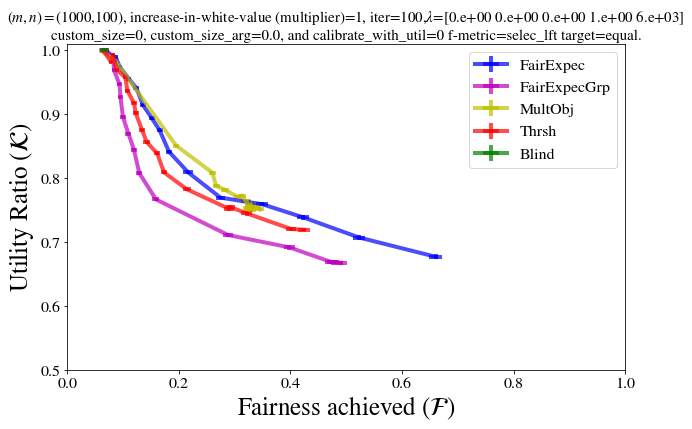

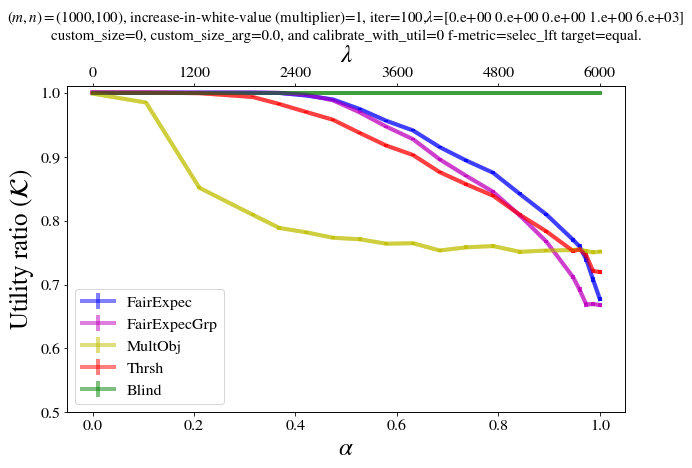

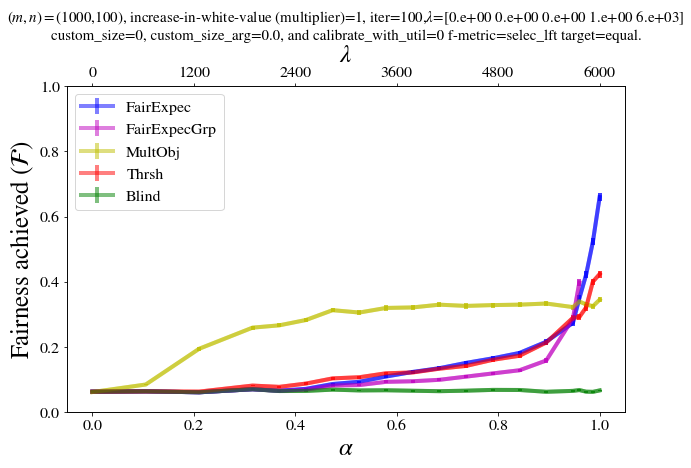

In [46]:
# Generate Figure 16 (Selection lift)
experiment(iter=100, m=1000, n=100, custom_size=0, custom_size_arg=0.0,\
           bias_value_multiplier=1, store_max=0, lam=[0,0,0,1.0,6000.0],\
           fair_metric='selec_lft', verbose=0, save=1)

### Plot for different n/m

iter: iter:  0, iter: iter:  iter:  0,  0,  0, 0, u = [[5.]
 [5.]
 [5.]
 [5.]]
uu = [[5.45]
 [5.45]
 [5.45]
 [5.45]]
u = [[5.]
 [5.]
 [5.]
 [5.]]
uu = [[5.45]
 [5.45]
 [5.45]
 [5.45]]
u = [[5.]
 [5.]
 [5.]
 [5.]]
uu = [[5.45]
 [5.45]
 [5.45]
 [5.45]]
u = [[5.]
 [5.]
 [5.]
 [5.]]
uu = [[5.45]
 [5.45]
 [5.45]
 [5.45]]
u = [[5.]
 [5.]
 [5.]
 [5.]]
uu = [[5.45]
 [5.45]
 [5.45]
 [5.45]]
iter:  1, iter:  1, u = [[5.]
 [5.]
 [5.]
 [5.]]
uu = [[5.45]
 [5.45]
 [5.45]
 [5.45]]
u = [[5.]
 [5.]
 [5.]
 [5.]]
uu = [[5.45]
 [5.45]
 [5.45]
 [5.45]]
iter:  1, iter:  1, iter:  1, u = [[5.]
 [5.]
 [5.]
 [5.]]
uu = [[5.45]
 [5.45]
 [5.45]
 [5.45]]
u = [[5.]
 [5.]
 [5.]
 [5.]]
uu = [[5.45]
 [5.45]
 [5.45]
 [5.45]]
u = [[5.]
 [5.]
 [5.]
 [5.]]
uu = [[5.45]
 [5.45]
 [5.45]
 [5.45]]
iter:  2, iter:  2, u = [[5.]
 [5.]
 [5.]
 [5.]]
uu = [[5.45]
 [5.45]
 [5.45]
 [5.45]]
u = [[5.]
 [5.]
 [5.]
 [5.]]
uu = [[5.45]
 [5.45]
 [5.45]
 [5.45]]
iter:  2, iter:  2, iter:  2, u = [[5.]
 [5.]
 [5.]
 [5.]]
uu = [[5.45]
 [5.

u = [[7.5]
 [7.5]
 [7.5]
 [7.5]]
uu = [[8.175]
 [8.175]
 [8.175]
 [8.175]]
u = [[7.5]
 [7.5]
 [7.5]
 [7.5]]
uu = [[8.175]
 [8.175]
 [8.175]
 [8.175]]
u = [[7.5]
 [7.5]
 [7.5]
 [7.5]]
uu = [[8.175]
 [8.175]
 [8.175]
 [8.175]]
iter:  1, iter:  1, iter:  1, u = [[7.5]
 [7.5]
 [7.5]
 [7.5]]
uu = [[8.175]
 [8.175]
 [8.175]
 [8.175]]
u = [[7.5]
 [7.5]
 [7.5]
 [7.5]]
uu = [[8.175]
 [8.175]
 [8.175]
 [8.175]]
u = [[7.5]
 [7.5]
 [7.5]
 [7.5]]
uu = [[8.175]
 [8.175]
 [8.175]
 [8.175]]
iter:  1, iter:  1, u = [[7.5]
 [7.5]
 [7.5]
 [7.5]]
uu = [[8.175]
 [8.175]
 [8.175]
 [8.175]]
u = [[7.5]
 [7.5]
 [7.5]
 [7.5]]
uu = [[8.175]
 [8.175]
 [8.175]
 [8.175]]
iter:  2, iter:  2, iter:  2, u = [[7.5]
 [7.5]
 [7.5]
 [7.5]]
uu = [[8.175]
 [8.175]
 [8.175]
 [8.175]]
u = [[7.5]
 [7.5]
 [7.5]
 [7.5]]
uu = [[8.175]
 [8.175]
 [8.175]
 [8.175]]
u = [[7.5]
 [7.5]
 [7.5]
 [7.5]]
uu = [[8.175]
 [8.175]
 [8.175]
 [8.175]]
iter:  2, iter:  2, u = [[7.5]
 [7.5]
 [7.5]
 [7.5]]
uu = [[8.175]
 [8.175]
 [8.175]
 [8.175]]


iter:  19, u = [[7.5]
 [7.5]
 [7.5]
 [7.5]]
uu = [[8.175]
 [8.175]
 [8.175]
 [8.175]]
[100, 100, 100, 100, 100] [100, 100, 100, 100, 100]
fair :  0.8076666666666665
fairExpecGrp :  0.755
lag2 :  0.645
thresh :  0.718
blind :  0.264
time take/val:  107.64148020744324
------------------------- n=30 -------------------------
iter: iter:  0,  0, iter: iter:  0, iter:   0, 0, u = [[10.]
 [10.]
 [10.]
 [10.]]
uu = [[10.9]
 [10.9]
 [10.9]
 [10.9]]
u = [[10.]
 [10.]
 [10.]
 [10.]]
uu = [[10.9]
 [10.9]
 [10.9]
 [10.9]]
u = [[10.]
 [10.]
 [10.]
 [10.]]
uu = [[10.9]
 [10.9]
 [10.9]
 [10.9]]
u = [[10.]
 [10.]
 [10.]
 [10.]]
uu = [[10.9]
 [10.9]
 [10.9]
 [10.9]]
u = [[10.]
 [10.]
 [10.]
 [10.]]
uu = [[10.9]
 [10.9]
 [10.9]
 [10.9]]
iter:  1, u = [[10.]
 [10.]
 [10.]
 [10.]]
uu = [[10.9]
 [10.9]
 [10.9]
 [10.9]]
iter:  1, iter:  1, iter:  1, iter:  1, u = [[10.]
 [10.]
 [10.]
 [10.]]
uu = [[10.9]
 [10.9]
 [10.9]
 [10.9]]
u = [[10.]
 [10.]
 [10.]
 [10.]]
uu = [[10.9]
 [10.9]
 [10.9]
 [10.9]]
u = [[10

iter:  19, iter:  19, u = [[10.]
 [10.]
 [10.]
 [10.]]
uu = [[10.9]
 [10.9]
 [10.9]
 [10.9]]
u = [[10.]
 [10.]
 [10.]
 [10.]]
uu = [[10.9]
 [10.9]
 [10.9]
 [10.9]]
iter:  19, u = [[10.]
 [10.]
 [10.]
 [10.]]
uu = [[10.9]
 [10.9]
 [10.9]
 [10.9]]
[100, 100, 100, 100, 100] [100, 100, 100, 100, 100]
fair :  0.8342499999999998
fairExpecGrp :  0.7792500000000001
lag2 :  0.6415000000000001
thresh :  0.7225
blind :  0.267
time take/val:  108.05229902267456
------------------------- n=40 -------------------------
iter: iter:  0,  0, iter: iter: iter:  0,  0,  0, u = [[12.5]
 [12.5]
 [12.5]
 [12.5]]
uu = [[13.625]
 [13.625]
 [13.625]
 [13.625]]
u = [[12.5]
 [12.5]
 [12.5]
 [12.5]]
uu = [[13.625]
 [13.625]
 [13.625]
 [13.625]]
u = [[12.5]
 [12.5]
 [12.5]
 [12.5]]
uuu  = =[[12.5]
 [12.5]
 [12.5]
 [12.5]]
 uu [[13.625]
 [13.625]
 [13.625]
 [13.625]]
= [[13.625]
 [13.625]
 [13.625]
 [13.625]]
u = [[12.5]
 [12.5]
 [12.5]
 [12.5]]
uu = [[13.625]
 [13.625]
 [13.625]
 [13.625]]
iter:  1, iter:  1, iter

iter:  16, iter:  17, iter:  16, u = [[12.5]
 [12.5]
 [12.5]
 [12.5]]
uu = [[13.625]
 [13.625]
 [13.625]
 [13.625]]
u = [[12.5]
 [12.5]
 [12.5]
 [12.5]]
uu = [[13.625]
 [13.625]
 [13.625]
 [13.625]]
u = [[12.5]
 [12.5]
 [12.5]
 [12.5]]
uu = [[13.625]
 [13.625]
 [13.625]
 [13.625]]
iter:  17, iter:  17, u = [[12.5]
 [12.5]
 [12.5]
 [12.5]]
uu = [[13.625]
 [13.625]
 [13.625]
 [13.625]]
u = [[12.5]
 [12.5]
 [12.5]
 [12.5]]
uu = [[13.625]
 [13.625]
 [13.625]
 [13.625]]
iter:  17, iter:  18, iter:  17, u = [[12.5]
 [12.5]
 [12.5]
 [12.5]]
uu = [[13.625]
 [13.625]
 [13.625]
 [13.625]]
u = [[12.5]
 [12.5]
 [12.5]
 [12.5]]
uu = [[13.625]
 [13.625]
 [13.625]
 [13.625]]
u = [[12.5]
 [12.5]
 [12.5]
 [12.5]]
uu = [[13.625]
 [13.625]
 [13.625]
 [13.625]]
iter:  18, iter:  18, u = [[12.5]
 [12.5]
 [12.5]
 [12.5]]
uu = [[13.625]
 [13.625]
 [13.625]
 [13.625]]
u = [[12.5]
 [12.5]
 [12.5]
 [12.5]]
uu = [[13.625]
 [13.625]
 [13.625]
 [13.625]]
iter:  18, iter:  19, iter:  18, u = [[12.5]
 [12.5]
 [12.5]

u = [[15.]
 [15.]
 [15.]
 [15.]]
uu = [[16.35]
 [16.35]
 [16.35]
 [16.35]]
iter:  15, iter:  15, u = [[15.]
 [15.]
 [15.]
 [15.]]
uu = [[16.35]
 [16.35]
 [16.35]
 [16.35]]
u = [[15.]
 [15.]
 [15.]
 [15.]]
uu = [[16.35]
 [16.35]
 [16.35]
 [16.35]]
iter:  15, iter:  15, iter:  15, u = [[15.]
 [15.]
 [15.]
 [15.]]
uu = [[16.35]
 [16.35]
 [16.35]
 [16.35]]
u = [[15.]
 [15.]
 [15.]
 [15.]]
uu = [[16.35]
 [16.35]
 [16.35]
 [16.35]]
u = [[15.]
 [15.]
 [15.]
 [15.]]
uu = [[16.35]
 [16.35]
 [16.35]
 [16.35]]
iter: iter:  16,  16, u = [[15.]
 [15.]
 [15.]
 [15.]]
uu = [[16.35]
 [16.35]
 [16.35]
 [16.35]]
u = [[15.]
 [15.]
 [15.]
 [15.]]
uu = [[16.35]
 [16.35]
 [16.35]
 [16.35]]
iter:  16, iter:  16, iter:  16, u = [[15.]
 [15.]
 [15.]
 [15.]]
uu = [[16.35]
 [16.35]
 [16.35]
 [16.35]]
u = [[15.]
 [15.]
 [15.]
 [15.]]
uu = [[16.35]
 [16.35]
 [16.35]
 [16.35]]
u = [[15.]
 [15.]
 [15.]
 [15.]]
uu = [[16.35]
 [16.35]
 [16.35]
 [16.35]]
iter:  17, iter:  17, u = [[15.]
 [15.]
 [15.]
 [15.]]
uu = [[16.

u = [[17.5]
 [17.5]
 [17.5]
 [17.5]]
uu = [[19.075]
 [19.075]
 [19.075]
 [19.075]]
iter:  12, iter:  12, iter:  12, u = [[17.5]
 [17.5]
 [17.5]
 [17.5]]
uu = [[19.075]
 [19.075]
 [19.075]
 [19.075]]
u = [[17.5]
 [17.5]
 [17.5]
 [17.5]]
uu = [[19.075]
 [19.075]
 [19.075]
 [19.075]]
u = [[17.5]
 [17.5]
 [17.5]
 [17.5]]
uu = [[19.075]
 [19.075]
 [19.075]
 [19.075]]
iter:  13, iter:  13, u = [[17.5]
 [17.5]
 [17.5]
 [17.5]]
uu = [[19.075]
 [19.075]
 [19.075]
 [19.075]]
u = [[17.5]
 [17.5]
 [17.5]
 [17.5]]
uu = [[19.075]
 [19.075]
 [19.075]
 [19.075]]
iter:  13, iter:  13, iter:  13, u = [[17.5]
 [17.5]
 [17.5]
 [17.5]]
uu = [[19.075]
 [19.075]
 [19.075]
 [19.075]]
u = [[17.5]
 [17.5]
 [17.5]
 [17.5]]
uu = [[19.075]
 [19.075]
 [19.075]
 [19.075]]
u = [[17.5]
 [17.5]
 [17.5]
 [17.5]]
uu = [[19.075]
 [19.075]
 [19.075]
 [19.075]]
iter:  14, iter:  14, u = [[17.5]
 [17.5]
 [17.5]
 [17.5]]
uu = [[19.075]
 [19.075]
 [19.075]
 [19.075]]
u = [[17.5]
 [17.5]
 [17.5]
 [17.5]]
uu = [[19.075]
 [19.075

u = [[20.]
 [20.]
 [20.]
 [20.]]
uu = [[21.8]
 [21.8]
 [21.8]
 [21.8]]
iter:  11, u = [[20.]
 [20.]
 [20.]
 [20.]]
uu = [[21.8]
 [21.8]
 [21.8]
 [21.8]]
iter:  11, iter:  11, iter:  11, iter:  11, u = [[20.]
 [20.]
 [20.]
 [20.]]
uu = [[21.8]
 [21.8]
 [21.8]
 [21.8]]
u = [[20.]
 [20.]
 [20.]
 [20.]]
uu = [[21.8]
 [21.8]
 [21.8]
 [21.8]]
u = [[20.]
 [20.]
 [20.]
 [20.]]
uu = [[21.8]
 [21.8]
 [21.8]
 [21.8]]
u = [[20.]
 [20.]
 [20.]
 [20.]]
uu = [[21.8]
 [21.8]
 [21.8]
 [21.8]]
iter:  12, u = [[20.]
 [20.]
 [20.]
 [20.]]
uu = [[21.8]
 [21.8]
 [21.8]
 [21.8]]
iter:  12, u = [[20.]
 [20.]
 [20.]
 [20.]]
uu = [[21.8]
 [21.8]
 [21.8]
 [21.8]]
iter:  12, iter:  12, iter:  12, u = [[20.]
 [20.]
 [20.]
 [20.]]
uu = [[21.8]
 [21.8]
 [21.8]
 [21.8]]
iter:  13, u = [[20.]
 [20.]
 [20.]
 [20.]]
uu = [[21.8]
 [21.8]
 [21.8]
 [21.8]]
u = [[20.]
 [20.]
 [20.]
 [20.]]
uu = [[21.8]
 [21.8]
 [21.8]
 [21.8]]
u = [[20.]
 [20.]
 [20.]
 [20.]]
uu = [[21.8]
 [21.8]
 [21.8]
 [21.8]]
iter:  13, u = [[20.]
 [20.

iter:  9, iter:  9, iter:  9, iter:  9, iter:  9, u = [[22.5]
 [22.5]
 [22.5]
 [22.5]]
uu = [[24.525]
 [24.525]
 [24.525]
 [24.525]]
u = [[22.5]
 [22.5]
 [22.5]
 [22.5]]
uu = [[24.525]
 [24.525]
 [24.525]
 [24.525]]
u = [[22.5]
 [22.5]
 [22.5]
 [22.5]]
uu = [[24.525]
 [24.525]
 [24.525]
 [24.525]]
'NoneType' object is not subscriptable
fairExpecGrplooping due to timeout
iter:  9, u = [[22.5]
 [22.5]
 [22.5]
 [22.5]]
uu = [[24.525]
 [24.525]
 [24.525]
 [24.525]]
u = [[22.5]
 [22.5]
 [22.5]
 [22.5]]
uu = [[24.525]
 [24.525]
 [24.525]
 [24.525]]
u = [[22.5]
 [22.5]
 [22.5]
 [22.5]]
uu = [[24.525]
 [24.525]
 [24.525]
 [24.525]]
iter:  10, iter:  10, iter:  10, iter:  10, u = [[22.5]
 [22.5]
 [22.5]
 [22.5]]
uu = [[24.525]
 [24.525]
 [24.525]
 [24.525]]
u = [[22.5]
 [22.5]
 [22.5]
 [22.5]]
uu = [[24.525]
 [24.525]
 [24.525]
 [24.525]]
iter:  10, u = [[22.5]
 [22.5]
 [22.5]
 [22.5]]
uu = [[24.525]
 [24.525]
 [24.525]
 [24.525]]
u = [[22.5]
 [22.5]
 [22.5]
 [22.5]]
uu = [[24.525]
 [24.525]
 [

iter:  6, iter:  6, iter:  6, iter:  6, u = [[25.]
 [25.]
 [25.]
 [25.]]
uu = [[27.25]
 [27.25]
 [27.25]
 [27.25]]
u = [[25.]
 [25.]
 [25.]
 [25.]]
uu = [[27.25]
 [27.25]
 [27.25]
 [27.25]]
u = [[25.]
 [25.]
 [25.]
 [25.]]
uu = [[27.25]
 [27.25]
 [27.25]
 [27.25]]
u = [[25.]
 [25.]
 [25.]
 [25.]]
uu = [[27.25]
 [27.25]
 [27.25]
 [27.25]]
iter:  7, u = [[25.]
 [25.]
 [25.]
 [25.]]
uu = [[27.25]
 [27.25]
 [27.25]
 [27.25]]
iter:  7, iter:  7, iter:  7, iter:  7, u = [[25.]
 [25.]
 [25.]
 [25.]]
uu = [[27.25]
 [27.25]
 [27.25]
 [27.25]]
u = [[25.]
 [25.]
 [25.]
 [25.]]
uu = [[27.25]
 [27.25]
 [27.25]
 [27.25]]
u = [[25.]
 [25.]
 [25.]
 [25.]]
uu = [[27.25]
 [27.25]
 [27.25]
 [27.25]]
u = [[25.]
 [25.]
 [25.]
 [25.]]
uu = [[27.25]
 [27.25]
 [27.25]
 [27.25]]
iter:  8, u = [[25.]
 [25.]
 [25.]
 [25.]]
uu = [[27.25]
 [27.25]
 [27.25]
 [27.25]]
iter:  8, iter:  8, iter:  8, iter:  8, u = [[25.]
 [25.]
 [25.]
 [25.]]
uu = [[27.25]
 [27.25]
 [27.25]
 [27.25]]
u = [[25.]
 [25.]
 [25.]
 [25.]]
uu

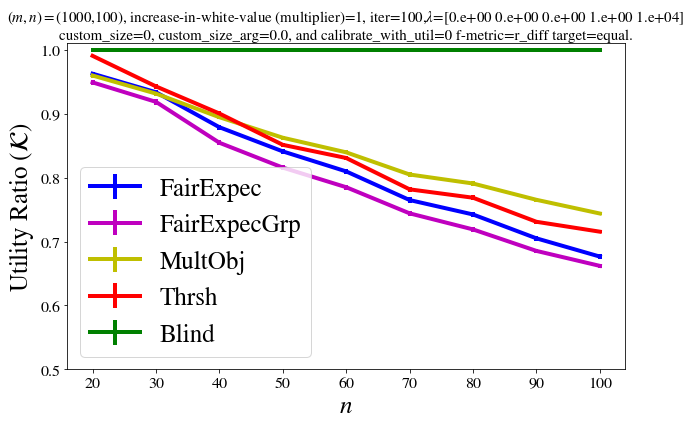

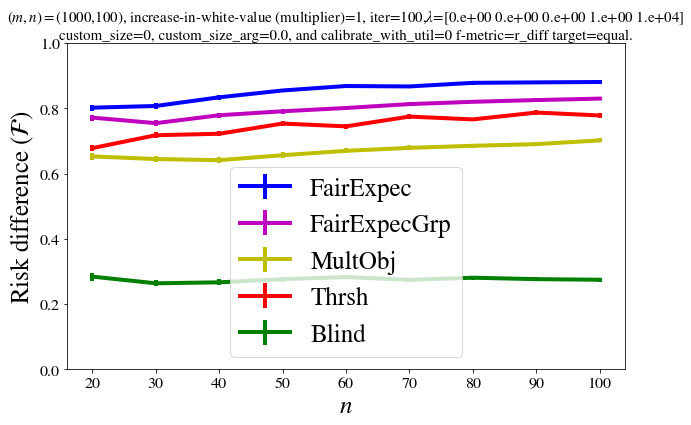

In [40]:
# Generate Figure 7
plot_for_diff_n(iter=100, m=1000, n=100, custom_size=0, custom_size_arg=0.0,\
           bias_value_multiplier=1, store_max=0, lam=[0,0,0,1.0,10000.0],\
           fair_metric='r_diff', verbose=0, save=1)

--- 

--- 

# 4. Real-world data for image search

In [16]:
import cv2
import random
import pickle

from tqdm import tqdm
from numpy import matlib
from varname import nameof

## Helper functions (1)

In [17]:
data_file = home_folder+'occupations_labels.csv'

In [18]:
def stats_occupations_ds(file, verbose=0):
    occupations = {}
    with open(file) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        for row in csv_reader:
            if row[0] not in occupations: occupations[row[0]]=[]
            occupations[row[0]].append({'image':row[0]+"/"+row[1], 'gender':row[2],'skin_tone':row[3]})
            line_count += 1
    occupations_stats = {}
    for o in occupations:
        tot_men = 0; tot_women = 0; tot_dark = 0; tot_light = 0;
        for img in occupations[o]:
            tot_men = tot_men + (img['gender']=='Male')
            tot_women = tot_women + (img['gender']=='Female')
            tot_dark = tot_dark + (img['skin_tone']=='dark')
            tot_light = tot_light + (img['skin_tone']=='light')
        occupations_stats[o] = {"total": len(occupations[o]), "tot_men": tot_men,\
                                "tot_women": tot_women, "tot_dark": tot_dark,\
                                "tot_light": tot_light}

    # prints file in csv format.
    if verbose:
        for o in occupations_stats: print(o,",",occupations_stats[o]["tot_men"],",",\
                                        occupations_stats[o]["tot_women"],",",\
                                        occupations_stats[o]["tot_dark"],",",\
                                        occupations_stats[o]["tot_light"])
    return occupations, occupations_stats

In [19]:
occupations, occupations_stats = stats_occupations_ds(data_file);

In [20]:
def filter_occupations(tau_rule=0.8, least_number_of_humans=50, verbose=0):
    _, stats = stats_occupations_ds(data_file);
    women_typical = []; men_typical = []; neutral = []
    for o in stats:
        if stats[o]["tot_men"]+stats[o]["tot_women"] >= least_number_of_humans:
            tot=stats[o]["tot_men"]+stats[o]["tot_women"]
            if stats[o]["tot_women"]/tot >= tau_rule: women_typical.append(o)
            elif stats[o]["tot_men"]/tot >= tau_rule: men_typical.append(o)
            else: neutral.append(o)
    if verbose:
        print("women_typical:")
        for o in women_typical: print(o, end=",")
        print("men_typical:")
        for o in men_typical: print(o, end=",")
        print("neutral:")
        for o in neutral: print(o, end=",")
    return women_typical, men_typical, neutral

In [21]:
all_occ, _, _ = filter_occupations(0,0,0)
all_occ.sort();

## A. CNN-based gender classifier (Optional)

In [22]:
# Predictions using the classfier might be computationially heavy.
# The user can avoid recomputing the predictions, by using our precomputed results on the Occupations dataset.
# To use the pre-computed results set `runClassifier = False`
# Otherwise set `runClassifier = True` 

# Remarks:
# Note that to run the classifier you need a suitable caffe installation.
# We refer the user to https://www.pyimagesearch.com/2018/02/26/face-detection-with-opencv-and-deep-learning/ for a tutorial on the face detector we use

In [ ]:
import caffee

In [24]:
runClassifier = False

### Preprocessing occupations dataset to generate cropped images

In [25]:
occ_folder=""

if runClassifier: 
    home_folder+"Occupations_dataset_images/"

crop_folder=home_folder+"image-subset-selection/Occupations-dataset/Occupations-Datatset-2019/Occupations_dataset_images_cropped/"

#### Helper functions

In [26]:
def detect_faces(img, net, thresh=0.5,verbose=0):
    # source: https://www.pyimagesearch.com/2018/02/26/face-detection-with-opencv-and-deep-learning/#download-the-code
    # load the input image and construct an input blob for the image
    # by resizing to a fixed 300x300 pixels and then normalizing it
    image = cv2.imread(img)
    try: (h, w) = image.shape[:2]
    except:
        print("skipped!")
        return -1
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
    # pass the blob through the network and obtain the detections andpredictions
    net.setInput(blob)
    detections = net.forward()
    faces=[]
    # loop over the detections
    for i in range(detections.shape[1]):
        # extract the confidence (i.e., probability) associated with the prediction
        confidence = detections[0, 0, i, 2]
        if confidence > thresh:
            # compute the (x, y)-coordinates of the bounding box for the object
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            faces.append([startX, startY, endX, endY])
            #
            if verbose:
                ##draw the bounding box of the face along with the associated  probability
                text = "{:.2f}%".format(confidence * 100);
                y = startY - 10 if startY - 10 > 10 else startY + 10;
                cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2);
                cv2.putText(image, text, (startX, y), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)
    # show the output image
    if verbose: cv2.imshow("Output", image); cv2.waitKey(0); cv2.destroyWindow("Output")
    return faces

In [27]:
def extract_faces(image, faces, verbose=0):
    # set default margin
    pad=0.4 ## cropping margin
    # size of face
    # extractSubImage(img,box,pad)
    cropped_faces=[]
    for box in faces:
        sz =[box[3]-box[1]+1, box[2]-box[0]+1]
        #add margin
        new_crop = [0]*4
        new_crop[0]=round(box[0]-pad*sz[1]);
        new_crop[1]=round(box[1]-pad*sz[0]);
        new_crop[2]=round(box[2]+pad*sz[1]);
        new_crop[3]=round(box[3]+pad*sz[0]);
        # size of face with margin
        new_sz=[new_crop[3]-new_crop[1]+1, new_crop[2]-new_crop[0]+1]
        # ensure that the region cropped from the original image with margin doesn't go beyond the image size
        crop = [0]*4
        crop[0]=max(new_crop[0],0);
        crop[1]=max(new_crop[1],0);
        crop[2]=min(new_crop[2],image.shape[1]-1);
        crop[3]=min(new_crop[3],image.shape[0]-1);
        # size of the actual region being cropped from the original image
        crop_sz=[crop[3]-crop[1]+1, crop[2]-crop[0]+1]
        # create new image
        new_img=np.zeros((new_sz[0],new_sz[1],image.shape[2]), np.uint8)
        # coordinates of region taken out of the original image in the new image
        new_loc=[0]*4
        new_loc[0]=crop[0]-new_crop[0];
        new_loc[1]=crop[1]-new_crop[1];
        new_loc[2]=new_loc[0]+crop_sz[1]-1;
        new_loc[3]=new_loc[1]+crop_sz[0]-1;
        # coordinates of the face in the new image
        # obj_location=[0]*4
        # for i in range(4): obj_location[i]=new_loc[i]+box[i]-crop[i]+1;
        # do the crop
        try: new_img[new_loc[1]:new_loc[3]+1, new_loc[0]:new_loc[2]+1, :] = image[crop[1]:crop[3]+1,crop[0]:crop[2]+1,:];
        except:
            print("skipped!");
            debug("new_img.shape, image.shape");
            return -1;
        # if margin goes beyond the size of the image, repeat last row of pixels
        for c in range(image.shape[2]):
            if new_loc[1]>0:
                if verbose: print("a")
                new_img[:new_loc[1],:,c]  = np.matlib.repmat(new_img[new_loc[1],:,c],new_loc[1],1);
            if new_loc[3]<new_img.shape[0]-1:
                if verbose: print("b")
                new_img[new_loc[3]+1:,:,c]=np.matlib.repmat(new_img[new_loc[3],:,c],new_img.shape[0]-new_loc[3]-1,1);
            if new_loc[0]>0:
                if verbose: print("c")
                new_img[:,:new_loc[0],c]  =np.matlib.repmat(new_img[:,new_loc[0],c],new_loc[0],1).T;
            if new_loc[2]<new_img.shape[1]-1:
                if verbose: print("d")
                new_img[:,new_loc[2]+1:,c]=np.matlib.repmat(new_img[:,new_loc[2],c],new_img.shape[1]-new_loc[2]-1,1).T;
        cropped_faces.append(new_img)
        if verbose: cv2.imshow("padded_image", new_img); cv2.waitKey(0); cv2.destroyWindow("padded_image")
    return cropped_faces

#### Load model

In [28]:
if runClassifier:
    prototxt=home_folder+"deploy.prototxt.txt"
    model=home_folder+"res10_300x300_ssd_iter_140000.caffemodel"
    net = cv2.dnn.readNetFromCaffe(prototxt, model)

#### Code to crop and save images

In [29]:
if runClassifier:
    def solve(folder, occupation, num,net):
        file = occupation+"/0000"+("0" if num<10 else "")+str(num)
        if num == 100: file = occupation+"/000100"
        print(occupation, num)
        tmp = folder+file+".jpg"
        image = cv2.imread(tmp)
        face_boxes = detect_faces(tmp,net)
        if face_boxes == -1: return
        cropped_faces=extract_faces(image, face_boxes)
        if cropped_faces == -1: return
        i=0
        for f in cropped_faces: cv2.imwrite(crop_folder+file+"_"+str(i)+".jpg",f); i+=1

#### Run classifier and save images

In [30]:
if runClassifier:
    occ = list(occupations_stats.keys()); occ.sort()
    for o in occ:
        for i in range(1,101): solve(occ_folder, o, i, net)

In [31]:
if runClassifier: del(net) # delete net to save RAM 

## Helper functions (2; pre-processing and generating predictions)

In [32]:
def get_images_with_humans(o_list=[]):
    imgs=[]
    occupations, _ = stats_occupations_ds(data_file);
    for o in o_list:
        for im in occupations[o]:
            if im['gender']!='NA': imgs.append(im)
    return imgs

In [33]:
def get_images_all(o_list=[]):
    imgs=[]
    occupations, _ = stats_occupations_ds(data_file);
    for o in o_list:
        for im in occupations[o]: imgs.append(im)
    return imgs

In [34]:
def predict_in_parallel(imgs, llim=0, rlim=0):
    # Set the right path to your model definition file, pretrained model weights,
    # and the image you would like to classify.
    MODEL_FILE = home_folder+'../rothe2016deep/gender-prediction/models/gender.prototxt'
    PRETRAINED = home_folder+'../rothe2016deep/gender-prediction/models/gender.caffemodel'
    # load the model
    caffe.set_mode_cpu()
    # caffe.set_device(0)
    net = caffe.Classifier(MODEL_FILE, PRETRAINED, channel_swap=(2,1,0), raw_scale=255, image_dims=(256, 256))
    print("successfully loaded classifier")
    #
    # Not storing the images (keeps the memory requirement down)
    pred=[]; i=0
    for x in tqdm(imgs[llim:rlim]):
        i+=1
        IMAGE_FILE = crop_folder+x['image'].split('.')[0]+"_0"+".jpg"
        try:
            img = caffe.io.load_image(IMAGE_FILE)
            pred.extend(net.predict([img]))
        except Exception as exc:
            print(f"found bad image: {x['image']}!")
            pred.append([0,0])
    pred=np.array(pred)
    #
    debug("len(pred)")
    # pred[i] = (percent_woman, percent_man)
    #
    file = open('pred_for_tau00_min00_'+str(llim)+"_"+str(rlim), 'wb')
    pickle.dump(pred, file)

In [37]:
def ok_pred(pred):
    if pred[0]+pred[1]>0.5: return True
    return False

def generate_bins(imgs, num_bins=20, predict_now=runClassifier, verbose=0):
    if predict_now: 
        # predicitions take time; run only once.
        
        predict_in_parallel(imgs, 0, 500)
        predict_in_parallel(imgs, 500, 2500)
        predict_in_parallel(imgs, 2500, 4500)
        predict_in_parallel(imgs, 4500, 6000)
        
        pred=[]
        file = open('pred_for_tau00_min00_0_500', 'rb')
        pred.extend(list(pickle.load(file, encoding='latin1')))
        file = open('pred_for_tau00_min00_500_2500', 'rb')
        pred.extend(list(pickle.load(file, encoding='latin1')))
        file = open('pred_for_tau00_min00_2500_4500', 'rb')
        pred.extend(list(pickle.load(file, encoding='latin1')))
        file = open('pred_for_tau00_min00_4500_6000', 'rb')
        pred.extend(list(pickle.load(file, encoding='latin1')))
        debug("len(pred)")
        # Note: pred[i] = (percent_woman, percent_man)
        
        file = open(home_folder+'pre-predicted-labels/pred_for_tau0_6_min00', 'wb')
        pickle.dump(pred, file)
    else: 
        ## Use values calculated earlier to save computation
        pred=[]
        file = open(home_folder+'pre-predicted-labels/pred_for_tau0_6_min00', 'rb')
        pred.extend(list(pickle.load(file, encoding='latin1')))
        pred=np.array(pred)
    
    cnt=0;bad_ind=[]
    for i in range(len(pred)):
        if not ok_pred(pred[i]): cnt+=1; bad_ind.append(i)
    if verbose: print("Percentage of images without bounding boxes: ", cnt/len(imgs)*100)
    
    for i in range(len(imgs)): imgs[i]['pred'] = pred[i]
    
    # Generating bins
    tmp = []
    bins = np.linspace(0, 1, num_bins)
    for it in pred:
        if ok_pred(it): tmp.append(it[0])
    digi = np.digitize(tmp, bins)
    cnt_bin={}; cnt_bin_f={}; #number of females in bin
    cnt=0; cntf=0 # cnt of females which have a prediction
    for i in range(1,num_bins): cnt_bin_f[i]=0; cnt_bin[i]=0;
    for i in digi: cnt_bin[i]+=1
    for i in range(len(imgs)):
        if not ok_pred(pred[i]): continue
        if imgs[i]['gender']=='Female': cntf+=1; cnt_bin_f[digi[cnt]]+=1
        cnt+=1
    assert(cnt==len(tmp))
    frac_f=[cnt_bin_f[i]/(cnt_bin[i]+1e-5) for i in range(1,num_bins)]
    frac_f=np.array(frac_f)
    arr_cnt_bin = [cnt_bin[i] for i in range(1,num_bins)]; arr_cnt_bin=np.array(arr_cnt_bin)
    
    # Print
    if verbose:
        print(f"Number of images with predictions: {len(tmp)}")
        print(f"Number of images marked women with predictions: {cntf}")
        print(f"Number of bins: {num_bins}")
        print(f"Fraction of females in bins: ")
        debug("np.round(frac_f, 2)")
        print(f"Number of images in bins: ")
        debug("arr_cnt_bin")
    
    #
    acc=0 # number of correct predictions for women
    for i in range(len(imgs)):
        if not ok_pred(pred[i]): continue
        if imgs[i]['gender']=='Female' and pred[i][0]>=0.5: acc+=1
    if verbose: print(f"Accuracy on women={round(acc/cntf*100, 2)}%")
    acc=0 # number of correct predictions for men
    for i in range(len(imgs)):
        if not ok_pred(pred[i]): continue
        if imgs[i]['gender']=='Male' and pred[i][0]<0.5: acc+=1
    if verbose: print(f"Accuracy on men={round(acc/(len(tmp)-cntf)*100,2)}%")
    #
    return pred, bins, frac_f

In [38]:
def get_prediction_stats(imgs,num_bins=20,verbose=1):
    # Expects images from `get_prediction_and_image` (this pre-processes them)
    bins = np.linspace(0, 1, num_bins)
    tmp = []
    for i in range(len(imgs)):
        if ok_pred(imgs[i]['pred']): tmp.append(imgs[i]['pred'][0])
    assert(len(tmp)==len(imgs)) # Expects images from `get_prediction_and_image` (this pre-processes them)
    digi = np.digitize(tmp, bins)
    cnt_bin={}; cnt_bin_f={}; #number of females in bin
    cnt=0; cntf=0 # cnt of females which have a prediction
    for i in range(1,num_bins): cnt_bin_f[i]=0; cnt_bin[i]=0;
    for i in digi: cnt_bin[i]+=1
    for i in range(len(imgs)):
        if not ok_pred(imgs[i]['pred']): 
            print("bigoops")
            continue
        if imgs[i]['gender']=='Female': cntf+=1; cnt_bin_f[digi[cnt]]+=1
        cnt+=1
    if verbose: print(cnt, len(tmp))
    assert(cnt==len(tmp))
    frac_f=[cnt_bin_f[i]/(cnt_bin[i]+1e-5) for i in range(1,num_bins)]
    frac_f=np.array(frac_f)
    arr_cnt_bin = [cnt_bin[i] for i in range(1,num_bins)]; arr_cnt_bin=np.array(arr_cnt_bin)
    # Print
    if verbose:
        print(f"Number of images with predictions: {len(tmp)}")
        print(f"Number of images marked women with predictions: {cntf}")
        print(f"Number of bins: {num_bins}")
        print(f"Fraction of females in bins: ")
        debug("np.round(frac_f, 2)")
        print(f"Number of images in bins: ")
        debug("arr_cnt_bin")
    #
    acc=0 # number of correct predictions for women
    for it in imgs:
        if not ok_pred(it['pred']): continue
        if it['gender']=='Female' and it['pred'][0]>=0.5: acc+=1
    if verbose: print(f"Accuracy on women={round(acc/cntf*100, 2)}%")
    acc=0 # number of correct predictions for men
    for it in imgs:
        if not ok_pred(it['pred']): continue
        if it['gender']=='Male' and it['pred'][0]<0.5: acc+=1
    if verbose: print(f"Accuracy on men={round(acc/(len(tmp)-cntf)*100,2)}%")
    #
    return pred, bins, frac_f

In [39]:
def calibrate_pred(pred, c_bins=[], c_frac_f=[]):
    if len(c_frac_f)!=0 and len(c_bins)!=0: 
        return [c_frac_f[np.digitize(pred[0], c_bins)-1], 1-c_frac_f[np.digitize(pred[0], c_bins)-1]]
    return [frac_f[np.digitize(pred[0], bins)-1], 1-frac_f[np.digitize(pred[0], bins)-1]]

#### Generating all images

In [40]:
imgs = get_images_with_humans(all_occ) ## All images with humans

#### Load predictions and bin them

In [41]:
pred, bins, frac_f = generate_bins(imgs,num_bins=20,verbose=1)

Percentage of images without bounding boxes:  22.849785407725324
Number of images with predictions: 4494
Number of images marked women with predictions: 2047
Number of bins: 20
Fraction of females in bins: 
Number of images in bins: 
Accuracy on women=84.76%
Accuracy on men=95.55%


## Helper functions (3; sample candidates and utilities)

In [42]:
def get_prediction_and_image(o_list=[],custom_cal=0):
    imgs = get_images_with_humans(all_occ)
    pred, bins, frac_f = generate_bins(imgs)
    ## Remove bad images from immages and add pred valueus to images
    imgs_new = []
    for i in range(len(imgs)):
        if ok_pred(pred[i]) and imgs[i]['image'].split('/')[0] in o_list:
            imgs[i]['pred']=pred[i]; imgs_new.append(imgs[i]);
    imgs_new = np.array(imgs_new)
    #
    c_bins=[]; c_frac_f=[]
    if custom_cal:
        _, c_bins, c_frac_f = get_prediction_stats(imgs=imgs_new,verbose=0)
    return imgs_new, c_bins, c_frac_f

In [43]:
def gen_candidates_image(m,imgs=[],c_bins=[], c_frac_f=[]):
    ## shuffle images (in imgs) and pick m of thems
    if m > len(imgs): raise Exception("m larger than the number of images!")
    ## construct q from the bins calculated earlier.
    subset=random.sample(list(imgs),m)
    q=[calibrate_pred(s['pred'],c_bins=c_bins,c_frac_f=c_frac_f) for s in subset]
    return np.array(subset), np.array(q)

In [44]:
utility_type_dict={0:'DCG (100/log(r+1))', 1:'Unif[0,1]', 2:'100/(r+1)', 3:'100-r'}
def gen_utility_image(subset,utility_type=0, multiplier=1):
    ## read image position and result utility
    # Utility types: 0==DCG, 1==Uniform, 2==Power-law (exp=1)
    li = []
    for img in subset:
        r = int(img['image'].split('/')[1].split('.')[0]) ## rank
        assert(multiplier==1)
        if utility_type==0: li.append(100/np.log(r+1)+rng.uniform(0,1)) # 100/np.log(r+1) is at least 20
        elif utility_type==1: li.append(rng.uniform(0,1))
        elif utility_type==2: li.append(100/(r+1)+rng.uniform(0,1)) # 100/(r+1) is at least 1
        elif utility_type==3: li.append(100-r+rng.uniform(0,1)) # 100/(r+1) is at least 1
    return li

In [45]:
# Compute Qgrp
p = 2
m=4494
Qgrp_image = np.zeros((2,2))

# Sample
imgs, c_bins, c_frac_f = get_prediction_and_image(all_occ,custom_cal=0)
cnd, q = gen_candidates_image(m, imgs, c_bins = c_bins, c_frac_f = c_frac_f)
w = gen_utility_image(cnd, utility_type=0, multiplier=1)

print("Fraction Female: ", np.sum([cnd[i]['gender']=='Female' for i in range(m)])/m)
print("Fraction Male: ", np.sum([cnd[i]['gender']=='Male' for i in range(m)])/m)
print("")

#

tmp = ['Female', 'Male']
for (i,gi), (j,gj) in itertools.product(enumerate(tmp), enumerate(tmp)):
    tot = np.sum( [i == np.argmax(q[t]) for t in range(m)])
    typ_t = np.sum( [(gj == cnd[t]['gender'])*(i == np.argmax(q[t])) for t in range(m)])
    Qgrp_image[i][j] = typ_t/tot

eval(debug("Qgrp_image"))

Fraction Female:  0.45549621717846017
Fraction Male:  0.5445037828215399

Qgrp_image = [[0.89533239 0.10466761]
 [0.06236831 0.93763169]]


## Simulation code

In [46]:
def subset_selection_image_one_olist(alpha, iter=100, m=1000, n=50, imgs=[], utility_type=0, \
                           bias_value_multiplier=1, c_bins=[], c_frac_f=[],\
                           verbose=0, lam=1, fair_metric='r_diff'):
    #
    # We compare the number of women selected by the thresholding and the fair in expectation scheme.
    # For each iteration, we sample the predictions of the classifier (from rothe et al. 2017) from the distributions fitted earlier.
    # We use the following parameters: (m,n,p)
    p = 2 # two genders
    #
    algos = [fair_select_lp, thresh_select, blind_select, fair_select_lp, lagrangian_solver]
    algo_res = [[] for a in algos]
    algo_val = [[] for a in algos]
    algo_names = ["fair", "thresh", "blind", "fairGroup", "lag2"]
    #
    # Run algorithms
    i=0
    while i < iter:
        if verbose: print("iter: ", i, end=", ")
        # Generate candidates
        cnd, q = gen_candidates_image(m,imgs,c_bins=c_bins, c_frac_f=c_frac_f)
        if verbose: 
            print("#Female: ", np.sum([(c['gender']=='Female') for c in cnd]), "#Male: ", np.sum([(c['gender']=='Male') for c in cnd]))
            print("Ex[Female]: ", np.sum([it[0] for it in q]), "Ex[Male]: ", np.sum([it[1] for it in q]))
        w = gen_utility_image(cnd, utility_type=utility_type, multiplier=1)
        #
        qgrp = np.array([Qgrp_image[np.argmax(x)] for x in q])
        ave_w = np.mean(w)
        #
        t = np.array([1.0/p]*p); t = np.reshape(t, (p,1))
        u = np.array([n*(1-alpha) for s in range(p)]) ## male, female
        w = np.reshape(w, (m,1)); q = np.reshape(q, (m,p)); u = np.reshape(u, (p,1))  ## male, female
        #
        if verbose: debug("alpha"); debug("u")
        #
        def aggregate_stats(x,store_val=False, fair_metric = 'r_diff'):
            num_women_picked  = np.sum([x[i]*(cnd[i]['gender']=='Female') for i in range(m)])
            val=np.sum([x[i]*w[i] for i in range(m)]) / np.sum(x) * n
            if verbose: debug("num_women_picked"); debug("val")
            if store_val: return val
            num_picked = [num_women_picked, n-num_women_picked]
            if store_val: return val
            elif fair_metric == 'selec_lft': 
                mi = 2
                for i,j in itertools.product(range(p),range(p)): 
                    mi = min(mi, num_picked[i]/num_picked[j] if num_picked[j] else 0.0)
                return mi
            elif fair_metric == 'r_diff':
                mi = -1
                for i,j in itertools.product(range(p),range(p)): 
                    mi = max(mi, abs(num_picked[i]-num_picked[j])/n)
                return 1-mi
            elif fair_metric == 'custom':
                mi = 2
                for i,j in itertools.product(range(p),range(p)): 
                    mi = min(mi, p/(p-1.0) * (1 - num_picked[i]/n))
                return mi
            else: print("Must choose a fairness definition!"); raise NotImplementedError
        #
        # Run algorithms
        fg=0
        if verbose: print("")
        for j, algo in enumerate(algos): 
            if verbose: print('trying'+algo_names[j], end=" ")
            try: #solving
                if j == 4: x=algo(w,q,t,n,lam=lam[j]*ave_w, eps=1e-2) #x=list(fair_select(w,q,u,n))
                elif j == 3: x=algo(w,qgrp,u,n,lam=lam[j]*ave_w, eps=1e-2)
                else: x=algo(w,q,u,n,lam=lam[j]*ave_w, eps=1e-2) #x=list(fair_select(w,q,u,n))
                if type(x)!=type(-1): x=list(x)
                else: fg=1; print(algo_names[j]+" returned invalid solution\n");
                if not fg and np.sum(x) > n*3/2: fg=1; print(algo_names[j]+" returned invalid solution2\n");
            except Exception as exc: fg=1; print(exc); print('looping due to timeout');
            if fg: #breaking
                for k in range(j): algo_res[k]=algo_res[k][:-1]; algo_val[k]=algo_val[k][:-1]; print(k)
                print("breaking!", [len(res) for res in algo_res], [len(val) for val in algo_val])
                break
            if verbose: print(algo_names[j],": ",np.sum(x), end= " | ")
            algo_res[j].append(aggregate_stats(x,store_val=False))
            algo_val[j].append(aggregate_stats(x,store_val=True))
        if fg: # repeating 
            print(f"redoing iteration {i}!")
            print(i)
            continue
        #
        i+=1
    #
    out = []
    print([len(res) for res in algo_res], [len(val) for val in algo_val])
    algo_val[2]=np.array(algo_val[2]); ## for blind
    for v in algo_res: out.append([np.mean(v), np.std(v)])
    for i, v in enumerate(algo_val):
        if i == 2: out.append([1,0]); continue
        v=np.array(v)
        v=v/algo_val[2] # for blind
        out.append([np.mean(v), np.std(v)])
    return out[0], out[1], out[2], out[3], out[4], out[5], out[6], out[7], out[8], out[9]

In [47]:
isNDGC = False
def subset_selection_image(alpha, iter=100, m=1000, n=50, imgs=[], utility_type=0, \
                           bias_value_multiplier=1, c_bins=[], c_frac_f=[],\
                           verbose=0, lam=1, fair_metric='r_diff', imgs2=[], target='equal'):
    #
    # We compare the number of women selected by the thresholding and the fair in expectation scheme.
    # For each iteration, we sample the predictions of the classifier (from rothe et al. 2017) from the distributions fitted earlier.
    # We use the following parameters: (m,n,p)
    p = 2 # two genders
    #
    algos = [fair_select_lp, thresh_select, blind_select, fair_select_lp, lagrangian_solver]
    algo_res = [[] for a in algos]
    algo_val = [[] for a in algos]
    algo_names = ["fair", "thresh", "blind", "fairGroup", "lag2"]
    #
    ma = int(len(imgs)*1.0/(len(imgs)+len(imgs2)) * m)
    mb = m-ma
    #eval(debug("iter"))
    # Run algorithms
    i=0
    while i < iter:
        if 1: print("iter: ", i, end=", ")
        # Generate candidates
        #eval(debug("len(imgs), len(imgs2)"))
        cnda, qa = gen_candidates_image(ma, imgs, c_bins=c_bins, c_frac_f=c_frac_f)
        cndb, qb = gen_candidates_image(mb, imgs2, c_bins=[], c_frac_f=[])
        #eval(debug("ma, mb, len(qa), len(qb)"))
        ## flipping labels for cndb
        for j in range(mb):
            qb[j][0], qb[j][1] = qb[j][1], qb[j][0]
            cndb[j]['gender'] = 'Female' if cndb[j]['gender'] != 'Female' else 'Male'
        cnd = np.array(list(cnda)+list(cndb))
        q = np.array(list(qa)+list(qb))
        #eval(debug("len(q)"))
        if verbose: 
            print("#Female: ", np.sum([(c['gender']=='Female') for c in cnd]), "#Male: ", np.sum([(c['gender']=='Male') for c in cnd]))
            print("Ex[Female]: ", np.sum([it[0] for it in q]), "Ex[Male]: ", np.sum([it[1] for it in q]))
        w = gen_utility_image(cnd, utility_type=utility_type, multiplier=1)
        #
        qgrp = np.array([Qgrp_image[np.argmax(x)] for x in q])
        ave_w = np.mean(w)
        #
        if verbose: debug("alpha"); debug("u")
        #        
        # target = 'proportional'
        if target == 'equal': t = np.array([1.0/p]*p)
        elif target == 'proportional': t = np.array(t_proportion_image)
        #
        #0.82879514, 0.13465577, 0.00834839, 0.0282007 
        u = np.array([n*t[s]+n*(1-t[s])*(1-alpha) for s in range(p)]) ## male, female
        # eval(debug("t"))
        # eval(debug("u"))
        t = np.reshape(t, (p,1)); w = np.reshape(w, (m,1)); q = np.reshape(q, (m,p)); u = np.reshape(u, (p,1))  ## male, female

        # Run algorithms        
        def aggregate_stats(x,store_val=False, fair_metric = 'r_diff'):
            def get_val():
                if not isNDGC: 
                    return np.sum([x[i]*w[i] for i in range(m)])
                # eval(debug("ind"))
                if isNDGC: 
                    ind = np.argsort(w.flatten())
                    return np.sum([x[ind[i]]*w[ind[i]]/np.log(ind[i]+2) for i in range(m)])
            num_women_picked  = np.sum([x[i]*(cnd[i]['gender']=='Female') for i in range(m)])
            val=get_val() / np.sum(x) * n
            if verbose: debug("num_women_picked"); debug("val")
            if store_val: return val
            num_picked = [num_women_picked, n-num_women_picked]
            if store_val: return val
            elif fair_metric == 'selec_lft':
                mi = 2
                for i,j in itertools.product(range(p),range(p)): 
                    mi = min(mi, num_picked[i]*t[j]/t[i]/num_picked[j] if num_picked[j] else 0.0)
                return mi
            elif fair_metric == 'r_diff':
                mx = -1
                min_t = min(t)
                for i,j in itertools.product(range(p),range(p)): 
                    mx = max(mx, min_t * abs(num_picked[i]*1.0/n/t[i]-num_picked[j]*1.0/n/t[j]))
                return 1 - mx
            elif fair_metric == 'custom':
                mi = 2
                for i,j in itertools.product(range(p),range(p)): 
                    mi = min(mi, p/(p-1.0) * (1 - num_picked[i]/n))
                return mi
            else: print("Must choose a fairness definition!"); raise NotImplementedError
        #
        # Run algorithms
        fg=0
        if verbose: print("")
        for j, algo in enumerate(algos): 
            if verbose: print('trying'+algo_names[j], end=" ")
            try: #solving
                if j == 4: x=algo(w,q,t,n,lam=lam[j]*ave_w, eps=1e-2) #x=list(fair_select(w,q,u,n))
                elif j == 3: x=algo(w,qgrp,u,n,lam=lam[j]*ave_w, eps=1e-2)
                else: x=algo(w,q,u,n,lam=lam[j]*ave_w, eps=1e-2) #x=list(fair_select(w,q,u,n))
                if type(x)!=type(-1): x=list(x)
                else: fg=1; print(algo_names[j]+" returned invalid solution\n");
                if not fg and np.sum(x) > n*3/2: fg=1; print(algo_names[j]+" returned invalid solution2\n");
            except Exception as exc: fg=1; print(exc); print('looping due to timeout');
            if fg: #breaking
                for k in range(j): algo_res[k]=algo_res[k][:-1]; algo_val[k]=algo_val[k][:-1]; print(k)
                print("breaking!", [len(res) for res in algo_res], [len(val) for val in algo_val])
                break
            if verbose: print(algo_names[j],": ",np.sum(x), end= " | ")
            algo_res[j].append(aggregate_stats(x,store_val=False))
            algo_val[j].append(aggregate_stats(x,store_val=True))
        if fg: # repeating 
            print(f"redoing iteration {i}!")
            print(i)
            continue
        #
        i+=1
    #
    out = []
    print([len(res) for res in algo_res], [len(val) for val in algo_val])
    for i in range(len(algo_names)): print(algo_names[i], ": ", np.mean(algo_res[i]))
    algo_val[2]=np.array(algo_val[2]); ## for blind
    for v in algo_res: out.append([np.mean(v), np.std(v)])
    for i, v in enumerate(algo_val):
        if i == 2: out.append([1,0]); continue
        v=np.array(v)
        v=v/algo_val[2] # for blind
        out.append([np.mean(v), np.std(v)])
    return out[0], out[1], out[2], out[3], out[4], out[5], out[6], out[7], out[8], out[9]

In [48]:
def experiment_image(iter=100, m=1000, n=50, o_list=[], bias_value_multiplier=1,\
                    utility_type=0, name_o_list="", custom_cal=0, lam=[0,0,0,1.0,200.0],\
                    fair_metric='r_diff', o_list2=[], name_o_list2="", verbose=0, save=1,target='equal'):
    #
    # Initialize
    p = 2
    assert(custom_cal==0)
    imgs,c_bins,c_frac_f=get_prediction_and_image(o_list,custom_cal=custom_cal)
    imgs2,c_bins,c_frac_f=get_prediction_and_image(o_list2,custom_cal=custom_cal)
    #
    range_alpha=np.linspace(0,1,10)
    range_lam=np.linspace(0,1,10)
    lam = np.array(lam)
    #
    fair_res={'mean':[], 'std':[]}; thresh_res={'mean':[], 'std':[]}; blind_res={'mean':[], 'std':[]}; lag_res={'mean':[], 'std':[]}; lag_res2={'mean':[], 'std':[]}
    fair_val={'mean':[], 'std':[]}; thresh_val={'mean':[], 'std':[]}; blind_val={'mean':[], 'std':[]}; lag_val={'mean':[], 'std':[]}; lag_val2={'mean':[], 'std':[]}
    func = [fair_res, thresh_res, blind_res, lag_res, lag_res2, fair_val, thresh_val, blind_val, lag_val, lag_val2]
    #
    # Run experiment
    for i, alpha in enumerate(range_alpha):
        temp = subset_selection_image(alpha, iter=iter, m=m, n=n, imgs=imgs,\
                                     bias_value_multiplier=bias_value_multiplier,\
                                     utility_type=utility_type, c_bins=c_bins, \
                                     c_frac_f=c_frac_f, verbose=verbose,\
                                     lam=range_lam[i]*lam,fair_metric=fair_metric, imgs2=imgs2, target=target)
        tmp = [[] for i in range(10)]
        tmp[0],tmp[1],tmp[2],tmp[3],tmp[4],tmp[5],tmp[6],tmp[7],tmp[8],tmp[9] = temp
        # Store results
        print("-"*25, f"alpha={alpha}", "-"*25)
        for i in range(10):  func[i]['mean'].append(tmp[i][0]); func[i]['std'].append(tmp[i][1])
    ##
    ##
    def get_fairness(output):
        raise NotImplementedError
        # out <= n*(1-a) and out >= n-n*(1-a) = na
        output = np.array(output)
        if verbose: eval(debug("output")); eval(debug("1-(output/n)"))
        #
        return np.minimum(1-(output/n),output/n) * p/(p-1)
    #
    algo_res = [fair_res, thresh_res, lag_res, lag_res2, blind_res]
    algo_val = [fair_val, thresh_val, lag_val, lag_val2, blind_val]
    algo_name = ['FairExpec', 'Thresh', 'FairExpecGrp', 'MultObj', 'Blind']
    algo_col = ['b','r','m','y','g']
    #
    def plot(store_val=False, plot_true_fair=False,\
             res_lambda=False, plot_fair_alpha=False, plot_fair_lambda=False):
        assert(store_val + plot_true_fair <= 1)
        x=range_alpha
        fig, ax = plt.subplots()
        ax2 = -1
        if plot_fair_alpha or store_val: 
            ax2 = ax.twiny()
            ax2.set_xlabel('$\\lambda$',fontsize=25)
        
        if plot_true_fair:
            ## Plot: value vs fairness
            for j in [0, 2, 3, 1, 4]:
                res = algo_res[j];
                val = algo_val[j];
                # for j,(res,val) in enumerate(zip(algo_res[:-1],algo_val[:-1])):
                # if j==2: continue
                xaxis=res['mean'] ## get fairness of the result
                print(algo_name[j], " (fairness): ", xaxis)
                ## sort to make the line plot clean
                val['mean'] = [x for _,x in sorted(zip(xaxis,val['mean']))]
                val['std'] = [x for _,x in sorted(zip(xaxis,val['std']))]
                xaxis = sorted(xaxis)
                # plot
                plt.errorbar(xaxis, val['mean'], val['std']/np.sqrt(iter), xerr=res['std']/np.sqrt(iter), color=algo_col[j], label=algo_name[j], linewidth=4, alpha=0.7)
            #
        elif res_lambda:
            raise NotImplementedError
            for j in [3,4]:
                res = algo_res[j]
                plt.errorbar(lam[4]*range_lam, res['mean'], res['std']/np.sqrt(iter), color=algo_col[j], label=algo_name[j], linewidth=4)
        elif plot_fair_alpha:
            ## Plot: fairness vs alpha
            for j in [0, 2, 3, 1, 4]:
                res = algo_res[j];
                # for j, res in enumerate(algo_res):
                # if j == 3 or j == 3: continue # do not plot lagrangian_fair vs alpha
                # yaxis=res['mean'] ## get fairness of the result
                # plt.errorbar(x, yaxis, res['std']/np.sqrt(iter), color=algo_col[j], label=algo_name[j], linewidth=4)
                if j != 2: 
                    ax.errorbar(x, res['mean'], res['std']/np.sqrt(iter), color=algo_col[j], label=algo_name[j], linewidth=4, alpha=0.5)
                    ax2.errorbar(x, res['mean'],yerr=res['std']/np.sqrt(iter), color=algo_col[j], label=algo_name[j], linewidth=4, alpha=0.5)
                else: 
                    ax2.errorbar(x, res['mean'],yerr=res['std']/np.sqrt(iter), color=algo_col[j], label=algo_name[j], linewidth=4, alpha=0.5)
                    ax.errorbar(x, res['mean'],yerr=res['std']/np.sqrt(iter), color=algo_col[j], label=algo_name[j], linewidth=4, alpha=0.5)
        elif plot_fair_lambda:
            raise NotImplementedError
            ## Plot: fairness vs lambda
            for j, res in enumerate(algo_res):
                if j != 3 and j != 4: continue # do not plot alpha_fair vs lambda
                yaxis=res['mean'] ## get fairness of the result
                plt.errorbar(lam[4]*range_lam, yaxis, res['std']/np.sqrt(iter), color=algo_col[j], label=algo_name[j], linewidth=4)
        elif store_val:
            ## Plot: value vs alpha
            for j in [0, 2, 3, 1, 4]:
                val = algo_val[j]
                # for j, val in enumerate(algo_val):
                if j != 2: 
                    ax.errorbar(x, val['mean'], val['std']/np.sqrt(iter), color=algo_col[j], label=algo_name[j], linewidth=4, alpha=0.5)
                    ax2.errorbar(x, val['mean'],yerr=val['std']/np.sqrt(iter), color=algo_col[j], label=algo_name[j], linewidth=4, alpha=0.5)
                else: 
                    ax2.errorbar(x, val['mean'],yerr=val['std']/np.sqrt(iter), color=algo_col[j], label=algo_name[j], linewidth=4, alpha=0.5)
                    ax.errorbar(x, val['mean'],yerr=val['std']/np.sqrt(iter), color=algo_col[j], label=algo_name[j], linewidth=4, alpha=0.5)
                # if j == 3 or j == 3: continue # do not plot lagrangian_fair vs alpha
                # plt.errorbar(x, val['mean'], val['std']/np.sqrt(iter), color=algo_col[j], label=algo_name[j], linewidth=4)
        else:
            raise NotImplementedError
            ## Plot: res vs alpha
            for j, res in enumerate(algo_res):
                if j == 3 or j == 3: continue # do not plot lagrangian_fair vs alpha
                plt.errorbar(x, res['mean'], res['std']/np.sqrt(iter), color=algo_col[j], label=algo_name[j], linewidth=4)
        #
        #
        ## plot contraints (upper bound and lower bound)
        if (plot_fair_alpha + plot_fair_lambda + store_val + plot_true_fair + res_lambda) < 1: 
            plt.plot(x,[n*(1-a) for a in x], '--', color='black', label='Const.', linewidth=4)
            plt.plot(x,[n-n*(1-a) for a in x], '--', color='black', label='Const.', linewidth=4)
        if res_lambda: plt.plot(lam[4]*range_lam,[n/p for a in x], '--', color='black', label='Target', linewidth=4)
        #
        ## Decorate
        if store_val:
            plt.ylim(0.85,1.0+1e-2)
            plt.ylabel('Utility Ratio ($\\mathcal{K}$)', fontsize=25)
            ax.set_ylabel('Utility ratio ($\\mathcal{K}$)', fontsize=25)
        elif res_lambda:
            plt.ylim(n/4,3*n/4)
            plt.ylabel('Maximum-candidates from one race', fontsize=25)
        elif plot_fair_alpha or plot_fair_lambda:
            if fair_metric == 'r_diff': plt.ylim(0.4,1.0)
            if fair_metric == 'selec_lft': plt.ylim(0.40,1.0)
            plt.ylabel('Fairness achieved ($\\mathcal{F}$)', fontsize=25)      
            ax.set_ylabel('Fairness achieved ($\\mathcal{F}$)', fontsize=25)
        elif plot_true_fair:
            plt.ylim(0.85,1.0+1e-2)
            if fair_metric == 'r_diff': plt.xlim(0.4,1.0)
            if fair_metric == 'selec_lft': plt.xlim(0.40,1.0)
            plt.ylabel('Utility Ratio ($\\mathcal{K}$)', fontsize=25)
        else: plt.ylabel('Number of women', fontsize=25)
        
        if plot_fair_alpha or store_val: ax.set_xlabel('$\\alpha$',fontsize=25)
        elif plot_fair_lambda or res_lambda: plt.xlabel('$\\lambda$',fontsize=25)
        elif plot_true_fair: plt.xlabel('Fairness achieved ($\\mathcal{F}$)',fontsize=25)
        else: ax.set_xlabel('$\\alpha$',fontsize=25)
            
        if ax2 != -1: 
            ax2.set_xticklabels([round(xx*lam[4]) for i, xx in enumerate(ax.get_xticks())])
        
        legend = plt.legend(loc='best', shadow=False, fontsize=16)
        plt.tick_params(axis='both', which='major', labelsize=16)
        ax.tick_params(axis='both', which='major', labelsize=16)
        plt.title(f'Image search (custom_cal={custom_cal})\n$(m,n)=$({m},{n}), inc-in-male-val (multiplier)={bias_value_multiplier},\n iter={iter}, target={target}, utype={utility_type_dict[utility_type]},\n o_lists=[{name_o_list},{name_o_list2}], fmetric={fair_metric}.', fontsize=15)

        ## Show or save
        if save: pdf_savefig()
        else: plt.show()
        #
    #
    plot(store_val=False, plot_true_fair=True) #Plot: value vs fairness
    plot(store_val=True, plot_true_fair=False) #Plot: value vs alpha 
    plot(store_val=False, plot_true_fair=False, res_lambda=False, plot_fair_alpha=True) #Plot: fairness vs alpha
    # plot(store_val=False, plot_true_fair=False, res_lambda=False, plot_fair_lambda=True) #Plot: fairness vs alpha

In [49]:
def plot_for_diff_n_image(iter=100, m=1000, n=50, o_list=[], bias_value_multiplier=1,\
                    utility_type=0, name_o_list="", custom_cal=0, lam=[0,0,0,1.0,200.0],\
                    fair_metric='r_diff', o_list2=[], name_o_list2="", verbose=0, save=1,target='equal'):
    #
    # Initialize
    p = 2
    assert(custom_cal==0)
    imgs,c_bins,c_frac_f=get_prediction_and_image(o_list,custom_cal=custom_cal)
    imgs2,c_bins,c_frac_f=get_prediction_and_image(o_list2,custom_cal=custom_cal)
    
    range_n = np.array([25,50,75,100,125,150,175,200,225,250])
    
    # range_alpha=np.linspace(0,1,2)
    # range_lam=np.linspace(0,1,2)
    lam = np.array(lam)
    #
    fair_res={'mean':[], 'std':[]}; thresh_res={'mean':[], 'std':[]}; blind_res={'mean':[], 'std':[]}; lag_res={'mean':[], 'std':[]}; lag_res2={'mean':[], 'std':[]}
    fair_val={'mean':[], 'std':[]}; thresh_val={'mean':[], 'std':[]}; blind_val={'mean':[], 'std':[]}; lag_val={'mean':[], 'std':[]}; lag_val2={'mean':[], 'std':[]}
    func = [fair_res, thresh_res, blind_res, lag_res, lag_res2, fair_val, thresh_val, blind_val, lag_val, lag_val2]
    #
    # Run experiment
    for i, n in enumerate(range_n):
        temp = subset_selection_image(1, iter=iter, m=m, n=n, imgs=imgs,\
                                     bias_value_multiplier=bias_value_multiplier,\
                                     utility_type=utility_type, c_bins=c_bins, \
                                     c_frac_f=c_frac_f, verbose=verbose,\
                                     lam=lam,fair_metric=fair_metric, imgs2=imgs2, target=target)
        tmp = [[] for i in range(10)]
        tmp[0],tmp[1],tmp[2],tmp[3],tmp[4],tmp[5],tmp[6],tmp[7],tmp[8],tmp[9] = temp
        # Store results
        print("-"*25, f"n={n}", "-"*25)
        for i in range(10):  func[i]['mean'].append(tmp[i][0]); func[i]['std'].append(tmp[i][1])
    ##
    ##
    def get_fairness(output):
        raise NotImplementedError
        # out <= n*(1-a) and out >= n-n*(1-a) = na
        output = np.array(output)
        if verbose: eval(debug("output")); eval(debug("1-(output/n)"))
        #
        return np.minimum(1-(output/n),output/n) * p/(p-1)
    #
    # algo_res = [fair_res, thresh_res, lag_res, lag_res2, blind_res]
    # algo_val = [fair_val, thresh_val, lag_val, lag_val2, blind_val]
    # algo_name = ['FairExpec', 'Thresh', 'FairExpecGrp', 'MultObj', 'Blind']
    # algo_col = ['b','r','m','y','g']
    
    algo_res = [fair_res, lag_res, lag_res2, thresh_res, blind_res]
    algo_val = [fair_val, lag_val, lag_val2, thresh_val, blind_val]
    algo_name = ['FairExpec', 'FairExpecGrp', 'MultObj', 'Thresh', 'Blind']
    algo_col = ['b','m','y','r','g']
    #
    def plot(store_val=False, plot_true_fair=False,\
             res_lambda=False, plot_fair_alpha=False, plot_fair_lambda=False):
        assert(store_val + plot_true_fair <= 1)
        x=range_n
        fig, ax = plt.subplots()
        if plot_true_fair:
            ## Plot: value vs fairness
            for j in [0, 2, 3, 1]:
                res = algo_res[j];
                val = algo_val[j];
                # for j,(res,val) in enumerate(zip(algo_res[:-1],algo_val[:-1])):
                # if j==2: continue
                xaxis=res['mean'] ## get fairness of the result
                print(algo_name[j], " (fairness): ", xaxis)
                ## sort to make the line plot clean
                val['mean'] = [x for _,x in sorted(zip(xaxis,val['mean']))]
                val['std'] = [x for _,x in sorted(zip(xaxis,val['std']))]
                xaxis = sorted(xaxis)
                # plot
                plt.errorbar(xaxis, val['mean'], val['std']/np.sqrt(iter), xerr=res['std']/np.sqrt(iter), color=algo_col[j], label=algo_name[j], linewidth=4, alpha=0.7)
            #
        elif res_lambda:
            for j in [3,4]:
                res = algo_res[j]
                plt.errorbar(lam[4]*range_lam, res['mean'], res['std']/np.sqrt(iter), color=algo_col[j], label=algo_name[j], linewidth=4)
        elif plot_fair_alpha:
            ## Plot: fairness vs alpha
            for j, res in enumerate(algo_res):
                yaxis=res['mean'] ## get fairness of the result
                plt.errorbar(x, yaxis, res['std']/np.sqrt(iter), color=algo_col[j], label=algo_name[j], linewidth=4)
        elif plot_fair_lambda:
            ## Plot: fairness vs lambda
            for j, res in enumerate(algo_res):
                if j != 3 and j != 4: continue # do not plot alpha_fair vs lambda
                yaxis=res['mean'] ## get fairness of the result
                plt.errorbar(lam[4]*range_lam, yaxis, res['std']/np.sqrt(iter), color=algo_col[j], label=algo_name[j], linewidth=4)
        elif store_val:
            ## Plot: value vs alpha
            for j, val in enumerate(algo_val):
                plt.errorbar(x, val['mean'], val['std']/np.sqrt(iter), color=algo_col[j], label=algo_name[j], linewidth=4)
        else:
            ## Plot: res vs alpha
            for j, res in enumerate(algo_res):
                if j == 3 or j == 3: continue # do not plot lagrangian_fair vs alpha
                plt.errorbar(x, res['mean'], res['std']/np.sqrt(iter), color=algo_col[j], label=algo_name[j], linewidth=4)
        #
        #
        ## plot contraints (upper bound and lower bound)
        if (plot_fair_alpha + plot_fair_lambda + store_val + plot_true_fair + res_lambda) < 1: 
            plt.plot(x,[n*(1-a) for a in x], '--', color='black', label='Const.', linewidth=4)
            plt.plot(x,[n-n*(1-a) for a in x], '--', color='black', label='Const.', linewidth=4)
        if res_lambda: plt.plot(lam[4]*range_lam,[n/p for a in x], '--', color='black', label='Target', linewidth=4)
        #
        ## Decorate
        if store_val:
            plt.ylim(0.70,1.0+1e-2)
            plt.ylabel('Utility Ratio ($\\mathcal{K}$)', fontsize=25)
        elif res_lambda:
            plt.ylim(n/4,3*n/4)
            plt.ylabel('Maximum-candidates from one race', fontsize=25)
        elif plot_fair_alpha or plot_fair_lambda:
            plt.ylim(0.0,1.0)
            plt.ylabel('Fairness achieved ($\\mathcal{F}$)', fontsize=25)      
        elif plot_true_fair:
            plt.ylim(0.70,1.0+1e-2)
            plt.xlim(0.4,1.0)
            plt.ylabel('Utility Ratio ($\\mathcal{K}$)', fontsize=25)
        else: plt.ylabel('Number of women', fontsize=25)
        #
        legend = plt.legend(loc='best', shadow=False, fontsize=16)
        if plot_fair_alpha or store_val: plt.xlabel('$n$',fontsize=25)
        elif plot_fair_lambda or res_lambda: plt.xlabel('$\\lambda$',fontsize=25)
        elif plot_true_fair: plt.xlabel('Fairness achieved ($\\mathcal{F}$)',fontsize=25)
        else: plt.xlabel('$\\alpha$',fontsize=25)
        plt.tick_params(axis='both', which='major', labelsize=16)
        plt.title(f'Image search (custom_cal={custom_cal})\n$(m,n)=$({m},{n}), inc-in-male-val (multiplier)={bias_value_multiplier},\n iter={iter}, target={target}, utype={utility_type_dict[utility_type]},\n o_lists=[{name_o_list},{name_o_list2}], fmetric={fair_metric}.', fontsize=15)
        ## Show or save
        if save: pdf_savefig()
        else: plt.show()
        #
    #
    # plot(store_val=False, plot_true_fair=True) #Plot: value vs fairness
    plot(store_val=True, plot_true_fair=False) #Plot: value vs alpha 
    plot(store_val=False, plot_true_fair=False, res_lambda=False, plot_fair_alpha=True) #Plot: fairness vs alpha
    # plot(store_val=False, plot_true_fair=False, res_lambda=False, plot_fair_lambda=True) #Plot: fairness vs alpha

## Experiments

### Check stats and generate constants

In [111]:
debug("len(women_typical)")
imgs,_,_=get_prediction_and_image(all_occ)
debug("len(imgs)")
cnt=np.sum([ok_pred(it['pred']) for it in imgs])
debug("cnt")
_=get_prediction_stats(imgs)

4494 4494
Number of images with predictions: 4494
Number of images marked women with predictions: 2047
Number of bins: 20
Fraction of females in bins: 
Number of images in bins: 
Accuracy on women=84.76%
Accuracy on men=95.55%


In [112]:
debug("len(women_typical)")
imgs,_,_=get_prediction_and_image(women_typical)
debug("len(imgs)")
cnt=np.sum([ok_pred(it['pred']) for it in imgs])
debug("cnt")
_=get_prediction_stats(imgs)

1451 1451
Number of images with predictions: 1451
Number of images marked women with predictions: 1139
Number of bins: 20
Fraction of females in bins: 
Number of images in bins: 
Accuracy on women=87.09%
Accuracy on men=90.38%


In [114]:
women_typical08, men_typical08, neutral08 = filter_occupations(0.8,0,0)
women_typical08.sort(); men_typical08.sort(); neutral08.sort()

## Experiments

iter:  0, iter:  1, iter:  2, iter:  3, iter:  4, iter:  5, iter:  6, iter:  7, iter:  8, iter:  9, iter:  10, iter:  11, iter:  12, iter:  13, iter:  14, iter:  15, iter:  16, iter:  17, iter:  18, iter:  19, iter:  20, iter:  21, iter:  22, iter:  23, iter:  24, iter:  25, iter:  26, iter:  27, iter:  28, iter:  29, iter:  30, iter:  31, iter:  32, iter:  33, iter:  34, iter:  35, iter:  36, iter:  37, iter:  38, iter:  39, iter:  40, iter:  41, iter:  42, iter:  43, iter:  44, iter:  45, iter:  46, iter:  47, iter:  48, iter:  49, iter:  50, iter:  51, iter:  52, iter:  53, iter:  54, iter:  55, iter:  56, iter:  57, iter:  58, iter:  59, iter:  60, iter:  61, iter:  62, iter:  63, iter:  64, iter:  65, iter:  66, iter:  67, iter:  68, iter:  69, iter:  70, iter:  71, iter:  72, iter:  73, iter:  74, iter:  75, iter:  76, iter:  77, iter:  78, iter:  79, iter:  80, iter:  81, iter:  82, iter:  83, iter:  84, iter:  85, iter:  86, iter:  87, iter:  88, iter:  89, iter:  90, iter:  91

iter:  0, iter:  1, iter:  2, iter:  3, iter:  4, iter:  5, iter:  6, iter:  7, iter:  8, iter:  9, iter:  10, iter:  11, iter:  12, iter:  13, iter:  14, iter:  15, iter:  16, iter:  17, iter:  18, iter:  19, iter:  20, iter:  21, iter:  22, iter:  23, iter:  24, iter:  25, iter:  26, iter:  27, iter:  28, iter:  29, iter:  30, iter:  31, iter:  32, iter:  33, iter:  34, iter:  35, iter:  36, iter:  37, iter:  38, iter:  39, iter:  40, iter:  41, iter:  42, iter:  43, iter:  44, iter:  45, iter:  46, iter:  47, iter:  48, iter:  49, iter:  50, iter:  51, iter:  52, iter:  53, iter:  54, iter:  55, iter:  56, iter:  57, iter:  58, iter:  59, iter:  60, iter:  61, iter:  62, iter:  63, iter:  64, iter:  65, iter:  66, iter:  67, iter:  68, iter:  69, iter:  70, iter:  71, iter:  72, iter:  73, iter:  74, iter:  75, iter:  76, iter:  77, iter:  78, iter:  79, iter:  80, iter:  81, iter:  82, iter:  83, iter:  84, iter:  85, iter:  86, iter:  87, iter:  88, iter:  89, iter:  90, iter:  91

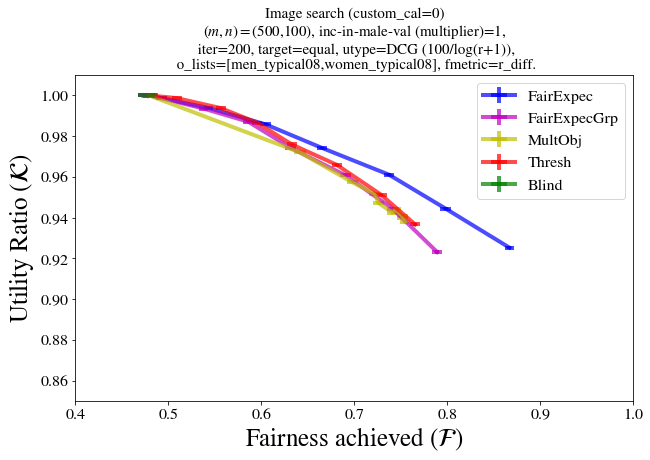

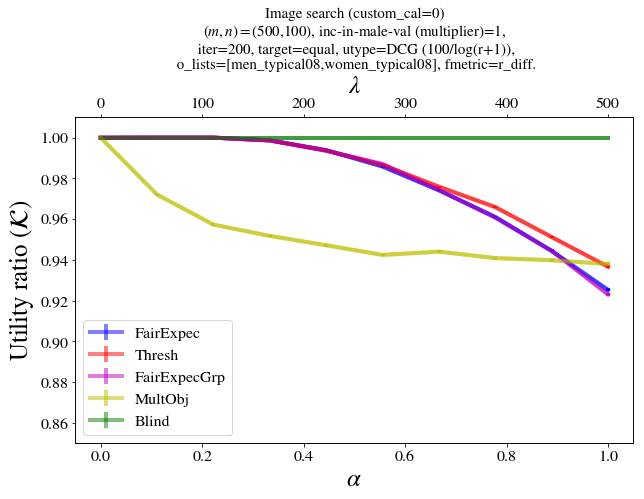

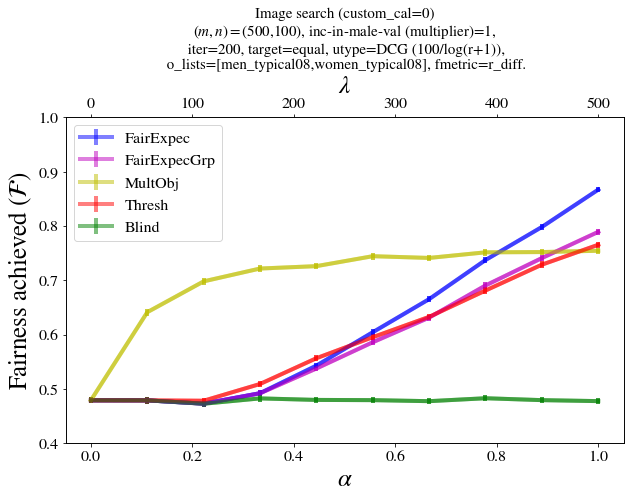

In [122]:
# Generate Figure 5 and Figure 18 (Risk difference)
isNDGC = False
for utility_type in range(1):
    for fair_metric in ['r_diff']:
        experiment_image(iter=200, m=500, n=100, o_list=men_typical08, bias_value_multiplier=1,\
                         utility_type=utility_type, name_o_list="men_typical08",\
                         o_list2=women_typical08, name_o_list2="women_typical08",\
                         lam=[0,0,0,1.0,500.0], target='equal',\
                         fair_metric=fair_metric, verbose=0, save=1)

iter:  0, iter:  1, iter:  2, iter:  3, iter:  4, iter:  5, iter:  6, iter:  7, iter:  8, iter:  9, iter:  10, iter:  11, iter:  12, iter:  13, iter:  14, iter:  15, iter:  16, iter:  17, iter:  18, iter:  19, iter:  20, iter:  21, iter:  22, iter:  23, iter:  24, iter:  25, iter:  26, iter:  27, iter:  28, iter:  29, iter:  30, iter:  31, iter:  32, iter:  33, iter:  34, iter:  35, iter:  36, iter:  37, iter:  38, iter:  39, iter:  40, iter:  41, iter:  42, iter:  43, iter:  44, iter:  45, iter:  46, iter:  47, iter:  48, iter:  49, iter:  50, iter:  51, iter:  52, iter:  53, iter:  54, iter:  55, iter:  56, iter:  57, iter:  58, iter:  59, iter:  60, iter:  61, iter:  62, iter:  63, iter:  64, iter:  65, iter:  66, iter:  67, iter:  68, iter:  69, iter:  70, iter:  71, iter:  72, iter:  73, iter:  74, iter:  75, iter:  76, iter:  77, iter:  78, iter:  79, iter:  80, iter:  81, iter:  82, iter:  83, iter:  84, iter:  85, iter:  86, iter:  87, iter:  88, iter:  89, iter:  90, iter:  91

iter:  0, iter:  1, iter:  2, iter:  3, iter:  4, iter:  5, iter:  6, iter:  7, iter:  8, iter:  9, iter:  10, iter:  11, iter:  12, iter:  13, iter:  14, iter:  15, iter:  16, iter:  17, iter:  18, iter:  19, iter:  20, iter:  21, iter:  22, iter:  23, iter:  24, iter:  25, iter:  26, iter:  27, iter:  28, iter:  29, iter:  30, iter:  31, iter:  32, iter:  33, iter:  34, iter:  35, iter:  36, iter:  37, iter:  38, iter:  39, iter:  40, iter:  41, iter:  42, iter:  43, iter:  44, iter:  45, iter:  46, iter:  47, iter:  48, iter:  49, iter:  50, iter:  51, iter:  52, iter:  53, iter:  54, iter:  55, iter:  56, iter:  57, iter:  58, iter:  59, iter:  60, iter:  61, iter:  62, iter:  63, iter:  64, iter:  65, iter:  66, iter:  67, iter:  68, iter:  69, iter:  70, iter:  71, iter:  72, iter:  73, iter:  74, iter:  75, iter:  76, iter:  77, iter:  78, iter:  79, iter:  80, iter:  81, iter:  82, iter:  83, iter:  84, iter:  85, iter:  86, iter:  87, iter:  88, iter:  89, iter:  90, iter:  91

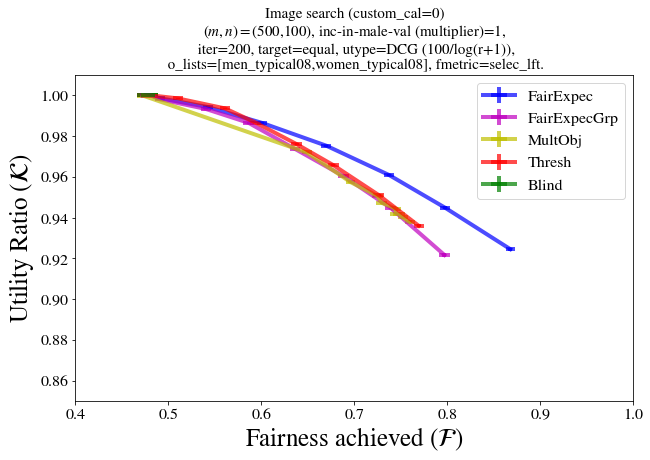

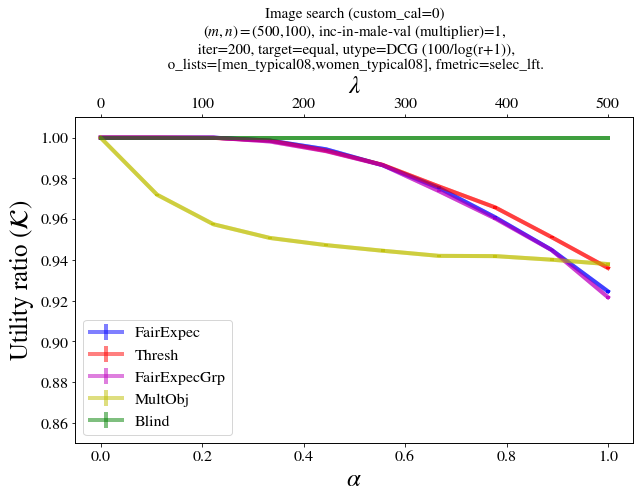

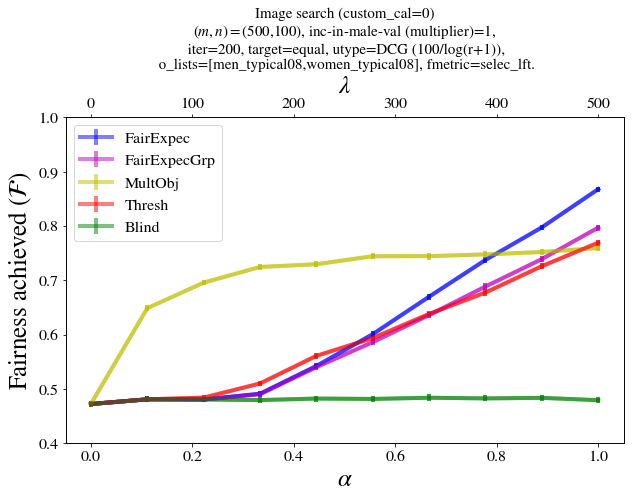

In [132]:
# Generate Figure 20 (selection lift)
isNDGC = False
for utility_type in range(1):
    for fair_metric in ['selec_lft']:
        experiment_image(iter=200, m=500, n=100, o_list=men_typical08, bias_value_multiplier=1,\
                         utility_type=utility_type, name_o_list="men_typical08",\
                         o_list2=women_typical08, name_o_list2="women_typical08",\
                         lam=[0,0,0,1.0,500.0], target='equal',\
                         fair_metric=fair_metric, verbose=0, save=1)

iter:  0, iter:  1, iter:  2, iter:  3, iter:  4, iter:  5, iter:  6, iter:  7, iter:  8, iter:  9, iter:  10, iter:  11, iter:  12, iter:  13, iter:  14, iter:  15, iter:  16, iter:  17, iter:  18, iter:  19, iter:  20, iter:  21, iter:  22, iter:  23, iter:  24, iter:  25, iter:  26, iter:  27, iter:  28, iter:  29, iter:  30, iter:  31, iter:  32, iter:  33, iter:  34, iter:  35, iter:  36, iter:  37, iter:  38, iter:  39, iter:  40, iter:  41, iter:  42, iter:  43, iter:  44, iter:  45, iter:  46, iter:  47, iter:  48, iter:  49, iter:  50, iter:  51, iter:  52, iter:  53, iter:  54, iter:  55, iter:  56, iter:  57, iter:  58, iter:  59, iter:  60, iter:  61, iter:  62, iter:  63, iter:  64, iter:  65, iter:  66, iter:  67, iter:  68, iter:  69, iter:  70, iter:  71, iter:  72, iter:  73, iter:  74, iter:  75, iter:  76, iter:  77, iter:  78, iter:  79, iter:  80, iter:  81, iter:  82, iter:  83, iter:  84, iter:  85, iter:  86, iter:  87, iter:  88, iter:  89, iter:  90, iter:  91

iter:  0, iter:  1, iter:  2, iter:  3, iter:  4, iter:  5, iter:  6, iter:  7, iter:  8, iter:  9, iter:  10, iter:  11, iter:  12, iter:  13, iter:  14, iter:  15, iter:  16, iter:  17, iter:  18, iter:  19, iter:  20, iter:  21, iter:  22, iter:  23, iter:  24, iter:  25, iter:  26, iter:  27, iter:  28, iter:  29, iter:  30, iter:  31, iter:  32, iter:  33, iter:  34, iter:  35, iter:  36, iter:  37, iter:  38, iter:  39, iter:  40, iter:  41, iter:  42, iter:  43, iter:  44, iter:  45, iter:  46, iter:  47, iter:  48, iter:  49, iter:  50, iter:  51, iter:  52, iter:  53, iter:  54, iter:  55, iter:  56, iter:  57, iter:  58, iter:  59, iter:  60, iter:  61, iter:  62, iter:  63, iter:  64, iter:  65, iter:  66, iter:  67, iter:  68, iter:  69, iter:  70, iter:  71, iter:  72, iter:  73, iter:  74, iter:  75, iter:  76, iter:  77, iter:  78, iter:  79, iter:  80, iter:  81, iter:  82, iter:  83, iter:  84, iter:  85, iter:  86, iter:  87, iter:  88, iter:  89, iter:  90, iter:  91

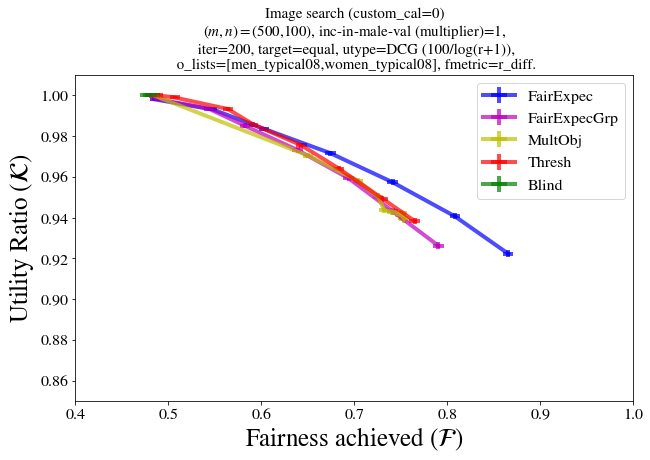

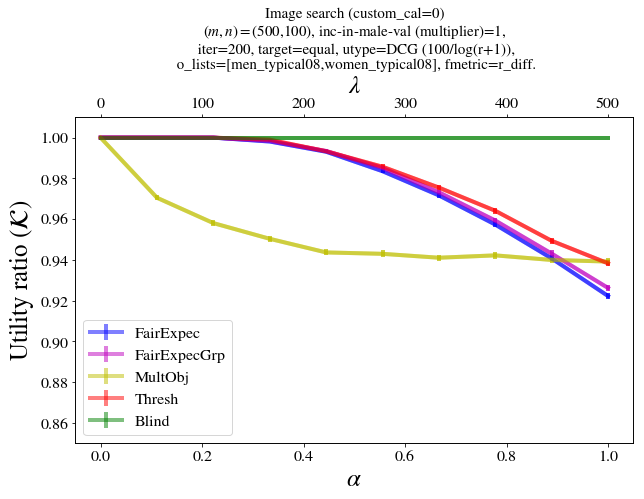

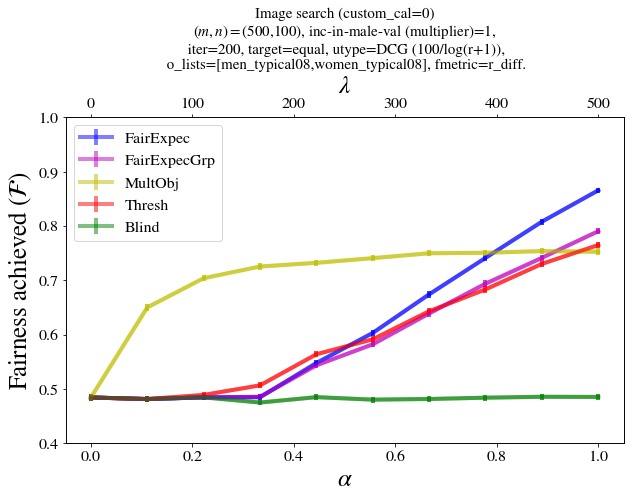

In [155]:
# Generate Figure 19 (NDGC metric) 
## trying equal representation and NDGC metric
isNDGC = True
for utility_type in range(1):
    for fair_metric in ['r_diff']:
        experiment_image(iter=200, m=500, n=100, o_list=men_typical08, bias_value_multiplier=1,\
                         utility_type=utility_type, name_o_list="men_typical08",\
                         o_list2=women_typical08, name_o_list2="women_typical08",\
                         lam=[0,0,0,1.0,500.0], target='equal',\
                         fair_metric=fair_metric, verbose=0, save=1)

### Plot for different n/m

iter:  0, iter:  1, iter:  2, iter:  3, iter:  4, iter:  5, iter:  6, iter:  7, iter:  8, iter:  9, iter:  10, iter:  11, iter:  12, iter:  13, iter:  14, iter:  15, iter:  16, iter:  17, iter:  18, iter:  19, iter:  20, iter:  21, iter:  22, iter:  23, iter:  24, iter:  25, iter:  26, iter:  27, iter:  28, iter:  29, iter:  30, iter:  31, iter:  32, iter:  33, iter:  34, iter:  35, iter:  36, iter:  37, iter:  38, iter:  39, iter:  40, iter:  41, iter:  42, iter:  43, iter:  44, iter:  45, iter:  46, iter:  47, iter:  48, iter:  49, [50, 50, 50, 50, 50] [50, 50, 50, 50, 50]
fair :  0.8895999999999998
thresh :  0.7743999999999999
blind :  0.5791999999999999
fairGroup :  0.7999999999999998
lag2 :  0.7744
------------------------- n=25 -------------------------
iter:  0, iter:  1, iter:  2, iter:  3, iter:  4, iter:  5, iter:  6, iter:  7, iter:  8, iter:  9, iter:  10, iter:  11, iter:  12, iter:  13, iter:  14, iter:  15, iter:  16, iter:  17, iter:  18, iter:  19, iter:  20, iter:  21

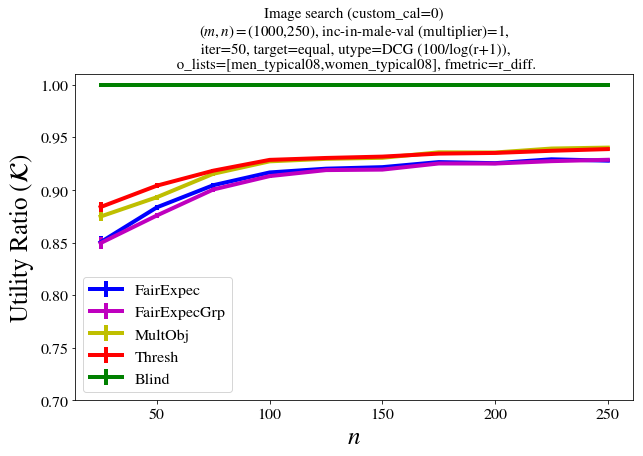

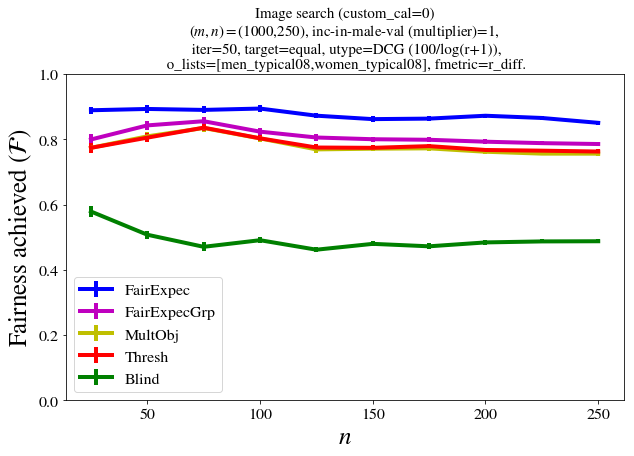

In [181]:
# Generate Figure 8
for utility_type in range(1):
    for fair_metric in ['r_diff']:
        plot_for_diff_n_image(iter=50, m=1000, n=50, o_list=men_typical08, bias_value_multiplier=1,\
                         utility_type=utility_type, name_o_list="men_typical08",\
                         o_list2=women_typical08, name_o_list2="women_typical08",\
                         lam=[0,0,0,1.0,2000.0], fair_metric=fair_metric, verbose=0, save=1)